In [1]:
# Import required libraries
import pymrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import pickle
from datetime import datetime
import os

# Set display options for better readability
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully")
print(f"pymrio version: {pymrio.__version__}")

Libraries imported successfully
pymrio version: 0.5.4


In [2]:
# Define data paths
BASE_PATH = Path(r"C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit")
EXIOBASE_PATH = BASE_PATH / "Exiobase3_ixi_latest"
RESULTS_PATH = BASE_PATH / "Results"
POPULATION_FILE = BASE_PATH / "code" / "producerappraoch" / "clean code" / "exiobase3_population_2022_official.csv"

# Create results directory if it doesn't exist
RESULTS_PATH.mkdir(exist_ok=True)

# Define analysis parameters
SINGLE_YEAR = 2019  # For detailed single-year analysis
YEARS_TIME_SERIES = list(range(1995, 2023))  # 1995-2022

print(f"Base path: {BASE_PATH}")
print(f"EXIOBASE data path: {EXIOBASE_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Years for time series: {YEARS_TIME_SERIES[0]}-{YEARS_TIME_SERIES[-1]}")

Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022


In [3]:
def load_population_data():
    """Load population data for 2022."""
    print(f"Loading population data from: {POPULATION_FILE}")
    
    if not POPULATION_FILE.exists():
        print(f"ERROR: Population file not found!")
        return None
    
    # Load CSV
    pop_df = pd.read_csv(POPULATION_FILE)
    print(f"Population data shape: {pop_df.shape}")
    print(f"Columns: {pop_df.columns.tolist()}")
    
    # Display first few rows to understand structure
    print("\nFirst 5 rows:")
    print(pop_df.head())
    
    # ADJUST THIS BASED ON YOUR ACTUAL CSV STRUCTURE
    if 'EXIOBASE3_Code' in pop_df.columns and 'Population_2022' in pop_df.columns:
        population = pd.Series(
            pop_df['Population_2022'].values,
            index=pop_df['EXIOBASE3_Code']
        )
        return population
    else:
        print("Please check column names and adjust the code!")
        return None

# Load population
population_2022 = load_population_data()


Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)


In [4]:
# Define greenhouse gas categories with IPCC AR6 GWP100 factors
EMISSION_CATEGORIES = {
    # CO2 emissions (GWP = 1.0)
    'CO2 - combustion - air': 1.0,
    'CO2 - waste - fossil - air': 1.0,
    'CO2 - agriculture - peat decay - air': 1.0,
    'CO2 - non combustion - Cement production - air': 1.0,
    'CO2 - non combustion - Lime production - air': 1.0,
    
    # CH4 emissions - Combustion (GWP = 27.0)
    'CH4 - combustion - air': 27.0,
    
    # CH4 emissions - Fugitive/Process (GWP = 29.8)
    'CH4 - non combustion - Extraction/production of (natural) gas - air': 29.8,
    'CH4 - non combustion - Extraction/production of crude oil - air': 29.8,
    'CH4 - non combustion - Oil refinery - air': 29.8,
    'CH4 - non combustion - Mining of bituminous coal - air': 29.8,
    'CH4 - non combustion - Mining of coking coal - air': 29.8,
    'CH4 - non combustion - Mining of lignite (brown coal) - air': 29.8,
    'CH4 - non combustion - Mining of sub-bituminous coal - air': 29.8,
    
    # CH4 emissions - Biogenic (GWP = 27.0)
    'CH4 - agriculture - air': 27.0,
    'CH4 - waste - air': 27.0,
    
    # N2O emissions (GWP = 273.0)
    'N2O - combustion - air': 273.0,
    'N2O - agriculture - air': 273.0,
    
    # Industrial gases
    'SF6 - air': 25184.0,
    'HFC - air': 1.0,  # Already in CO2-eq
    'PFC - air': 1.0   # Already in CO2-eq
}

# Define value-added components
VALUE_ADDED_COMPONENTS = [
    "Taxes less subsidies on products purchased: Total",     # taxes to be exculded later
    "Other net taxes on production",
    "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
    "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled",
    "Operating surplus: Consumption of fixed capital",    
    "Operating surplus: Rents on land",
    "Operating surplus: Royalties on resources",
    "Operating surplus: Remaining net operating surplus"    ###profit
]
     
# The profit row is row number 8 in factor_inputs (0-based index).

print(f"Defined {len(EMISSION_CATEGORIES)} emission categories")
print(f"Defined {len(VALUE_ADDED_COMPONENTS)} value-added components")

Defined 20 emission categories
Defined 9 value-added components


In [146]:
# Print all unique sector names in EXIOBASE
all_sectors = sorted(set(ixi_data.get_sectors()))
print("=== EXIOBASE SECTORS ===")
for sector in all_sectors:
    print(sector)

=== EXIOBASE SECTORS ===
Activities auxiliary to financial intermediation (67)
Activities of membership organisation n.e.c. (91)
Air transport (62)
Aluminium production
Animal products nec
Biogasification of food waste, incl. land application
Biogasification of paper, incl. land application
Biogasification of sewage slugde, incl. land application
Casting of metals
Cattle farming
Chemicals nec
Collection, purification and distribution of water (41)
Composting of food waste, incl. land application
Composting of paper and wood, incl. land application
Computer and related activities (72)
Construction (45)
Copper production
Cultivation of cereal grains nec
Cultivation of crops nec
Cultivation of oil seeds
Cultivation of paddy rice
Cultivation of plant-based fibers
Cultivation of sugar cane, sugar beet
Cultivation of vegetables, fruit, nuts
Cultivation of wheat
Distribution and trade of electricity
Education (80)
Extra-territorial organizations and bodies
Extraction of crude petroleum and se

In [147]:
# sector_classification: fossil-related sectors extracted from your EXIOBASE list
sector_classification = {
    "coal": [
        "Mining of coal and lignite; extraction of peat (10)",
        "Production of electricity by coal",
        "Manufacture of coke oven products",
    ],
    "oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
        "Petroleum Refinery",
        "Production of electricity by petroleum and other oil derivatives",
        "Retail sale of automotive fuel",
        "Incineration of waste: Oil/Hazardous waste",
        "Plastics, basic",  # petrochemical (typical oil/gas feedstock) — included as oil/petrochemical
    ],
    "gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
        "Manufacture of gas; distribution of gaseous fuels through mains",
        "Production of electricity by gas",
        "Transport via pipelines",  # primarily oil & gas pipelines — treat as gas/oil infra
        "N-fertiliser",            # ammonia production typically gas-fed (feedstock/intensive)
    ],
    "fossil_electricity": [
        # note: production-by-fuel already in coal/gas/oil above; these are system-level electricity services
        "Distribution and trade of electricity",
        "Transmission of electricity",
        "Steam and hot water supply",   # often fossil-fuel based (esp. district heat)
    ],
    "renewable": [
        "Production of electricity by Geothermal",
        "Production of electricity by biomass and waste",
        "Production of electricity by hydro",
        "Production of electricity by solar photovoltaic",
        "Production of electricity by solar thermal",
        "Production of electricity by tide, wave, ocean",
        "Production of electricity by wind",
    ],
    "other_fossil_intensive": [
        # heavy industrial users / fossil-intensive but not strictly "fossil extraction/refining"
        "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
        "Manufacture of cement, lime and plaster",
        "Manufacture of other non-metallic mineral products n.e.c.",
    
    ],
    
}

# Flatten check: create a set of all classified sector names
all_classified = set()
for k, lst in sector_classification.items():
    if isinstance(lst, list):
        all_classified.update(lst)

In [153]:
# Create “other” groups
other_categories = {
    "industry_heavy": [
        "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
        "Manufacture of cement, lime and plaster",
        "Manufacture of other non-metallic mineral products n.e.c.",
        "Aluminium production",
        "Copper production",
        "Lead, zinc and tin production",
        "Other non-ferrous metal production",
    ],
    "industry_light": [
        "Chemicals nec",
        "Manufacture of beverages",
        "Manufacture of fabricated metal products, except machinery and equipment (28)",
        "Manufacture of machinery and equipment n.e.c. (29)",
        "Manufacture of motor vehicles, trailers and semi-trailers (34)",
        "Manufacture of textiles (17)",
        "Manufacture of rubber and plastic products (25)",
    ],
    "agriculture": [
        "Cattle farming",
        "Poultry farming",
        "Pigs farming",
        "Meat animals nec",
        "Cultivation of cereal grains nec",
        "Cultivation of crops nec",
        "Cultivation of oil seeds",
        "Cultivation of paddy rice",
        "Cultivation of vegetables, fruit, nuts",
        "Cultivation of sugar cane, sugar beet",
        "Cultivation of wheat",
        "Raw milk",
    ],
    "transport": [
        "Air transport (62)",
        "Other land transport",
        "Sea and coastal water transport",
        "Inland water transport",
        "Supporting and auxiliary transport activities; activities of travel agencies (63)",
        "Sale, maintenance, repair of motor vehicles, motor vehicles parts and motorcycles",
    ],
    "services": [
        "Financial intermediation, except insurance and pension funding (65)",
        "Activities auxiliary to financial intermediation (67)",
        "Computer and related activities (72)",
        "Research and development (73)",
        "Education (80)",
        "Health and social work (85)",
        "Hotels and restaurants (55)",
        "Other business activities (74)",
        "Real estate activities (70)",
    ],
    "waste_and_recycling": [
        "Incineration of waste: Food",
        "Incineration of waste: Metals and Inert materials",
        "Incineration of waste: Paper",
        "Incineration of waste: Plastic",
        "Incineration of waste: Textiles",
        "Incineration of waste: Wood",
        "Recycling of waste and scrap",
        "Landfill of waste: Food",
        "Landfill of waste: Inert/metal/hazardous",
        "Landfill of waste: Paper",
        "Landfill of waste: Plastic",
        "Landfill of waste: Textiles",
        "Landfill of waste: Wood",
        "Composting of food waste, incl. land application",
        "Composting of paper and wood, incl. land application",
        "Manure treatment (biogas), storage and land application",
        "Manure treatment (conventional), storage and land application",
    ]
}
sector_classification.update(other_categories)

# Create a flat mapping: sector → category for easy `.map()`
sector_to_category = {}
for cat, sectors in sector_classification.items():
    for sec in sectors:
        sector_to_category[sec] = cat

# Now you can classify any sector:
df_all['category'] = df_all['sector'].map(sector_to_category).fillna('other')


In [154]:
# alle fossil fuel Sektoren auf einen Schlag (ohne renewables & andere)
fossil_categories = ["coal", "oil", "gas", "fossil_electricity"]
fossil_sectors = [s for cat in fossil_categories for s in sector_classification[cat]]

# jetzt hast du eine Liste aller fossilen Sektoren:
print(fossil_sectors[:10])  # nur als check

['Mining of coal and lignite; extraction of peat (10)', 'Production of electricity by coal', 'Manufacture of coke oven products', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 'Petroleum Refinery', 'Production of electricity by petroleum and other oil derivatives', 'Retail sale of automotive fuel', 'Incineration of waste: Oil/Hazardous waste', 'Plastics, basic', 'Extraction of natural gas and services related to natural gas extraction, excluding surveying']


In [5]:

# Ensure ixi_data is defined
# If not already loaded, load it for SINGLE_YEAR
if 'ixi_data' not in globals():
    import pymrio
    ixi_data = pymrio.parse_exiobase3(
        str(EXIOBASE_PATH / f"IOT_{SINGLE_YEAR}_ixi.zip")
    )
    ixi_data.calc_system()

# Ensure factor_inputs is defined
factor_inputs = ixi_data.factor_inputs.F

# Get the profits row from factor_inputs (row 8: 'Operating surplus: Remaining net operating surplus')
profits_row = factor_inputs.iloc[8, :]  # Row 8: profits

print("=== PROFITS ROW ANALYSIS ===")
print(f"Profits row shape: {profits_row.shape}")
print(f"Profits min: {profits_row.min()}")
print(f"Profits max: {profits_row.max()}")
print(f"Profits mean: {profits_row.mean()}")
print(f"Non-zero count: {(profits_row != 0).sum()}")
print(f"Positive count: {(profits_row > 0).sum()}")
print(f"Negative count: {(profits_row < 0).sum()}")
print("Top 5 sectors with highest profits:")
top_5_profits = profits_row.nlargest(5)
for idx, value in top_5_profits.items():
    print(f"  {idx}: {value}")

=== PROFITS ROW ANALYSIS ===
Profits row shape: (7987,)
Profits min: -283367.273308
Profits max: 968521.54211
Profits mean: 2042.276372926735
Non-zero count: 6239
Positive count: 5773
Negative count: 466
Top 5 sectors with highest profits:
  ('US', 'Real estate activities (70)'): 968521.54211
  ('US', 'Other business activities (74)'): 336622.757554
  ('US', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'): 303718.356042
  ('WM', 'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying'): 297604.91347
  ('JP', 'Real estate activities (70)'): 291569.754796


In [6]:
# Clean value-added coefficients for VABR analysis
import numpy as np

# Ensure ixi_data is defined for the selected year
import pymrio
ixi_data = pymrio.parse_exiobase3(
    str(EXIOBASE_PATH / f"IOT_{SINGLE_YEAR}_ixi.zip")
)
ixi_data.calc_system()

# Calculate value-added (VA)
factor_inputs = ixi_data.factor_inputs.F
if VALUE_ADDED_COMPONENTS:
    VA = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).values
else:
    VA = factor_inputs.sum(axis=0).values

# Fix 1: Set minimum VA to 0 million EUR to avoid negatives or instability
# Set any negative value-added (VA) to 0 million EUR to avoid negatives or instability
VA[VA < 0] = 0

# Calculate total output and raw value-added coefficients
total_output = ixi_data.x.values.flatten()
v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))

# Copy v to v_clean and apply cleaning rules
v_clean = v.copy()

# Fix 2: Cap coefficients > 1 (prevents over-allocation)
v_clean[v_clean > 1] = 1

# Optional fix 3: Set any negative coefficients to 0 (should be none due to VA fix)
v_clean[v_clean < 0] = 0

# Print summary statistics before and after cleaning
print("Value-added coefficient statistics BEFORE cleaning:")
print(f"  Min: {v.min():.4f}, Max: {v.max():.4f}, Negatives: {np.sum(v < 0)}, >1: {np.sum(v > 1)}")
print("Value-added coefficient statistics AFTER cleaning:")
print(f"  Min: {v_clean.min():.4f}, Max: {v_clean.max():.4f}, Negatives: {np.sum(v_clean < 0)}, >1: {np.sum(v_clean > 1)}")

# Use v_clean in your VABR calculation


Value-added coefficient statistics BEFORE cleaning:
  Min: 0.0000, Max: 1.7726, Negatives: 0, >1: 37
Value-added coefficient statistics AFTER cleaning:
  Min: 0.0000, Max: 1.0000, Negatives: 0, >1: 0


In [7]:
def get_maritime_aviation_indices(sector_index):
    """
    Find indices for 'Sea and coastal water transport' and 'Air transport' sectors in EXIOBASE.
    Returns a list of sector indices (0-162).
    """
    target_sectors = ['Sea and coastal water transport', 'Air transport']
    found_indices = []
    # sector_index is a MultiIndex; get sector names from level 1
    sector_names = sector_index.get_level_values(1)
    for target in target_sectors:
        matches = [i for i, name in enumerate(sector_names) if name == target]
        if matches:
            found_indices.extend(matches)
            

<!-- (Removed old Data Cleaning and VABR Diagnostics markdown. See new VABR cell for correct method.) -->

MAIN CALCULATIONS

In [8]:
def calculate_producer_responsibility(ixi_data, emission_categories):
    """
    Calculate producer-based responsibility.
    Units: tonnes CO2-eq per sector-region
    """
    # Get emissions data (EXIOBASE is in kilograms!)
    air_emissions_kg = ixi_data.air_emissions.F
    
    # Convert kg to tonnes (divide by 1000)
    air_emissions_tonnes = air_emissions_kg / 1000  # kg → tonnes
    
    
    # Check for missing categories
    missing_emissions = [em for em in emission_categories.keys() 
                        if em not in air_emissions_tonnes.index.tolist()]
    
    # Initialize results array
    n_sectors_regions = len(air_emissions_tonnes.columns)
    producer_emissions = np.zeros(n_sectors_regions)  # Will contain tonnes
    
    # Calculate total GHG emissions
    for emission_type, gwp_factor in emission_categories.items():
        if emission_type in air_emissions_tonnes.index:
            # Get emissions in tonnes
            emission_data_tonnes = air_emissions_tonnes.loc[emission_type].values
            
            # Convert to tonnes CO2-eq
            co2_equiv_tonnes = emission_data_tonnes * gwp_factor
            
            # Add to total
            producer_emissions += co2_equiv_tonnes
    
    return producer_emissions, missing_emissions  # Returns tonnes

In [9]:
def calculate_consumer_responsibility(ixi_data, producer_emissions):
    """
    Calculate consumer-based responsibility following Piñero et al. (2019).
    
    Key insight: We must track which country consumes, not where production occurs.
    Formula: t' = f' × B × ŷ where ŷ is country-specific final demand
    Producer emissions in Gt
    """
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    # Calculate emission intensities (f' in Piñero)
    total_output = ixi_data.x.values.flatten()
    emission_intensity_t = np.divide(
    producer_emissions,   # Convert kg → tonnes
    total_output,
    out=np.zeros_like(producer_emissions),
    where=(total_output != 0)
)
# This gives you: tonnes CO2-eq per million EUR
    
    # Get Leontief inverse (B in Piñero)
    B = ixi_data.L.values
    
    # Get final demand matrix
    Y_full = ixi_data.Y
    
    # Extract final demand categories for detailed analysis
    fd_categories = Y_full.columns.get_level_values(1).unique()
    
    # Initialize results storage
    consumer_by_country = {}
    consumer_by_country_category = {}  # NEW: Keep category detail
    consumer_by_sector_region = {}
    
    # Calculate for each consuming country
    for region in regions:
        # Get ALL columns where this region is the consumer
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region_all = Y_full.loc[:, region_mask]
        
        # Store by category for detailed analysis
        consumer_by_country_category[region] = {}
        
        # Calculate for each final demand category
        for category in fd_categories:
            # Get specific category for this region
            category_mask = Y_region_all.columns.get_level_values(1) == category
            Y_region_category = Y_region_all.loc[:, category_mask].sum(axis=1).values
            
            # Apply Piñero formula: t' = f' × B × ŷ
            # Step 1: B × ŷ (total requirements)
            total_requirements = B @ Y_region_category
            
            # Step 2: f' × (B × ŷ) (emissions)
            emissions_category = emission_intensity_t * total_requirements
            
            # Store category-specific results
            consumer_by_country_category[region][category] = emissions_category.sum()
        
        # Also calculate total for the country (all categories)
        Y_region_total = Y_region_all.sum(axis=1).values
        total_requirements_all = B @ Y_region_total
        emissions_total = emission_intensity_t * total_requirements_all
        
        # Store results
        consumer_by_country[region] = emissions_total.sum()
        consumer_by_sector_region[region] = pd.Series(
            emissions_total,
            index=ixi_data.x.index
        )
    
    return consumer_by_country, consumer_by_sector_region, consumer_by_country_category

<!-- (Removed old VALUE ADDED APPROACH markdown. See new VABR cell for correct method.) -->

### old VABR calculation ( vabr smaller than consumer) 
def calculate_value_added_responsibility(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Piñero et al. (2019) VABR method:
    1. Calculate consumer responsibility: t_j = f * (B @ y_j)
    2. Stack all t_j into t (vector of sector-region emissions embodied in all final demand)
    3. Reallocate: h = v * (B @ t)
    This applies the Leontief inverse twice, as in Piñero's Equation 6.
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)
    
    # STEP 1: Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F
    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        missing_va = [comp for comp in value_added_components if comp not in factor_inputs.index]
        if missing_va:
            print(f"ERROR: Missing VA components: {missing_va}")
            return None, None, None, [f"Missing components: {missing_va}"]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients (v_clean)")
    
    # STEP 2: Emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    
    # STEP 3: Calculate t_j for each consuming region, sum to get t
    t = np.zeros(n_sectors_regions)
    consumer_by_region = {}
    for j, consuming_region in enumerate(regions):
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        t_j = emission_intensity * (B @ y_j)
        t += t_j
        consumer_by_region[consuming_region] = t_j.sum()
    
    # STEP 4: Reallocate with value-added and Leontief inverse
    h = v * (B @ t)
    
    # STEP 5: Aggregate by producing region
    actual_region_order = ixi_data.x.index.get_level_values(0).unique()
    vabr_by_country = {}
    vabr_by_sector_region = {}
    for producing_region in actual_region_order:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        vabr_by_country[producing_region] = h[region_mask].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            h[region_mask],
            index=ixi_data.x.index[region_mask]
        )
    
    # Diagnostics
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    total_vabr = sum(vabr_by_country.values())
    print(f"\n=== MASS CONSERVATION CHECK ===")
    print(f"Producer total:  {total_producer/1e9:.3f} Gt CO2-eq")
    print(f"Consumer total:  {total_consumer/1e9:.3f} Gt CO2-eq")
    print(f"VABR total:      {total_vabr/1e9:.3f} Gt CO2-eq")
    diff_consumer = abs(total_consumer - total_producer) / total_producer * 100
    diff_vabr = abs(total_vabr - total_producer) / total_producer * 100
    print(f"\nDifferences from producer:")
    print(f"Consumer: {diff_consumer:.6f}%")
    print(f"VABR:     {diff_vabr:.6f}%")
    issues = []
    if (v > 1.0).sum() > 0:
        issues.append(f"{(v > 1.0).sum()} sectors with VA coefficient > 1.0")
    if (v < 0.0).sum() > 0:
        issues.append(f"{(v < 0.0).sum()} sectors with negative VA coefficient")
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    print(f"\n=== CALCULATION COMPLETE ===")
    print(f"VABR allocated to {len(vabr_by_country)} regions")
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

In [10]:
# (Replaces previous calculate_value_added_responsibility)
def calculate_vabr_mass_conserving_FINAL(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    FINAL CORRECT VABR Implementation - Mass Conservation Guaranteed
    
    Key insight: VABR reallocates consumer emissions based on value-added creation
    WITHOUT changing the total emissions (pure reallocation)
    
    Method: For each consuming region's emissions, trace value creation through
    supply chains and allocate proportionally to value creators
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)

    print(f"\n=== FINAL MASS-CONSERVING VABR CALCULATION ===")
    # STEP 1: Get value-added coefficients
    # NOT exclude taxes/subsidies; use factor_inputs as is
    factor_inputs = ixi_data.factor_inputs.F.copy()

    if value_added_components:
        available_va = factor_inputs.loc[value_added_components]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values

    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    
    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients")
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    print(f"Mean value-added coefficient: {v.mean():.4f}")
    print(f"Non-zero VA coefficients: {(v > 0).sum()}/{len(v)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility first (baseline for reallocation)
    print("Calculating consumer responsibility baseline...")
    
    consumer_by_region = {}
    consumer_emissions_vectors = {}
    
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # Consumer emissions vector for this region
        t_j_vector = emission_intensity * (B @ y_j)
        
        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: CORRECT VABR REALLOCATION
    print("Reallocating emissions based on value-added creation...")
    
    # Initialize VABR allocation vector
    vabr_allocation = np.zeros(n_sectors_regions)
    
    # For each consuming region, reallocate its emissions based on value creation
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        
        # This region's total consumer emissions (to be reallocated)
        total_emissions_to_reallocate = consumer_by_region[consuming_region]
        
        if total_emissions_to_reallocate == 0:
            continue
            
        # Calculate value-added creation for this region's consumption
        # Method: For each sector i, calculate how much value it created
        # for this consumption pattern
        
        # Value creation = v[i] * (B[i,:] @ y_j)
        # This shows how much value sector i created for consumption y_j
        value_creation = v * (B @ y_j)
        
        # Total value created in this supply chain
        total_value_created = value_creation.sum()
        
        if total_value_created > 0:
            # Allocate this region's emissions proportionally to value creation
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            # If no value created, fall back to uniform allocation
            print(f"Warning: No value created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}
    
    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]
        
        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

   

    # STEP 6: VALIDATION 
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")


    # STEP 7: Check country patterns
    print(f"\n=== VABR vs CONSUMER PATTERNS ===")
    
    winners = []  # Countries that get more under VABR
    losers = []   # Countries that get less under VABR
    
    for country in ['US', 'CN', 'DE', 'JP', 'IN', 'RU']:
        if country in consumer_by_region and country in vabr_by_country:
            cons = consumer_by_region[country]/1e9
            vabr = vabr_by_country[country]/1e9
            ratio = vabr/cons if cons > 0 else 0
            change = vabr - cons
            
            print(f"{country}: Consumer={cons:.3f} Gt, VABR={vabr:.3f} Gt")
            print(f"       Ratio={ratio:.3f}, Change={change:+.3f} Gt")
            
            if ratio > 1.05:
                winners.append(country)
            elif ratio < 0.95:
                losers.append(country)
    
    print(f"\nCountries gaining responsibility under VABR: {winners}")
    print(f"Countries losing responsibility under VABR: {losers}")
    
 
    
    # Return results
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)
    
    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")
    
    return vabr_totals, vabr_by_sector_region, consumer_totals, issues,v



<!-- (Removed outdated VABR unit test explanation. See new VABR cell for correct method.) -->

In [11]:
def calculate_vabr_excluding_taxes(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    VABR calculation excluding 'Taxes less subsidies on products purchased: Total' from value-added.
    This zeros out the taxes row before calculating VA.
    """
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors_regions = len(ixi_data.x)

    print(f"\n=== VABR CALCULATION (EXCLUDING TAXES) ===")
    # STEP 1: Get value-added coefficients, exclude taxes row
    factor_inputs = ixi_data.factor_inputs.F.copy()
    taxes_row_name = "Taxes less subsidies on products purchased: Total"
    va_rows = [row for row in factor_inputs.index if row != taxes_row_name]
    if taxes_row_name in factor_inputs.index:
        print(f"Excluding taxes row: '{taxes_row_name}' from value-added calculation")

    if value_added_components:
        # Only use requested components, but exclude taxes if present
        va_comps = [c for c in value_added_components if c != taxes_row_name]
        available_va = factor_inputs.loc[va_comps]
        VA = available_va.sum(axis=0).values
    else:
        VA = factor_inputs.loc[va_rows].sum(axis=0).values

    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))

    if v_override is not None:
        v = v_override
        print("Using cleaned value-added coefficients")
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    print(f"Mean value-added coefficient: {v.mean():.4f}")
    print(f"Non-zero VA coefficients: {(v > 0).sum()}/{len(v)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        total_output,
        out=np.zeros_like(producer_emissions),
        where=(total_output != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility first (baseline for reallocation)
    print("Calculating consumer responsibility baseline...")

    consumer_by_region = {}
    consumer_emissions_vectors = {}

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        # Consumer emissions vector for this region
        t_j_vector = emission_intensity * (B @ y_j)

        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: CORRECT VABR REALLOCATION
    print("Reallocating emissions based on value-added creation...")

    # Initialize VABR allocation vector
    vabr_allocation = np.zeros(n_sectors_regions)

    # For each consuming region, reallocate its emissions based on value creation
    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        # This region's total consumer emissions (to be reallocated)
        total_emissions_to_reallocate = consumer_by_region[consuming_region]

        if total_emissions_to_reallocate == 0:
            continue

        # Calculate value-added creation for this region's consumption
        value_creation = v * (B @ y_j)
        total_value_created = value_creation.sum()

        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            print(f"Warning: No value created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}

    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]

        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    # STEP 6: VALIDATION (simplified)
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    # STEP 7: Check country patterns
    print(f"\n=== VABR vs CONSUMER PATTERNS ===")

    winners = []
    losers = []

    for country in ['US', 'CN', 'DE', 'JP', 'IN', 'RU']:
        if country in consumer_by_region and country in vabr_by_country:
            cons = consumer_by_region[country]/1e9
            vabr = vabr_by_country[country]/1e9
            ratio = vabr/cons if cons > 0 else 0
            change = vabr - cons

            print(f"{country}: Consumer={cons:.3f} Gt, VABR={vabr:.3f} Gt")
            print(f"       Ratio={ratio:.3f}, Change={change:+.3f} Gt")

            if ratio > 1.05:
                winners.append(country)
            elif ratio < 0.95:
                losers.append(country)

    print(f"\nCountries gaining responsibility under VABR: {winners}")
    print(f"Countries losing responsibility under VABR: {losers}")

   

    # Return results
    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

In [12]:
import numpy as np
import pandas as pd

def calculate_vabr_technology_adjusted(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Technology-adjusted VABR following Kander et al. (2015):
    1. Calculate world average emissions intensity by sector (across all countries)
    2. Replace actual emission intensities with world averages for consumer baseline
    3. Apply standard VABR allocation to tech-adjusted baseline
    4. Ensure mass conservation
    Returns:
        tech_consumer_by_country: pd.Series (country totals, tech-adjusted consumer baseline)
        tech_vabr_by_country: pd.Series (country totals, tech-adjusted VABR)
        issues: list of warnings/errors
    """

    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors = len(sectors)
    n_countries = len(regions)
    n_sectors_regions = len(ixi_data.x)

    # Step 1: World average emissions intensity by sector
    # Get sector-region index
    index = ixi_data.x.index
    # For each sector, sum emissions and output across all countries
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)

    world_avg_intensity = {}
    for sector in sectors:
        sector_mask = sector_names == sector
        total_emissions = producer_emissions_series[sector_mask].sum()
        total_output = output_series[sector_mask].sum()
        if total_output > 0:
            world_avg_intensity[sector] = total_emissions / total_output
        else:
            world_avg_intensity[sector] = 0.0

    # Build world_avg_intensity vector for all sector-regions (matches index order)
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    # Step 2: Technology-adjusted consumer baseline
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    tech_consumer_by_country = {}
    tech_consumer_vectors = {}

    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        # t_tech = world_avg_intensity × (B @ y_j)
        total_requirements = B @ y_j
        t_tech_vector = world_avg_intensity_vector * total_requirements
        tech_consumer_by_country[region] = t_tech_vector.sum()
        tech_consumer_vectors[region] = t_tech_vector

    total_tech_consumer = sum(tech_consumer_by_country.values())

    # Step 3: Apply standard VABR allocation to tech-adjusted baseline
    # Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    # VABR allocation
    tech_vabr_allocation = np.zeros(n_sectors_regions)
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        total_emissions_to_reallocate = tech_consumer_by_country[region]
        if total_emissions_to_reallocate == 0:
            continue
        # Value creation for this region's consumption
        value_creation = v * (B @ y_j)
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            tech_vabr_allocation += allocated_emissions
        else:
            # Uniform allocation fallback
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            tech_vabr_allocation += uniform_allocation

    # Aggregate by country
    tech_vabr_by_country = {}
    for region in regions:
        region_mask = index.get_level_values(0) == region
        tech_vabr_by_country[region] = tech_vabr_allocation[region_mask].sum()

    # Step 4: Mass conservation check
    total_tech_vabr = sum(tech_vabr_by_country.values())
    vabr_error = abs(total_tech_vabr - total_tech_consumer) / total_tech_consumer * 100 if total_tech_consumer > 0 else 0

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    # Return as pandas Series for consistency
    tech_consumer_by_country = pd.Series(tech_consumer_by_country)
    tech_vabr_by_country = pd.Series(tech_vabr_by_country)

    print(f"[Tech-VABR] Consumer total: {total_tech_consumer/1e9:.3f} Gt, VABR: {total_tech_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    return tech_consumer_by_country, tech_vabr_by_country, issues

In [13]:
def calculate_vabr_profits_only(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    VABR calculation using ONLY 'Operating surplus: Remaining net operating surplus' as value-added.
    Mass-conserving normalization, allocation based solely on profits.
    """
    regions = ixi_data.get_regions()
    n_sectors_regions = len(ixi_data.x)

    print("\n=== VABR CALCULATION (PROFITS ONLY) ===")

    # STEP 1: Get profit-only value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    x_vector = ixi_data.x.values.flatten()
    profits = factor_inputs.iloc[8, :].values  # Row 8: Remaining net operating surplus

    # Calculate profit coefficients
    v_profits = np.divide(profits, x_vector, out=np.zeros_like(profits), where=(x_vector != 0))

    if v_override is not None:
        v_profits = v_override
        print("Using cleaned profit coefficients")
    else:
        v_profits[v_profits < 0] = 0
        v_profits[v_profits > 2] = 2

    print(f"Mean profit coefficient: {v_profits.mean():.4f}")
    print(f"Non-zero profit coefficients: {(v_profits > 0).sum()}/{len(v_profits)}")

    # STEP 2: Get matrices and emission intensity
    emission_intensity = np.divide(
        producer_emissions,
        x_vector,
        out=np.zeros_like(producer_emissions),
        where=(x_vector != 0)
    )
    B = ixi_data.L.values
    Y_full = ixi_data.Y

    # STEP 3: Calculate consumer responsibility baseline
    print("Calculating consumer responsibility baseline...")
    consumer_by_region = {}
    consumer_emissions_vectors = {}

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        t_j_vector = emission_intensity * (B @ y_j)
        consumer_by_region[consuming_region] = t_j_vector.sum()
        consumer_emissions_vectors[consuming_region] = t_j_vector

    total_consumer = sum(consumer_by_region.values())
    print(f"Total consumer emissions: {total_consumer/1e9:.3f} Gt")

    # STEP 4: VABR reallocation using profit coefficients
    print("Reallocating emissions based on profits only...")
    vabr_allocation = np.zeros(n_sectors_regions)

    for consuming_region in regions:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values

        total_emissions_to_reallocate = consumer_by_region[consuming_region]
        if total_emissions_to_reallocate == 0:
            continue

        value_creation = v_profits * (B @ y_j)
        total_value_created = value_creation.sum()

        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            vabr_allocation += allocated_emissions
        else:
            print(f"Warning: No profits created for {consuming_region}, using uniform allocation")
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            vabr_allocation += uniform_allocation

    # STEP 5: Aggregate by country
    vabr_by_country = {}
    vabr_by_sector_region = {}

    for producing_region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == producing_region
        region_indices = np.where(region_mask)[0]
        vabr_by_country[producing_region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[producing_region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    # STEP 6: Validation
    total_vabr = sum(vabr_by_country.values())
    total_producer = producer_emissions.sum()
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100

    print(f"[VABR PROFITS] Producer: {total_producer/1e9:.3f} Gt, Consumer: {total_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_profits

In [14]:
import numpy as np
import pandas as pd

def calculate_vabr_profits_technology_adjusted(ixi_data, producer_emissions, v_override=None):
    """
    VABR variant: 
    - Uses only profits as value-added (row 8: "Operating surplus: Remaining net operating surplus")
    - Uses world average emissions intensity by sector (technology-adjusted baseline)
    Returns:
        tech_consumer_by_country: pd.Series (country totals, tech-adjusted consumer baseline)
        profits_tech_vabr_by_country: pd.Series (country totals, profits-only tech-adjusted VABR)
        issues: list of warnings/errors
    """

    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_sectors = len(sectors)
    n_sectors_regions = len(ixi_data.x)
    index = ixi_data.x.index

    # Step 1: World average emissions intensity by sector
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    world_avg_intensity = {}
    for sector in sectors:
        sector_mask = sector_names == sector
        total_emissions = producer_emissions_series[sector_mask].sum()
        total_output = output_series[sector_mask].sum()
        if total_output > 0:
            world_avg_intensity[sector] = total_emissions / total_output
        else:
            world_avg_intensity[sector] = 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    # Step 2: Technology-adjusted consumer baseline
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    tech_consumer_by_country = {}
    tech_consumer_vectors = {}
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        Y_region = Y_full.loc[:, region_mask]
        y_j = Y_region.sum(axis=1).values
        total_requirements = B @ y_j
        t_tech_vector = world_avg_intensity_vector * total_requirements
        tech_consumer_by_country[region] = t_tech_vector.sum()
        tech_consumer_vectors[region] = t_tech_vector
    total_tech_consumer = sum(tech_consumer_by_country.values())

    # Step 3: Profits-only value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    x_vector = ixi_data.x.values.flatten()
    profits_va = factor_inputs.iloc[8, :].values  # Row 8: profits
    v_profits = np.divide(profits_va, x_vector, out=np.zeros_like(profits_va), where=(x_vector != 0))
    if v_override is not None:
        v_profits = v_override
    else:
        v_profits[v_profits < 0] = 0
        v_profits[v_profits > 2] = 2

    # Step 4: VABR allocation using profits coefficients and tech-adjusted baseline
    profits_tech_vabr_allocation = np.zeros(n_sectors_regions)
    for region in regions:
        t_tech_vector = tech_consumer_vectors[region]
        total_emissions_to_reallocate = t_tech_vector.sum()
        if total_emissions_to_reallocate == 0:
            continue
        # Value creation for this region's consumption
        value_creation = v_profits * t_tech_vector
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            allocated_emissions = total_emissions_to_reallocate * allocation_shares
            profits_tech_vabr_allocation += allocated_emissions
        else:
            # Uniform allocation fallback
            uniform_allocation = total_emissions_to_reallocate / n_sectors_regions
            profits_tech_vabr_allocation += uniform_allocation

    # Step 5: Aggregate by country
    profits_tech_vabr_by_country = {}
    for region in regions:
        region_mask = index.get_level_values(0) == region
        profits_tech_vabr_by_country[region] = profits_tech_vabr_allocation[region_mask].sum()

    # Step 6: Mass conservation check
    total_vabr = sum(profits_tech_vabr_by_country.values())
    vabr_error = abs(total_vabr - total_tech_consumer) / total_tech_consumer * 100 if total_tech_consumer > 0 else 0
    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    # Return as pandas Series for consistency
    tech_consumer_by_country = pd.Series(tech_consumer_by_country)
    profits_tech_vabr_by_country = pd.Series(profits_tech_vabr_by_country)

    print(f"[Profits-Tech-VABR] Consumer total: {total_tech_consumer/1e9:.3f} Gt, VABR: {total_vabr/1e9:.3f} Gt, Error: {vabr_error:.6f}%")

    return tech_consumer_by_country, profits_tech_vabr_by_country, issues

In [15]:
def calculate_vabr_exclude_maritime_aviation(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Exclude maritime and aviation sector responsibility for ALL countries in VABR results.
    Returns original and modified results, excluded sector names, and total excluded responsibility.
    """
    # 1. Get sector indices for maritime and aviation
    sector_index = ixi_data.x.index
    excluded_indices = get_maritime_aviation_indices(sector_index)
    excluded_sector_names = [sector_index.get_level_values(1)[i] for i in excluded_indices]

    # 2. Run original VABR
    vabr_results = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override
    )
    vabr_by_country = vabr_results[0].copy()
    vabr_by_sector_region = {k: v.copy() for k, v in vabr_results[1].items()}

    # 3. Zero out maritime/aviation sectors for all countries
    total_excluded = 0.0
    n_countries = len(ixi_data.get_regions())
    n_sectors = len(ixi_data.get_sectors())
    for country in vabr_by_sector_region:
        sector_series = vabr_by_sector_region[country]
        for idx in excluded_indices:
            # Calculate the absolute index for this country
            abs_idx = idx
            # MultiIndex: ('country', sector_name)
            sector_name = sector_index.get_level_values(1)[idx]
            sector_tuple = (country, sector_name)
            if sector_tuple in sector_series.index:
                total_excluded += sector_series.loc[sector_tuple]
                sector_series.loc[sector_tuple] = 0
        vabr_by_sector_region[country] = sector_series
        vabr_by_country[country] = sector_series.sum()

    # 4. Calculate total responsibility difference
    original_total = vabr_results[0].sum()
    modified_total = sum(vabr_by_country.values())
    total_excluded_responsibility = original_total - modified_total

    # 5. Return results
    return {
            'original_vabr': vabr_results,
            'vabr_no_maritime_aviation': (pd.Series(vabr_by_country), vabr_by_sector_region),
            'excluded_sectors': excluded_sector_names,
            'total_excluded_responsibility': total_excluded_responsibility
        }

SINGLE YEAR ANALYSIS

In [16]:
def analyze_single_year(year, exiobase_path, emission_categories, 
                       value_added_components, verbose=True):
    """
    Complete three-approach analysis for a single year
    """
    start_time = time.time()
    
    if verbose:
        print(f"\nAnalyzing year {year}")
        print("-" * 40)
    
    # Load data 
    ixi_data = pymrio.parse_exiobase3(
        str(exiobase_path / f"IOT_{year}_ixi.zip")
    )
    
    # Calculate system matrices
    ixi_data.calc_system()
    
    # Get dimensions
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    
    if verbose:
        print(f"Data loaded: {len(regions)} regions, {len(sectors)} sectors")
    
    # 1. Producer-based responsibility
    producer_emissions, missing_emissions = calculate_producer_responsibility(
        ixi_data, emission_categories
    )
    
    # Aggregate by country
    producer_by_sector = pd.Series(producer_emissions, index=ixi_data.x.index)
    producer_by_country = {}
    for region in regions:
        region_mask = producer_by_sector.index.get_level_values(0) == region
        producer_by_country[region] = producer_by_sector[region_mask].sum()
    
    # Convert to Series for consistency
    producer_by_country = pd.Series(producer_by_country)
    
    if verbose:
        total_producer = producer_by_country.sum()
        print(f"\nTotal emissions (million tonnes CO2-eq):")
        print(f"Producer-based: {total_producer/1e6:.1f}")
    
    # 2. Consumer-based responsibility
    consumer_results = calculate_consumer_responsibility(ixi_data, producer_emissions)
    consumer_by_country = pd.Series(consumer_results[0])
    consumer_by_sector = consumer_results[1]
    consumer_by_category = consumer_results[2]
    
    if verbose:
        total_consumer = consumer_by_country.sum()
        print(f"Consumer-based: {total_consumer/1e6:.1f}")
    
    # 3. Value-added based responsibility (NEW: mass-conserving)
    va_results = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override=v_clean
    )
    value_added_by_country = va_results[0]
    value_added_by_sector = va_results[1]
    value_added_by_category = None  # Not used in new function
    missing_va = va_results[3]
    
    if verbose:
        total_va = value_added_by_country.sum()
        print(f"Value-added-based: {total_va/1e6:.1f}")
        
        # CRITICAL: Check mass conservation
        print(f"\nVABR SANITY CHECK:")
        print(f"Consumer total: {consumer_by_country.sum()/1e9:.6f} Gt")
        print(f"VABR total: {value_added_by_country.sum()/1e9:.6f} Gt")
        diff = abs(consumer_by_country.sum() - value_added_by_country.sum())
        print(f"Difference: {diff/1e6:.2f} million tonnes")
        
        # Calculate VABR/Consumer ratios for key countries
        print(f"\nVABR/Consumer ratio examples:")
        for country in ['US', 'CN', 'DE']:
            if country in consumer_by_country and country in value_added_by_country:
                ratio = value_added_by_country[country] / consumer_by_country[country]
                print(f"{country}: {ratio:.3f}")
    
    # Package results - ensure all are pandas Series
    results = {
        'year': year,
        'producer_by_country': producer_by_country,  # pandas Series
        'producer_by_sector': producer_by_sector,    # pandas Series
        'consumer_by_country': consumer_by_country,  # pandas Series
        'consumer_by_sector': consumer_by_sector,    # dict of Series
        'consumer_by_category': consumer_by_category, # dict
        'value_added_by_country': value_added_by_country,  # pandas Series
        'value_added_by_sector': value_added_by_sector,    # dict of Series
        'value_added_by_category': value_added_by_category, # None
        'missing_emissions': missing_emissions,
        'missing_va_components': missing_va,
        'processing_time': time.time() - start_time,
        'regions': regions,
        'sectors': sectors
    }
    
    return results

In [116]:
import matplotlib.pyplot as plt

# Define the palette colors and their hex codes
palette = {
    "#ffb000": (255,176,0),  # producer
    "#fe6100": (254,97,0),   # consumer
    "#dc267f": (220,38,127), # vabr
    "#785ef0": (120,94,240), # profit only
    "#648fff": (100,143,255) # tech adjusted
}

palette2 = {
    "#ffd600": (255,214,0),
    "#ff7a00": (255,122,0),
    "#ff0069": (255,0,105),
    "#d300c5": (211,0,197),
    "#7638fa": (118,56,250)

}

palette3 = {
    "#E69F00": (233,159,0),  # Producer
    "#009E73": (0,158,115),   # Consumer
    "#0072B2": (0,114,178),   # VABR (base)
    "#d300c5": (211,0,197),
    "#7638fa": (118,56,250)
}

palette4







labels = [
    "#ffb000 (255,176,0)",
    "#fe6100 (254,97,0)",
    "#dc267f (220,38,127)",
    "#785ef0 (120,94,240)",
    "#648fff (100,143,255)"
]
print("Palette 1 (hex → RGB):")
for hex_code, rgb in palette.items():
    print(f"{hex_code}: {rgb}")

print("\nPalette 2 (hex → RGB):")
for hex_code, rgb in palette2.items():
    print(f"{hex_code}: {rgb}")

print("\nPalette 3 (hex → RGB):")
for hex_code, rgb in palette3.items():
    print(f"{hex_code}: {rgb}")

fig, ax = plt.subplots(figsize=(8, 2))
# Palette 1
for i, (hex_code, rgb) in enumerate(palette.items()):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, labels[i], ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
# Palette 2
for i, (hex_code, rgb) in enumerate(palette2.items()):
    ax.barh(1, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 1.2, f"{hex_code} {rgb}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Palette 3
for i, (hex_code, rgb) in enumerate(palette3.items()):
    ax.barh(2, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 2.2, f"{hex_code} {rgb}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# palette 4 


ax.set_xlim(0, max(len(palette), len(palette2), len(palette3)))
ax.set_ylim(-0.5, 2)
ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'palette4' is not defined

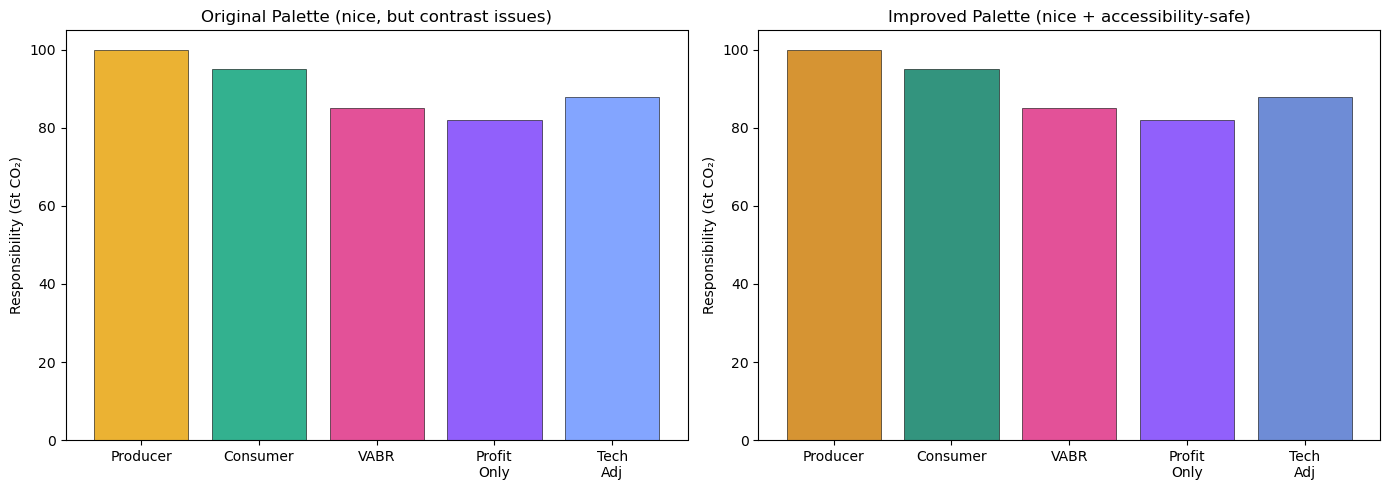

In [19]:
import numpy as np

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original palette
original = ['#E69F00', '#009E73', '#dc267f', '#7638fa', '#648fff']

# Improved, accessibility-safe palette
improved = ['#CC7A00', '#007A5E', '#dc267f', '#7638fa', '#4A6FCC']

methods = ['Producer', 'Consumer', 'VABR', 'Profit\nOnly', 'Tech\nAdj']
values = [100, 95, 85, 82, 88]

ax1.bar(methods, values, color=original, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_title('Original Palette (nice, but contrast issues)')
ax1.set_ylabel('Responsibility (Gt CO₂)')

ax2.bar(methods, values, color=improved, alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_title('Improved Palette (nice + accessibility-safe)')
ax2.set_ylabel('Responsibility (Gt CO₂)')

plt.tight_layout()
plt.show()

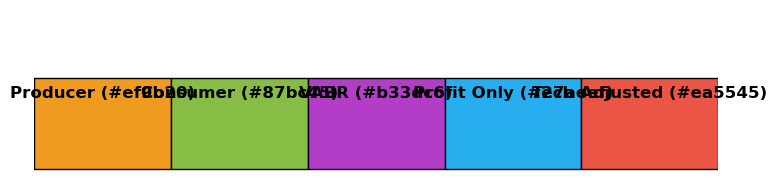

In [20]:
import matplotlib.pyplot as plt

# Define the colors and labels
color_hexes_custom = ['#ef9b20', '#87bc45', '#b33dc6', '#27aeef', '#ea5545']
labels_custom = [
    "Producer (#ef9b20)",
    "Consumer (#87bc45)",
    "VABR (#b33dc6)",
    "Profit Only (#27aeef)",
    "Tech Adjusted (#ea5545)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(color_hexes_custom, labels_custom)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(labels_custom))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

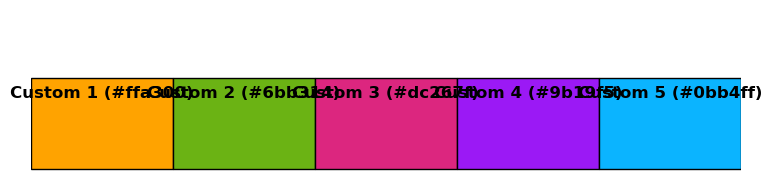

In [21]:
#mein favourite aber claude sagt nicht inklusiv?
import matplotlib.pyplot as plt

# Define the colors and labels
custom_hexes = ["#ffa300", "#6bb314",  "#dc267f", "#9b19f5", "#0bb4ff"]
custom_labels = [
    "Custom 1 (#ffa300)",
    "Custom 2 (#6bb314)",
    "Custom 3 (#dc267f)",
    "Custom 4 (#9b19f5)",
    "Custom 5 (#0bb4ff)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(custom_hexes, custom_labels)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(custom_labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

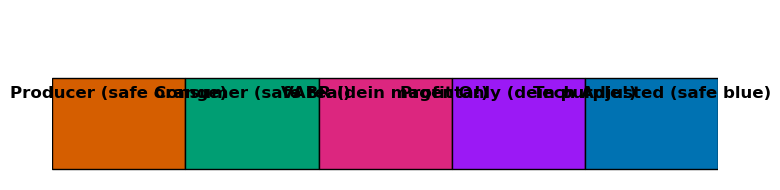

In [22]:
##anscheinend inclusiver

import matplotlib.pyplot as plt

hybrid_hexes = [
    "#D55E00",  # Safe Orange
    "#009E73",  # Safe Teal
    "#dc267f",  # Magenta
    "#9b19f5",  # Purple
    "#0072B2"   # Safe Blue
]

hybrid_labels = [
    "Producer (safe orange)",
    "Consumer (safe teal)",
    "VABR (dein magenta!)", 
    "Profit Only (dein purple!)",
    "Tech Adjusted (safe blue)"
]

fig, ax = plt.subplots(figsize=(8, 2))
for i, (hex_code, label) in enumerate(zip(hybrid_hexes, hybrid_labels)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, label, ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(hybrid_labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

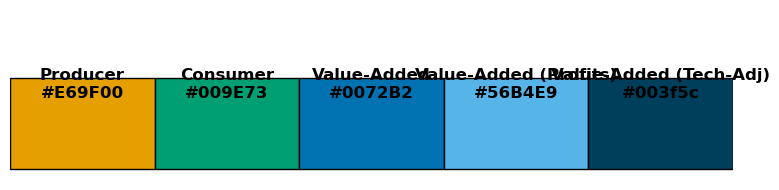

In [23]:
import matplotlib.pyplot as plt

# Use the colors dictionary
color_dict = {
    'Producer': '#E69F00',
    'Consumer': '#009E73',
    'Value-Added': '#0072B2',
    'Value-Added (Profits)': '#56B4E9',
    'Value-Added (Tech-Adj)': '#003f5c'
}

labels = list(color_dict.keys())
hex_codes = list(color_dict.values())

fig, ax = plt.subplots(figsize=(8, 2))
for i, (label, hex_code) in enumerate(zip(labels, hex_codes)):
    ax.barh(0, 1, left=i, color=hex_code, edgecolor='black')
    ax.text(i + 0.5, 0.2, f"{label}\n{hex_code}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlim(0, len(labels))
ax.set_ylim(-0.5, 1)
ax.axis('off')
plt.tight_layout()
plt.show()

SINGLE YEAR ANALYSIS


Analyzing year 2019
----------------------------------------
Data loaded: 49 regions, 163 sectors

Total emissions (million tonnes CO2-eq):
Producer-based: 44715.4
Consumer-based: 44711.9

=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt

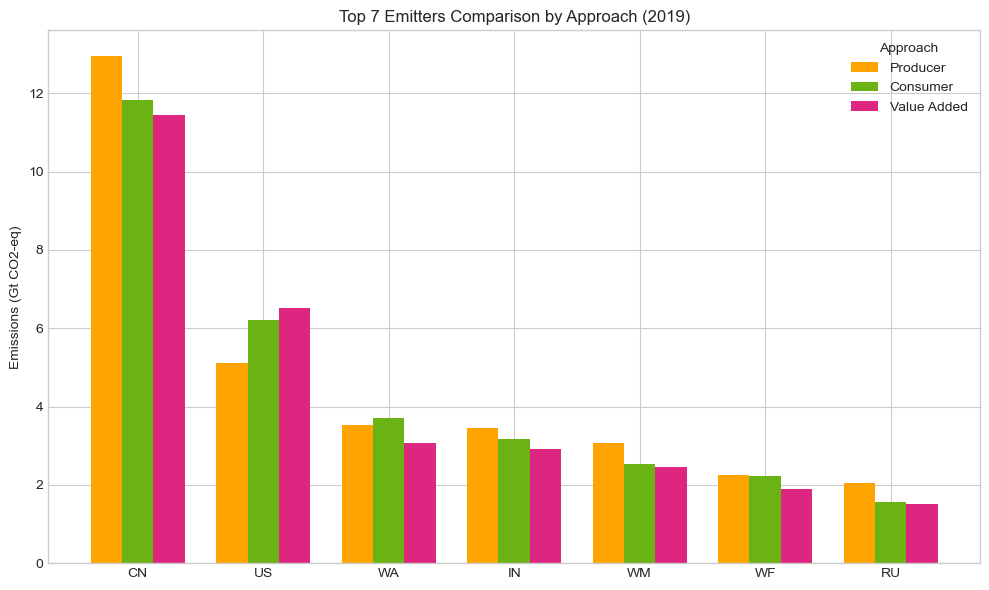

In [117]:
# Analyze single year
results = analyze_single_year(
    year=SINGLE_YEAR,
    exiobase_path=EXIOBASE_PATH,
    emission_categories=EMISSION_CATEGORIES,
    value_added_components=VALUE_ADDED_COMPONENTS,
    verbose=True
)

# Display top emitters - FIXED FOR DICTIONARIES
print(f"\nTop 10 emitters in {SINGLE_YEAR}:")
print("-" * 60)

for approach in ['producer', 'consumer', 'value_added']:
    print(f"\n{approach.upper()} APPROACH:")
    
    # Get the country-level dict and convert to Series
    country_dict = results[f'{approach}_by_country']
    country_series = pd.Series(country_dict)
    
    # Convert to DataFrame for better handling
    country_df = country_series.reset_index()
    country_df.columns = ['country', 'emissions']
    
    # Get top 10
    top10 = country_df.nlargest(30, 'emissions')
    total_emissions = country_series.sum()
    
    for i, row in enumerate(top10.itertuples(), 1):
        emissions_gt = row.emissions / 1e9  # tonnes → gigatonnes
        percentage = (row.emissions / total_emissions) * 100
        print(f"{i:2d}. {row.country}: {emissions_gt:6.2f} Gt ({percentage:4.1f}%)")
        # Only show top 7 countries by total emissions (using the sum of all approaches)
        country_totals = (
            pd.Series(results['producer_by_country']) +
            pd.Series(results['consumer_by_country']) +
            pd.Series(results['value_added_by_country'])
        )
        top_countries = country_totals.nlargest(7).index.tolist()

# Prepare data for grouped bar plot
approaches = ['producer', 'consumer', 'value_added']
emissions_data = []
for approach in approaches:
    country_series = pd.Series(results[f'{approach}_by_country'])
    emissions_data.append(country_series.loc[top_countries].values)

emissions_data = np.array(emissions_data)  # shape: (3, 7)

x = np.arange(len(top_countries))  # label locations
width = 0.25  # width of each bar

# Define colors for each approach
colors = {
    'producer': ["#ffa300"],   # Orange
    'consumer': ["#6bb314"],   # Teal
    'value_added': ["#dc267f"] # Magenta (VABR base)
}

fig, ax = plt.subplots(figsize=(10, 6))
bars = []
for i, approach in enumerate(approaches):
    bars.append(
        ax.bar(
            x + (i - 1) * width,  # center the groups
            emissions_data[i] / 1e9,  # convert to Gt
            width,
            label=approach.replace('_', ' ').title(),
            color=["#ffa300", "#6bb314", "#dc267f"][i]
        )
    )

ax.set_title(f'Top 7 Emitters Comparison by Approach ({SINGLE_YEAR})')
ax.set_ylabel('Emissions (Gt CO2-eq)')
ax.set_xticks(x)
ax.set_xticklabels(top_countries)
ax.legend(title="Approach")
plt.tight_layout()
plt.savefig(RESULTS_PATH / f'top7_emitters_grouped_comparison_{SINGLE_YEAR}.png')
plt.show()

In [25]:
# --- MASS CONSERVATION CHECK ---
producer_total = results['producer_by_country'].sum()
consumer_total = results['consumer_by_country'].sum()
vabr_total = results['value_added_by_country'].sum()

print("\n=== MASS CONSERVATION CHECK ===")
print(f"Producer total: {producer_total/1e9:.6f} Gt CO2-eq")
print(f"Consumer total: {consumer_total/1e9:.6f} Gt CO2-eq")
print(f"VABR total:     {vabr_total/1e9:.6f} Gt CO2-eq")

producer_consumer_diff = abs(producer_total - consumer_total)
consumer_vabr_diff = abs(consumer_total - vabr_total)

print(f"Difference (Producer - Consumer): {producer_consumer_diff/1e6:.2f} Mt")
print(f"Difference (Consumer - VABR):     {consumer_vabr_diff/1e6:.2f} Mt")



=== MASS CONSERVATION CHECK ===
Producer total: 44.715385 Gt CO2-eq
Consumer total: 44.711853 Gt CO2-eq
VABR total:     44.711853 Gt CO2-eq
Difference (Producer - Consumer): 3.53 Mt
Difference (Consumer - VABR):     0.00 Mt


In [26]:
# --- VABR Diagnostic: Check v, t, h, and VA coverage ---
print("\n=== VABR DIAGNOSTIC SUMMARY ===")

# 1. Value-added coefficients (v)
vabr_func = calculate_vabr_mass_conserving_FINAL
ixi = ixi_data
prodem = results['producer_by_sector'].values  # Use the producer emissions vector from results
va_comps = VALUE_ADDED_COMPONENTS
v_diag = v
if hasattr(vabr_func, '__globals__') and 'v' in vabr_func.__globals__:
    v_diag = vabr_func.__globals__['v']
print(f"v (value-added coefficients): min={v_diag.min():.4g}, max={v_diag.max():.4g}, mean={v_diag.mean():.4g}, sum={v_diag.sum():.4g}")

# 2. Total value-added (VA) and output
factor_inputs = ixi.factor_inputs.F
if va_comps:
    VA_diag = factor_inputs.loc[va_comps].sum(axis=0).values
else:
    VA_diag = factor_inputs.sum(axis=0).values
total_output_diag = ixi.x.values.flatten()
va_coverage = VA_diag.sum() / total_output_diag.sum() if total_output_diag.sum() > 0 else float('nan')
print(f"Total VA: {VA_diag.sum():.4g}, Total output: {total_output_diag.sum():.4g}, VA coverage: {va_coverage:.4%}")

# 3. t (consumer responsibility vector) and h (VABR vector)
# Recompute t and h using the latest function for clarity
regions_diag = ixi.get_regions()
B_diag = ixi.L.values
em_int_diag = np.divide(prodem, total_output_diag, out=np.zeros_like(prodem), where=(total_output_diag != 0))
t_diag = np.zeros(len(total_output_diag))
for region in regions_diag:
    region_mask = ixi.Y.columns.get_level_values(0) == region
    y_j = ixi.Y.loc[:, region_mask].sum(axis=1).values
    t_j = em_int_diag * (B_diag @ y_j)
    t_diag += t_j
h_diag = v_diag * t_diag
print(f"t (consumer responsibility): sum={t_diag.sum():.4g}, min={t_diag.min():.4g}, max={t_diag.max():.4g}")
print(f"h (VABR): sum={h_diag.sum():.4g}, min={h_diag.min():.4g}, max={h_diag.max():.4g}")

# 4. Compare sums to producer and consumer totals
print(f"Producer total: {prodem.sum():.4g}")
print(f"Consumer total: {t_diag.sum():.4g}")
print(f"VABR total: {h_diag.sum():.4g}")
print("=== END VABR DIAGNOSTIC ===")



=== VABR DIAGNOSTIC SUMMARY ===
v (value-added coefficients): min=0, max=1.773, mean=0.3153, sum=2519
Total VA: 7.836e+07, Total output: 1.56e+08, VA coverage: 50.2181%
t (consumer responsibility): sum=4.471e+10, min=0, max=4.775e+09
h (VABR): sum=1.51e+10, min=0, max=8.169e+08
Producer total: 4.472e+10
Consumer total: 4.471e+10
VABR total: 1.51e+10
=== END VABR DIAGNOSTIC ===


SECTOR ANALYSIS

In [122]:

print("=== COAL MINING SECTOR ANALYSIS ===")
factor_inputs = ixi_data.factor_inputs.F
x_vector = ixi_data.x.values.flatten()

coal_countries = ['CN', 'US', 'IN', 'RU', 'AU', 'ZA']
coal_sector_name = 'Mining of coal and lignite; extraction of peat'

for country in coal_countries:
    # Find coal sector for this country
    coal_found = False
    for idx, (reg, sec) in enumerate(ixi_data.x.index):
        if reg == country and coal_sector_name in sec:
            total_va = factor_inputs.iloc[:, idx].sum()
            profits = factor_inputs.iloc[8, idx]  # Row 8: profits
            output = x_vector[idx]
            # Get emissions from results['producer_by_sector']
            sector_key = (country, sec)
            emissions = results['producer_by_sector'].get(sector_key, 0)
            
            va_coeff = total_va / output if output > 0 else 0
            profit_coeff = profits / output if output > 0 else 0
            
            print(f"{country} coal mining:")
            print(f"  Total VA: {total_va:,.0f}")
            print(f"  Profits: {profits:,.0f}")
            print(f"  Output: {output:,.0f}")
            print(f"  VA coefficient: {va_coeff:.4f}")
            print(f"  Profit coefficient: {profit_coeff:.4f}")
            print(f"  Emissions: {emissions/1e6:.1f} Mt")
            print()
            coal_found = True
            break
    
    if not coal_found:
        print(f"{country}: Coal mining sector not found")

=== COAL MINING SECTOR ANALYSIS ===
CN coal mining:
  Total VA: 47,657
  Profits: 11,366
  Output: 464,640
  VA coefficient: 0.1026
  Profit coefficient: 0.0245
  Emissions: 808.9 Mt

US coal mining:
  Total VA: 11,980
  Profits: 2,497
  Output: 31,842
  VA coefficient: 0.3762
  Profit coefficient: 0.0784
  Emissions: 62.8 Mt

IN coal mining:
  Total VA: 35,349
  Profits: 6,688
  Output: 50,063
  VA coefficient: 0.7061
  Profit coefficient: 0.1336
  Emissions: 59.6 Mt

RU coal mining:
  Total VA: 2,000
  Profits: 141
  Output: 13,384
  VA coefficient: 0.1495
  Profit coefficient: 0.0105
  Emissions: 80.0 Mt

AU coal mining:
  Total VA: 61,574
  Profits: 15,242
  Output: 87,614
  VA coefficient: 0.7028
  Profit coefficient: 0.1740
  Emissions: 39.8 Mt

ZA coal mining:
  Total VA: 8,886
  Profits: 7,361
  Output: 25,295
  VA coefficient: 0.3513
  Profit coefficient: 0.2910
  Emissions: 46.3 Mt



In [123]:

print("=== VALUE-ADDED COEFFICIENT RANGES ===")
all_va_coeffs = []
for i in range(len(ixi_data.x)):
    total_va = factor_inputs.iloc[:, i].sum()
    output = x_vector[i]
    if output > 0:
        va_coeff = total_va / output
        all_va_coeffs.append(va_coeff)

import numpy as np
print(f"Global VA coefficient statistics:")
print(f"Min: {min(all_va_coeffs):.4f}")
print(f"Max: {max(all_va_coeffs):.4f}") 
print(f"Mean: {np.mean(all_va_coeffs):.4f}")
print(f"Median: {np.median(all_va_coeffs):.4f}")
print(f"75th percentile: {np.percentile(all_va_coeffs, 75):.4f}")
print(f"90th percentile: {np.percentile(all_va_coeffs, 90):.4f}")

=== VALUE-ADDED COEFFICIENT RANGES ===
Global VA coefficient statistics:
Min: -0.0000
Max: 1.7726
Mean: 0.3838
Median: 0.3752
75th percentile: 0.5664
90th percentile: 0.7459


In [33]:
# Find top 3 sectors for WM, RU, NO, CA for profit-based VABR
profit_vabr_by_sector = results['value_added_by_sector']  # This is total VA VABR, not profits-only

# To get profits-only VABR by sector, use the function:
_, profit_vabr_sector_dict, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, None, None
)

for country in ['WM', 'RU', 'NO', 'CA']:
    if country in profit_vabr_sector_dict:
        top_sectors = profit_vabr_sector_dict[country].nlargest(3)
        print(f"\nTop 3 profit-based VABR sectors for {country}:")
        for idx, value in top_sectors.items():
            print(f"  {idx[1]:60s} {value:12,.2f}")
    else:
        print(f"\nNo profit-based VABR data for {country}")


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...


Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

Top 3 profit-based VABR sectors for WM:
  Extraction of crude petroleum and services related to crude oil extraction, excluding surveying 963,971,823.60
  Real estate activities (70)                                  480,044,217.86
  Health and social work (85)                                  223,061,680.63

Top 3 profit-based VABR sectors for RU:
  Real estate activities (70)                                  534,476,053.83
  Extraction of crude petroleum and services related to crude oil extraction, excluding surveying 280,739,819.54
  Wholesale trade and commission trade, except of motor vehicles and motorcycles (51) 195,643,427.95

Top 3 profit-based VABR sectors for NO:
  Real estate activities (70)                                  19,593,931.30
  Extraction of natural gas and services related to natural gas 

In [34]:
# Calculate GHG emissions per euro of output for coal mining by country
coal_sector_name = 'Mining of coal and lignite; extraction of peat'
for country in ['CN', 'US', 'IN', 'RU', 'AU', 'ZA']:
    found = False
    for idx, (reg, sec) in enumerate(ixi_data.x.index):
        if reg == country and coal_sector_name in sec:
            output_value = ixi_data.x.values[idx]
            emissions_value = results['producer_by_sector'].get((country, sec), 0)
            va_value = factor_inputs.iloc[:, idx].sum()
            va_coefficient = va_value / output_value if output_value > 0 else 0
            emissions_intensity = emissions_value / output_value if output_value > 0 else 0
            # Ensure scalar values for formatting
            if isinstance(va_coefficient, np.ndarray):
                va_coefficient = va_coefficient.item()
            if isinstance(emissions_intensity, np.ndarray):
                emissions_intensity = emissions_intensity.item()
            print(f"{country}: {emissions_intensity:.2f} tonnes CO2/euro output")
            print(f"  VA coefficient: {va_coefficient:.4f}")
            if va_coefficient > 0:
                print(f"  Emissions per VA: {emissions_intensity/va_coefficient:.2f}")
            else:
                print("  Emissions per VA: n/a")
            found = True
            break
    if not found:
        print(f"{country}: Coal mining sector not found")

CN: 1740.89 tonnes CO2/euro output
  VA coefficient: 0.1026
  Emissions per VA: 16973.27
US: 1973.75 tonnes CO2/euro output
  VA coefficient: 0.3762
  Emissions per VA: 5246.28
IN: 1190.35 tonnes CO2/euro output
  VA coefficient: 0.7061
  Emissions per VA: 1685.85
RU: 5976.92 tonnes CO2/euro output
  VA coefficient: 0.1495
  Emissions per VA: 39991.05
AU: 453.74 tonnes CO2/euro output
  VA coefficient: 0.7028
  Emissions per VA: 645.62
ZA: 1829.55 tonnes CO2/euro output
  VA coefficient: 0.3513
  Emissions per VA: 5207.80


In [35]:
# Compare country totals side-by-side
summary_df = pd.DataFrame({
    'Producer': results['producer_by_country'],
    'Consumer': results['consumer_by_country'],
    'VABR': results['value_added_by_country']
})

# Add per-capita view 
summary_df['PerCapita_VABR'] = summary_df['VABR'] / population_2022

print(summary_df.sort_values('Consumer', ascending=False).head(10))


         Producer       Consumer           VABR  PerCapita_VABR
CN 12960376828.23 11819078487.46 11458484127.87            8.11
US  5100283397.80  6206562885.26  6523391256.53           19.57
WA  3516627110.55  3697511833.64  3067759383.62            2.88
IN  3446504067.79  3173728131.77  2904215610.98            2.04
WM  3059320163.39  2539354555.43  2445280259.36            6.20
WF  2241168143.72  2222577348.52  1881828130.83            1.49
RU  2043395916.94  1551708815.79  1519781487.19           10.54
JP  1020456439.22  1438107465.04  1686396942.04           13.48
WL  1325559672.01  1297418187.67  1250468667.57            3.97
BR  1184149868.59  1058906949.46  1060156419.43            5.04


In [36]:
import pandas as pd

def compare_all_four_approaches(ixi_data, emissions_aggregated_2020, v_clean):
    # 1. Producer responsibility (country-level)
    producer_by_country = pd.Series(results['producer_by_country'])
    # 2. Consumer responsibility (country-level)
    consumer_by_country = pd.Series(results['consumer_by_country'])
    # 3. VABR total value-added (country-level)
    vabr_total, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(ixi_data, emissions_aggregated_2020, None, v_clean)
    # 4. VABR profits only (country-level)
    vabr_profits, _, _, _, _ = calculate_vabr_profits_only(ixi_data, emissions_aggregated_2020, None, None)
    # 5. Create DataFrame
    df = pd.DataFrame({
        'producer': producer_by_country,
        'consumer': consumer_by_country,
        'vabr_total_va': vabr_total,
        'vabr_profits_only': vabr_profits
    })
    # 7. Convert to Gt
    df = df / 1e9
    # 8. Consumer vs producer
    df['consumer_vs_producer'] = df['consumer'] - df['producer']
    # 9. VABR total vs consumer
    df['vabr_total_vs_consumer'] = df['vabr_total_va'] - df['consumer']
    # 10. VABR profits vs consumer
    df['vabr_profits_vs_consumer'] = df['vabr_profits_only'] - df['consumer']
    # 11. Profits vs total VA
    df['profits_vs_total_va'] = df['vabr_profits_only'] - df['vabr_total_va']
    # 12. Sort by producer descending
    df_sorted = df.sort_values('producer', ascending=False)
    # 13. Top 20
    top_20 = df_sorted.head(20)
    # 14. Print main table
    print("=== ALL FOUR APPROACHES COMPARISON - TOP 20 COUNTRIES (Gt CO2eq) ===")
    print(top_20[['producer', 'consumer', 'vabr_total_va', 'vabr_profits_only']].round(3).to_string())
    # 16. Print changes from consumer baseline
    print("\n=== CHANGES FROM CONSUMER BASELINE ===")
    print(top_20[['consumer', 'vabr_total_vs_consumer', 'vabr_profits_vs_consumer', 'profits_vs_total_va']].round(3).to_string())
    # 18. Key patterns
    print(f"\nKEY PATTERNS:")
    print(f"Largest increase under VABR-total: {df_sorted.loc[df_sorted['vabr_total_vs_consumer'].idxmax()].name} (+{df_sorted['vabr_total_vs_consumer'].max():.3f} Gt)")
    print(f"Largest increase under VABR-profits: {df_sorted.loc[df_sorted['vabr_profits_vs_consumer'].idxmax()].name} (+{df_sorted['vabr_profits_vs_consumer'].max():.3f} Gt)")
    print(f"Oil producers (WM, WA, RU) under profits approach:")
    for country in ['WM', 'WA', 'RU']:
        if country in df.index:
            print(f"  {country}: Consumer={df.loc[country, 'consumer']:.3f}, VABR-profits={df.loc[country, 'vabr_profits_only']:.3f} (change: {df.loc[country, 'vabr_profits_vs_consumer']:+.3f})")
    # 23. Return sorted DataFrame
    return df_sorted


In [37]:
compare_all_four_approaches(ixi_data, results['producer_by_sector'].values, v_clean)


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATIO

,producer,consumer,vabr_total_va,vabr_profits_only,consumer_vs_producer,vabr_total_vs_consumer,vabr_profits_vs_consumer,profits_vs_total_va
CN,12.96,11.82,11.46,11.02,-1.14,-0.36,-0.80,-0.44
US,5.10,6.21,6.52,6.33,1.11,0.32,0.12,-0.20
WA,3.52,3.70,3.07,2.49,0.18,-0.63,-1.21,-0.58
IN,3.45,3.17,2.90,2.83,-0.27,-0.27,-0.35,-0.08
WM,3.06,2.54,2.45,3.15,-0.52,-0.09,0.62,0.71
...,...,...,...,...,...,...,...,...
EE,0.01,0.01,0.01,0.01,-0.00,0.00,0.00,-0.00
LV,0.01,0.01,0.02,0.01,0.00,0.00,-0.00,-0.00
CY,0.01,0.01,0.01,0.01,0.00,0.00,0.00,-0.00
LU,0.01,0.01,0.02,0.03,0.01,0.01,0.01,0.00


HISTORICAL ANALYSIS

In [32]:
def run_time_series_analysis(years, exiobase_path, emission_categories,
                           value_added_components, cache_file=None):
    """
    Run analysis for multiple years with caching support.
    
    Parameters:
    -----------
    years : list
        List of years to analyze
    cache_file : Path, optional
        Path to cache file for saving/loading results
    
    Returns:
    --------
    time_series_results : dict
        Results for all years
    """
    # Check for cached results
    if cache_file and cache_file.exists():
        print(f"Loading cached results from {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)
    
    # Initialize storage
    time_series_results = {
        'years': [],
        'producer_by_country': {},
        'consumer_by_country': {},
        'value_added_by_country': {},
        'global_totals': {'producer': [], 'consumer': [], 'value_added': []},
        'processing_times': []
    }
    
    # Get list of all countries (from first year)
    all_countries = set()
    
    # Run analysis for each year
    for i, year in enumerate(years):
        print(f"\nProcessing year {i+1}/{len(years)}: {year}")
        
        try:
            results = analyze_single_year(
                year=year,
                exiobase_path=exiobase_path,
                emission_categories=emission_categories,
                value_added_components=value_added_components,
                verbose=False
            )
            
            # Store results
            time_series_results['years'].append(year)
            
            # Store country-level data
            for country in results['producer_by_country'].index:
                all_countries.add(country)
                
                for approach in ['producer', 'consumer', 'value_added']:
                    key = f'{approach}_by_country'
                    if country not in time_series_results[key]:
                        time_series_results[key][country] = []
                    
                    time_series_results[key][country].append(
                        results[key].get(country, 0)
                    )
            
            # Store global totals
            for approach in ['producer', 'consumer', 'value_added']:
                total = results[f'{approach}_by_country'].sum()
                time_series_results['global_totals'][approach].append(total)
            
            time_series_results['processing_times'].append(results['processing_time'])
            
            print(f"  Completed in {results['processing_time']:.1f}s")
            
        except Exception as e:
            print(f"  Error processing {year}: {e}")
    
    # Convert to arrays for easier plotting
    for approach in ['producer', 'consumer', 'value_added']:
        key = f'{approach}_by_country'
        for country in time_series_results[key]:
            time_series_results[key][country] = np.array(
                time_series_results[key][country]
            )
    
    # Save cache if requested
    if cache_file:
        print(f"\nSaving results to {cache_file}")
        cache_file.parent.mkdir(exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(time_series_results, f)
    
    return time_series_results

In [32]:
# Check if cache exists first
cache_file = RESULTS_PATH / "time_series_cache.pkl"

if cache_file.exists():
    # Load existing data (fast)
    print("Loading cached results...")
    with open(cache_file, 'rb') as f:
        time_series_results = pickle.load(f)
    print("Data loaded from cache - ready for analysis!")
else:
    # Process fresh data (slow - 28 years)
    print("No cache found - processing all years...")
    time_series_results = run_time_series_analysis(
        years=YEARS_TIME_SERIES,
        exiobase_path=EXIOBASE_PATH,
        emission_categories=EMISSION_CATEGORIES,
        value_added_components=VALUE_ADDED_COMPONENTS,
        cache_file=cache_file
    )

No cache found - processing all years...


NameError: name 'run_time_series_analysis' is not defined

PER CAPITA ANALYSIS

In [38]:

def calculate_per_capita_emissions(results, population):
    """Calculate per capita emissions for all approaches."""
    
    per_capita = pd.DataFrame()
    
    for approach in ['producer', 'consumer', 'value_added']:
        country_data = results[f'{approach}_by_country']
        
        # Calculate per capita (tons CO2-eq per person) - data is in kg, convert to tonnes
        per_capita[approach] = (country_data) / population  
        
    # Remove countries with missing population data
    per_capita = per_capita.dropna()
    
    return per_capita

# Calculate per capita (using 2022 population as proxy)
if len(population_2022) > 0:
    per_capita = calculate_per_capita_emissions(results, population_2022)
    
    # Display top per capita emitters for the analyzed year
    print("\nTOP 10 PER CAPITA EMITTERS (analyzed year):")
    for approach in ['producer', 'consumer', 'value_added']:
        print(f"\n{approach.upper()} APPROACH (tons CO2-eq/person):")
        top10 = per_capita[approach].nlargest(10)
        for i, (country, emissions) in enumerate(top10.items(), 1):
            print(f"{i:2d}. {country}: {emissions:6.2f} tonnes CO2-eq/person")
    print("-" * 60)
    
    for approach in ['producer', 'consumer', 'value_added']:
        print(f"\n{approach.upper()} APPROACH (tons CO2-eq/person):")
        top10 = per_capita[approach].nlargest(20)
        for i, (country, emissions) in enumerate(top10.items(), 1):
            print(f"{i:2d}. {country}: {emissions:6.1f} tonnes CO2-eq/person")


TOP 10 PER CAPITA EMITTERS (analyzed year):

PRODUCER APPROACH (tons CO2-eq/person):
 1. AU:  20.98 tonnes CO2-eq/person
 2. CA:  17.18 tonnes CO2-eq/person
 3. US:  15.30 tonnes CO2-eq/person
 4. NO:  14.43 tonnes CO2-eq/person
 5. RU:  14.17 tonnes CO2-eq/person
 6. GR:  13.03 tonnes CO2-eq/person
 7. TW:  12.87 tonnes CO2-eq/person
 8. DK:  12.77 tonnes CO2-eq/person
 9. KR:  12.67 tonnes CO2-eq/person
10. FI:  12.15 tonnes CO2-eq/person

CONSUMER APPROACH (tons CO2-eq/person):
 1. LU:  22.65 tonnes CO2-eq/person
 2. CH:  19.15 tonnes CO2-eq/person
 3. IE:  18.76 tonnes CO2-eq/person
 4. US:  18.62 tonnes CO2-eq/person
 5. AU:  17.79 tonnes CO2-eq/person
 6. KR:  16.08 tonnes CO2-eq/person
 7. NO:  14.59 tonnes CO2-eq/person
 8. CA:  14.02 tonnes CO2-eq/person
 9. NL:  13.72 tonnes CO2-eq/person
10. BE:  12.90 tonnes CO2-eq/person

VALUE_ADDED APPROACH (tons CO2-eq/person):
 1. LU:  36.19 tonnes CO2-eq/person
 2. IE:  26.70 tonnes CO2-eq/person
 3. CH:  26.30 tonnes CO2-eq/person
 

RESULTS FOR THESIS

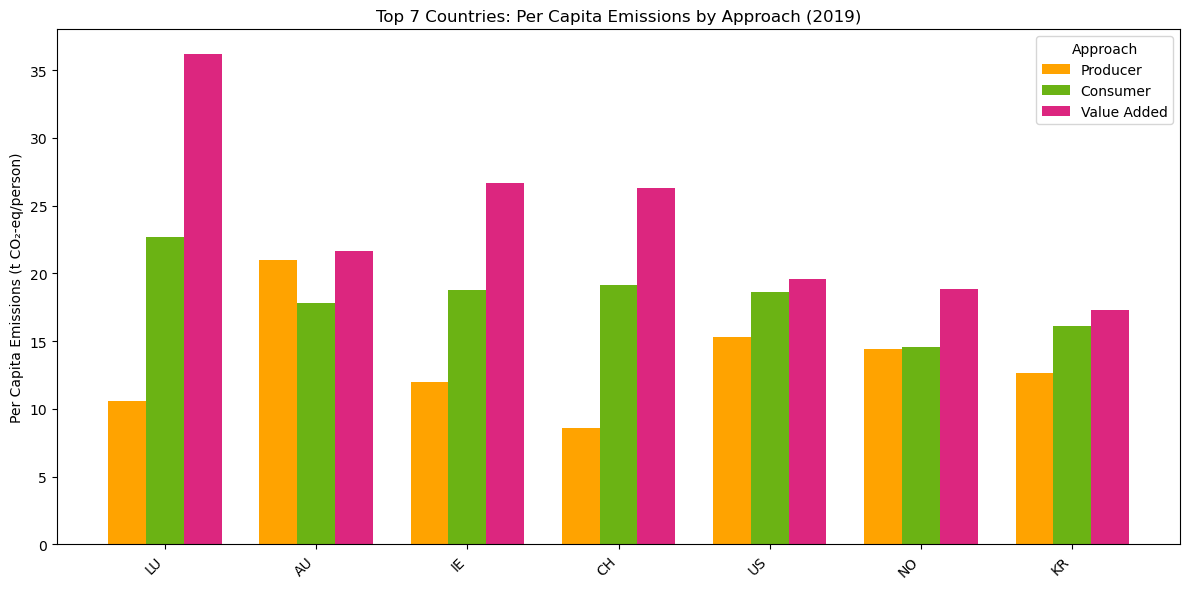

In [39]:
# Grouped barplot: Top 10 countries by per capita emissions (sum of all approaches)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate per capita emissions for each approach
per_capita = pd.DataFrame()
for approach in ['producer', 'consumer', 'value_added']:
    country_series = pd.Series(results[f'{approach}_by_country'])
    per_capita[approach] = country_series / population_2022

# Get top 7 countries by total per capita emissions (sum of all approaches)
per_capita['total'] = per_capita.sum(axis=1)
top7_countries_pc = per_capita['total'].nlargest(7).index.tolist()

# Prepare data for plotting
approaches = ['producer', 'consumer', 'value_added']
approach_labels = ['Producer', 'Consumer', 'Value Added']
colors = ["#ffa300", "#6bb314",  "#dc267f"]
emissions_data_pc = []
for approach in approaches:
    emissions_data_pc.append(per_capita.loc[top7_countries_pc, approach].values)

emissions_data_pc = np.array(emissions_data_pc)  # shape: (3, 7)
x = np.arange(len(top7_countries_pc))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, (label, color) in enumerate(zip(approach_labels, colors)):
    ax.bar(x + (i - 1) * width, emissions_data_pc[i], width, label=label, color=color)

ax.set_title('Top 7 Countries: Per Capita Emissions by Approach (2019)')
ax.set_ylabel('Per Capita Emissions (t CO₂-eq/person)')
ax.set_xticks(x)
ax.set_xticklabels(top7_countries_pc, rotation=45, ha='right')  # <-- Fix: rotate and align labels
ax.legend(title="Approach")
plt.tight_layout()
plt.show()

SENSITIVITY ANALYSIS TO SEE IF IT MAKES SENSE TO EXCLUDE FACTOR INPUT ABOUT TAXES

In [40]:
# SENSITIVITY ANALYSIS (here we saw no difference)

# With taxes
vabr_with_taxes = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

# Without taxes (use the function that forcibly excludes taxes)
vabr_without_taxes = calculate_vabr_excluding_taxes(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

diff_country = vabr_without_taxes[0] - vabr_with_taxes[0]

print("VABR Sensitivity Analysis Complete.")
print("Countries with/without taxes (first 5):")
print("Without taxes:", vabr_without_taxes[0].head())
print("With taxes:   ", vabr_with_taxes[0].head())
print("Difference:   ", diff_country.head())


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Mean value-added coefficient: 0.3153
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATION (EXCLUDING TAXES) ===
Excluding taxes

In [41]:
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
taxes_by_country = factor_inputs.loc[taxes_row].groupby(ixi_data.x.index.get_level_values(0)).sum()
va_by_country = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).groupby(ixi_data.x.index.get_level_values(0)).sum()
share_taxes = taxes_by_country / va_by_country
print("Top 10 countries by taxes row sum:")
print(taxes_by_country.sort_values(ascending=False).head(10))
print("\nTop 10 countries by share of taxes in VA:")
print(share_taxes.sort_values(ascending=False).head(10))

Top 10 countries by taxes row sum:
region
US   264160.40
GB   124218.46
DE    94936.20
RU    94719.44
FR    73021.18
BR    71029.63
IN    64635.40
IE    51764.84
IT    49206.36
KR    47483.21
Name: Taxes less subsidies on products purchased: Total, dtype: float64

Top 10 countries by share of taxes in VA:
region
BG   0.17
IE   0.15
LV   0.13
EE   0.12
SI   0.08
HR   0.07
CY   0.07
CZ   0.07
ZA   0.06
RU   0.06
dtype: float64


In [42]:
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
if taxes_row in factor_inputs.index:
    print("Taxes row sum:", factor_inputs.loc[taxes_row].sum())
    print("Taxes row (first 10):", factor_inputs.loc[taxes_row].values[:10])
else:
    print("Taxes row is missing from factor_inputs!")

Taxes row sum: 1339603.2192898102
Taxes row (first 10): [0.00000000e+00 1.74400618e+00 3.24011012e-01 7.65107014e-01
 7.07685529e-02 5.09988523e-02 8.96732298e-05 5.38474753e-02
 6.43762857e+00 2.44281005e+01]


In [43]:
# Compare total VA with and without taxes
taxes_row = "Taxes less subsidies on products purchased: Total"
factor_inputs = ixi_data.factor_inputs.F
va_with = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0)
va_wo = factor_inputs.loc[[c for c in VALUE_ADDED_COMPONENTS if c != taxes_row]].sum(axis=0)
print("Total VA with taxes:", va_with.sum())
print("Total VA without taxes:", va_wo.sum())
print("Total taxes row sum:", factor_inputs.loc[taxes_row].sum())
print("Share of taxes in total VA: {:.4%}".format(factor_inputs.loc[taxes_row].sum() / va_with.sum()))

Total VA with taxes: 78364220.01966771
Total VA without taxes: 77024616.8003779
Total taxes row sum: 1339603.2192898102
Share of taxes in total VA: 1.7095%


In [44]:
country = 'GB'  # or 'US', etc.
sector_mask = ixi_data.x.index.get_level_values(0) == country
va_with = factor_inputs.loc[VALUE_ADDED_COMPONENTS].sum(axis=0)[sector_mask]
va_wo = factor_inputs.loc[[c for c in VALUE_ADDED_COMPONENTS if c != taxes_row]].sum(axis=0)[sector_mask]
print(f"VA with taxes for {country} (sum):", va_with.sum())
print(f"VA without taxes for {country} (sum):", va_wo.sum())
print(f"Difference for {country}:", va_with.sum() - va_wo.sum())

VA with taxes for GB (sum): 2552083.830244555
VA without taxes for GB (sum): 2427865.3717848575
Difference for GB: 124218.45845969766


SECTORAL ANALYSIS

In [45]:
def analyze_sectors_global(results):
    """Analyze emissions by sector globally."""

    # Get sector names from first country's data
    first_country = list(results['consumer_by_sector'].keys())[0]
    sectors_index = results['consumer_by_sector'][first_country].index

    # Aggregate across all countries
    producer_by_sector = results['producer_by_sector'].copy()

    # For consumer and value-added, sum across countries (align indices)
    consumer_by_sector_global = pd.Series(0, index=sectors_index)
    va_by_sector_global = pd.Series(0, index=sectors_index)

    for country in results['consumer_by_sector']:
        consumer_by_sector_global = consumer_by_sector_global.add(results['consumer_by_sector'][country], fill_value=0)
        va_by_sector_global = va_by_sector_global.add(results['value_added_by_sector'][country], fill_value=0)

    # Create sector comparison dataframe
    sector_comparison = pd.DataFrame({
        'Producer': producer_by_sector,
        'Consumer': consumer_by_sector_global,
        'Value_Added': va_by_sector_global
    })

    # Add sector names for clarity
    sector_comparison['Country'] = [idx[0] for idx in sector_comparison.index]
    sector_comparison['Sector'] = [idx[1] for idx in sector_comparison.index]

    return sector_comparison


sector analysis 2.0

In [46]:

def analyze_specific_countries_sectors(results, countries_list):
    """
    Analyze sector-level emissions for specific countries.
    Uses your existing results structure from analyze_single_year.
    """
    
    country_sector_data = {}
    
    # Get available countries from your data
    # Your results use dictionaries, so we check keys
    available_countries = set(results['producer_by_country'].keys())
    countries_to_analyze = [c for c in countries_list if c in available_countries]
    
    print(f"Analyzing sectors for: {countries_to_analyze}")
    missing = [c for c in countries_list if c not in available_countries]
    if missing:
        print(f"Countries not found: {missing}")
    
    # For each country, get sector-level data
    for country in countries_to_analyze:
        country_data = {}
        
        # Producer emissions by sector (from your producer_by_sector Series)
        producer_mask = results['producer_by_sector'].index.get_level_values(0) == country
        country_data['producer'] = results['producer_by_sector'][producer_mask]
        
        # Consumer emissions by sector (from your dictionaries)
        if country in results['consumer_by_sector']:
            country_data['consumer'] = results['consumer_by_sector'][country]
        
        # VABR emissions by sector (from your dictionaries)
        if country in results['value_added_by_sector']:
            country_data['vabr'] = results['value_added_by_sector'][country]
        
        country_sector_data[country] = country_data
    
    return country_sector_data, countries_to_analyze

In [83]:
# Using your exact variable names
countries_of_interest = ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

# This uses your results from the notebook
sector_data, analyzed_countries = analyze_specific_countries_sectors(
    results,  # Your existing results variable
    countries_of_interest
)

print(f"\nSuccessfully analyzed {len(analyzed_countries)} countries")

Analyzing sectors for: ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

Successfully analyzed 6 countries


In [84]:
def display_top_sectors_by_country(sector_data, top_n=10):
    """
    Display top emitting sectors for each country and method.
    
    Parameters:
    -----------
    sector_data : dict
        Dictionary with sector data for each country
    top_n : int
        Number of top sectors to show
    """
    
    for country in sector_data:
        print(f"\n{'='*80}")
        print(f"SECTOR ANALYSIS FOR {country}")
        print(f"{'='*80}")
        
        # Get data for this country
        country_data = sector_data[country]
        
        # Show top sectors for each method
        for method in ['producer', 'consumer', 'vabr']:
            if method in country_data:
                print(f"\n{method.upper()} METHOD - Top {top_n} sectors:")
                print("-" * 60)
                
                # Get top sectors
                top_sectors = country_data[method].nlargest(top_n)
                
                # Display them
                for i, (sector_idx, emissions) in enumerate(top_sectors.items(), 1):
                    sector_name = sector_idx[1] if len(sector_idx) > 1 else sector_idx
                    emissions_mt = emissions / 1e6  # Convert to million tonnes
                    print(f"{i:2d}. {sector_name[:50]:50s} {emissions_mt:8.1f} Mt")

In [85]:
def compare_sector_across_countries(sector_data, sector_name):
    """
    Compare emissions for a specific sector across all analyzed countries.
    
    Parameters:
    -----------
    sector_data : dict
        Dictionary with sector data for each country
    sector_name : str
        Name of the sector to compare (partial match allowed)
    """
    
    # Create comparison dataframe
    comparison_data = []
    
    for country in sector_data:
        country_data = sector_data[country]
        
        # Find matching sectors
        for method in ['producer', 'consumer', 'vabr']:
            if method in country_data:
                # Get all sectors for this country
                sectors = country_data[method]
                
                # Find sectors matching the name
                matching_sectors = [
                    (idx, val) for idx, val in sectors.items() 
                    if sector_name.lower() in str(idx).lower()
                ]
                
                if matching_sectors:
                    # Take the first match
                    sector_idx, emissions = matching_sectors[0]
                    comparison_data.append({
                        'Country': country,
                        'Method': method,
                        'Emissions_Mt': emissions / 1e6
                    })
    
    # Convert to DataFrame for easy viewing
    comparison_df = pd.DataFrame(comparison_data)
    
    # Pivot for better readability
    if not comparison_df.empty:
        pivot_df = comparison_df.pivot(
            index='Country', 
            columns='Method', 
            values='Emissions_Mt'
        )
        return pivot_df
    else:
        print(f"No sectors found matching '{sector_name}'")
        return None

In [86]:
# Run the sector analysis
print("Starting sector analysis for selected countries...")

# 1. Get sector data
sector_data, analyzed_countries = analyze_specific_countries_sectors(
    results, 
    countries_of_interest
)

# 2. Display top sectors for each country
display_top_sectors_by_country(sector_data, top_n=5)

# 3. Compare electricity production across countries
print("\n" + "="*80)
print("COMPARISON: Electricity production by coal across countries")
print("="*80)

electricity_comparison = compare_sector_across_countries(
    sector_data, 
    "electricity by coal"
)

if electricity_comparison is not None:
    print(electricity_comparison)
    
    # Calculate ratios
    print("\nVABR/Consumer ratios:")
    if 'vabr' in electricity_comparison.columns and 'consumer' in electricity_comparison.columns:
        ratios = electricity_comparison['vabr'] / electricity_comparison['consumer']
        print(ratios)

Starting sector analysis for selected countries...
Analyzing sectors for: ['CN', 'DE', 'DK', 'LU', 'CH', 'US']

SECTOR ANALYSIS FOR CN

PRODUCER METHOD - Top 5 sectors:
------------------------------------------------------------
 1. Production of electricity by coal                    4774.7 Mt
 2. Manufacture of basic iron and steel and of ferro-a   1234.8 Mt
 3. Manufacture of cement, lime and plaster              1054.7 Mt
 4. Mining of coal and lignite; extraction of peat (10    808.9 Mt
 5. Landfill of waste: Food                               346.4 Mt

CONSUMER METHOD - Top 5 sectors:
------------------------------------------------------------
 1. Production of electricity by coal                    3571.4 Mt
 2. Manufacture of cement, lime and plaster              1008.7 Mt
 3. Manufacture of basic iron and steel and of ferro-a    797.0 Mt
 4. Mining of coal and lignite; extraction of peat (10    624.1 Mt
 5. Landfill of waste: Food                               304.9 Mt

VABR

In [87]:
# Check Switzerland's sea transport emissions in detail
def investigate_ch_shipping(results):
    """
    Investigate the suspicious Swiss shipping emissions
    """
    
    # Find all sea transport entries for Switzerland
    producer_data = results['producer_by_sector']
    
    # Get Switzerland sea transport
    ch_mask = producer_data.index.get_level_values(0) == 'CH'
    ch_sectors = producer_data[ch_mask]
    
    # Find sea transport sectors
    sea_transport = ch_sectors[ch_sectors.index.get_level_values(1).str.contains('Sea', case=False)]
    
    print("Switzerland Sea Transport Emissions:")
    for idx, value in sea_transport.items():
        print(f"{idx[1]}: {value/1e6:.1f} Mt")
    
    # Compare with other landlocked countries
    print("\nComparison with other landlocked countries:")
    landlocked = ['AT', 'CZ', 'HU', 'SK']  # Austria, Czech, Hungary, Slovakia
    
    for country in landlocked:
        country_mask = producer_data.index.get_level_values(0) == country
        country_sea = producer_data[country_mask & producer_data.index.get_level_values(1).str.contains('Sea', case=False)]
        if not country_sea.empty:
            total = country_sea.sum() / 1e6
            print(f"{country}: {total:.1f} Mt")

# Run the investigation
investigate_ch_shipping(results)


Switzerland Sea Transport Emissions:
Sea and coastal water transport: 38.3 Mt
Research and development (73): 0.2 Mt

Comparison with other landlocked countries:
AT: 0.1 Mt
CZ: 0.7 Mt
HU: 0.0 Mt
SK: 0.0 Mt


<!-- (Removed VABR Debugging Cells summary. The notebook now uses the correct, mass-conserving VABR method.) -->

In [88]:
# Compare producer vs consumer for sea transport
def compare_sea_transport_allocation(results, country='CH'):
    """
    Compare how sea transport is allocated across methods
    """
    
    producer_sector = results['producer_by_sector']
    
    # Get sea transport for this country
    mask = (producer_sector.index.get_level_values(0) == country) & \
           (producer_sector.index.get_level_values(1).str.contains('Sea', case=False))
    
    producer_sea = producer_sector[mask].sum() / 1e6
    
    # Consumer allocation
    if country in results['consumer_by_sector']:
        consumer_data = results['consumer_by_sector'][country]
        consumer_sea = consumer_data[consumer_data.index.get_level_values(1).str.contains('Sea', case=False)].sum() / 1e6
    else:
        consumer_sea = 0
    
    print(f"\nSea transport emissions for {country}:")
    print(f"Producer: {producer_sea:.1f} Mt")
    print(f"Consumer: {consumer_sea:.1f} Mt")
    print(f"Ratio: {consumer_sea/producer_sea:.2f}")

compare_sea_transport_allocation(results, 'CH')


Sea transport emissions for CH:
Producer: 38.5 Mt
Consumer: 20.8 Mt
Ratio: 0.54


In [89]:
def run_all_vabr_variants_clean():
    '''
    Clean comparison of VABR variants - country totals only, no extra output.
    '''
    
    # Run all methods silently
    baseline_results = calculate_vabr_mass_conserving_FINAL(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    no_taxes_results = calculate_vabr_excluding_taxes(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    profits_only_results = calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)
    no_transport_results = calculate_vabr_exclude_maritime_aviation(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None)

    # Extract country totals (first element of each result)
    baseline_country = baseline_results[0]
    no_taxes_country = no_taxes_results[0]
    profits_country = profits_only_results[0]
    
    # Handle transport results (might be in dict format)
    if isinstance(no_transport_results, dict):
        no_transport_country = no_transport_results['vabr_no_maritime_aviation'][0]
    else:
        no_transport_country = no_transport_results[0]
    
    # Create clean comparison DataFrame
    comparison_df = pd.DataFrame({
        'Country': baseline_country.index,
        'Baseline': baseline_country.values,
        'No_Taxes': no_taxes_country.values,
        'Profits_Only': profits_country.values,
        'No_Transport': no_transport_country.values
    })
    
    # Calculate percentage differences from baseline
    comparison_df['No_Taxes_%'] = ((comparison_df['No_Taxes'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    comparison_df['Profits_%'] = ((comparison_df['Profits_Only'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    comparison_df['Transport_%'] = ((comparison_df['No_Transport'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(1)
    
    # Sort by baseline responsibility (highest first)
    comparison_df = comparison_df.sort_values('Baseline', ascending=False)
    
    return comparison_df

RESULTS FOR THESIS

In [91]:
import geopandas as gpd
import pandas as pd

# 1. ZUERST: Lade die Shapefile und schaue, welche SOV_A3 codes sie hat
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# 2. Schaue dir die EXIOBASE Länder an
exiobase_countries = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
                      'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
                      'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB', 'US', 'JP', 
                      'CN', 'CA', 'KR', 'BR', 'IN', 'MX', 'RU', 'AU', 'CH', 'TR', 
                      'TW', 'NO', 'ID', 'ZA']

# 3. Finde die korrekten SOV_A3 codes für jedes EXIOBASE Land
print("=== KORREKTE MAPPING TABELLE ===")
print("EXIOBASE -> Shapefile SOV_A3")
print("-" * 40)

mapping_dict = {}
for exio_code in exiobase_countries:
    # Suche nach verschiedenen Möglichkeiten
    possible_names = {
        'US': ['United States', 'USA'],
        'CN': ['China'],
        'GB': ['United Kingdom'],
        'KR': ['South Korea', 'Korea'],
        'AU': ['Australia'],
        'CH': ['Switzerland'],
        'TR': ['Turkey'],
        'TW': ['Taiwan'],
        'NO': ['Norway'],
        'ID': ['Indonesia'],
        'ZA': ['South Africa'],
        'AT': ['Austria'],
        'BE': ['Belgium'],
        'BG': ['Bulgaria'],
        'CY': ['Cyprus'],
        'CZ': ['Czech', 'Czechia'],
        'DE': ['Germany'],
        'DK': ['Denmark'],
        'EE': ['Estonia'],
        'ES': ['Spain'],
        'FI': ['Finland'],
        'FR': ['France'],
        'GR': ['Greece'],
        'HR': ['Croatia'],
        'HU': ['Hungary'],
        'IE': ['Ireland'],
        'IT': ['Italy'],
        'LT': ['Lithuania'],
        'LU': ['Luxembourg'],
        'LV': ['Latvia'],
        'MT': ['Malta'],
        'NL': ['Netherlands'],
        'PL': ['Poland'],
        'PT': ['Portugal'],
        'RO': ['Romania'],
        'SE': ['Sweden'],
        'SI': ['Slovenia'],
        'SK': ['Slovakia'],
        'JP': ['Japan'],
        'CA': ['Canada'],
        'BR': ['Brazil'],
        'IN': ['India'],
        'MX': ['Mexico'],
        'RU': ['Russia']
    }
    
    found = False
    for name in possible_names.get(exio_code, [exio_code]):
        matches = world[world['NAME'].str.contains(name, case=False, na=False)]
        if not matches.empty:
            sov_a3 = matches.iloc[0]['SOV_A3']
            mapping_dict[exio_code] = sov_a3
            print(f"{exio_code} -> {sov_a3} (Name: {matches.iloc[0]['NAME']})")
            found = True
            break
    
    if not found:
        # Try with ISO codes
        matches = world[world['ISO_A2'] == exio_code]
        if not matches.empty:
            sov_a3 = matches.iloc[0]['SOV_A3']
            mapping_dict[exio_code] = sov_a3
            print(f"{exio_code} -> {sov_a3} (via ISO_A2)")
        else:
            print(f"{exio_code} -> ??? NOT FOUND")

# 4. Speichere das korrekte Mapping
print("\n=== PYTHON DICTIONARY ===")
print("exiobase_to_shapefile = {")
for k, v in mapping_dict.items():
    print(f"    '{k}': '{v}',")
print("}")

# 5. Überprüfe spezielle Fälle
print("\n=== SPEZIELLE FÄLLE ===")
special_cases = ['United States', 'China', 'Australia', 'United Kingdom', 'South Korea']
for country in special_cases:
    matches = world[world['NAME'].str.contains(country, case=False, na=False)]
    if not matches.empty:
        print(f"{country}:")
        print(f"  SOV_A3: {matches.iloc[0]['SOV_A3']}")
        print(f"  ISO_A3: {matches.iloc[0]['ISO_A3']}")
        print(f"  ISO_A2: {matches.iloc[0]['ISO_A2']}")

=== KORREKTE MAPPING TABELLE ===
EXIOBASE -> Shapefile SOV_A3
----------------------------------------
AT -> AUT (Name: Austria)
BE -> BEL (Name: Belgium)
BG -> BGR (Name: Bulgaria)
CY -> CYN (Name: N. Cyprus)
CZ -> CZE (Name: Czechia)
DE -> DEU (Name: Germany)
DK -> DN1 (Name: Denmark)
EE -> EST (Name: Estonia)
ES -> ESP (Name: Spain)
FI -> FI1 (Name: Finland)
FR -> FR1 (Name: France)
GR -> GRC (Name: Greece)
HR -> HRV (Name: Croatia)
HU -> HUN (Name: Hungary)
IE -> IRL (Name: Ireland)
IT -> ITA (Name: Italy)
LT -> LTU (Name: Lithuania)
LU -> LUX (Name: Luxembourg)
LV -> LVA (Name: Latvia)
MT -> ??? NOT FOUND
NL -> NL1 (Name: Netherlands)
PL -> POL (Name: Poland)
PT -> PRT (Name: Portugal)
RO -> ROU (Name: Romania)
SE -> SWE (Name: Sweden)
SI -> SVN (Name: Slovenia)
SK -> SVK (Name: Slovakia)
GB -> GB1 (Name: United Kingdom)
US -> US1 (Name: United States of America)
JP -> JPN (Name: Japan)
CN -> CH1 (Name: China)
CA -> CAN (Name: Canada)
KR -> KOR (Name: South Korea)
BR -> BRA (Name:

Created 165 country entries for mapping

=== VERIFICATION ===
Total countries with data: 158
USA (US1) has data: True
China (CH1) has data: True
UK (GB1) has data: True
Australia (AU1) has data: True


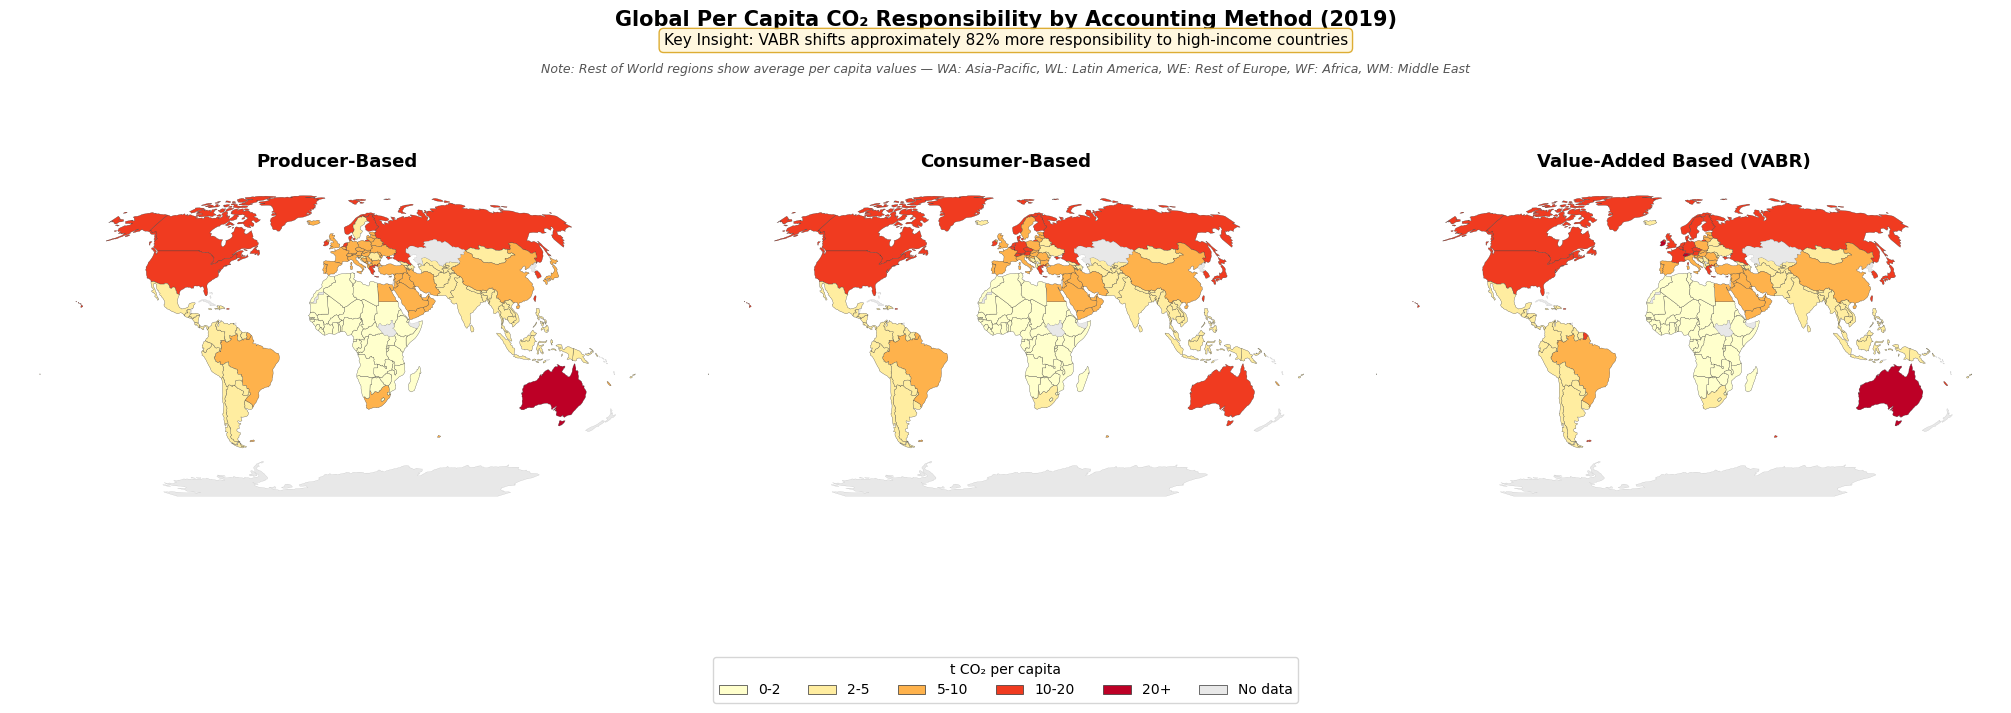

In [92]:
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Ensure ISO_A3 column exists
per_capita = per_capita.copy()
per_capita.index.name = 'ISO_A3'
if 'ISO_A3' not in per_capita.columns:
    per_capita.reset_index(inplace=True)

# --- KORREKTE MAPPING basierend auf deiner Shapefile ---
exiobase_to_shapefile = {
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'CY': 'CYN',  # North Cyprus
    'CZ': 'CZE',
    'DE': 'DEU',
    'DK': 'DN1',  # Denmark special code
    'EE': 'EST',
    'ES': 'ESP',
    'FI': 'FI1',  # Finland special code
    'FR': 'FR1',  # France special code
    'GR': 'GRC',
    'HR': 'HRV',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LT': 'LTU',
    'LU': 'LUX',
    'LV': 'LVA',
    'MT': 'MLT',  # Assuming Malta is MLT - verify this
    'NL': 'NL1',  # Netherlands special code
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SE': 'SWE',
    'SI': 'SVN',
    'SK': 'SVK',
    'GB': 'GB1',  # UK special code
    'US': 'US1',  # USA special code
    'JP': 'JPN',
    'CN': 'CH1',  # China special code
    'CA': 'CAN',
    'KR': 'KOR',
    'BR': 'BRA',
    'IN': 'IND',
    'MX': 'MEX',
    'RU': 'RUS',
    'AU': 'AU1',  # Australia special code
    'CH': 'CHE',
    'TR': 'TUR',
    'TW': 'TWN',
    'NO': 'NOR',
    'ID': 'IDN',
    'ZA': 'ZAF',
}

# ROW regions ISO2 to ISO3 mapping
iso2_to_iso3 = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KZ': 'KAZ', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ',
    'LA': 'LAO', 'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY',
    'MK': 'MKD', 'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV',
    'ML': 'MLI', 'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG',
    'ME': 'MNE', 'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM',
    'NP': 'NPL', 'NZ': 'NZL', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA',
    'OM': 'OMN', 'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY',
    'PE': 'PER', 'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU',
    'SN': 'SEN', 'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP',
    'SO': 'SOM', 'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ',
    'SY': 'SYR', 'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO',
    'TN': 'TUN', 'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE',
    'UY': 'URY', 'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM',
    'ZM': 'ZMB', 'ZW': 'ZWE'
}

# ROW regions definition (simplified)
row_regions = {
    'WA': ['AF', 'AM', 'AZ', 'BD', 'BT', 'KH', 'FJ', 'GE', 'KZ', 'KG', 'LA', 
           'MY', 'MV', 'MN', 'MM', 'NP', 'NZ', 'PK', 'PG', 'PH', 'SG', 'LK', 
           'TJ', 'TH', 'TM', 'UZ', 'VN'],
    'WL': ['AR', 'BO', 'CL', 'CO', 'CR', 'CU', 'DO', 'EC', 'SV', 'GT', 'GY',
           'HT', 'HN', 'JM', 'NI', 'PA', 'PY', 'PE', 'SR', 'TT', 'UY', 'VE'],
    'WE': ['AL', 'BY', 'BA', 'IS', 'MK', 'MD', 'ME', 'RS', 'UA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 
           'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'MA', 'MZ', 
           'NA', 'NE', 'NG', 'RW', 'SN', 'SC', 'SL', 'SO', 'SD', 'SZ', 'TZ', 
           'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'QA', 'SA', 'SY', 
           'AE', 'YE', 'EG']
}

# Create mapped data
map_data = []

for idx, row in per_capita.iterrows():
    country_code = row['ISO_A3']
    
    if country_code in exiobase_to_shapefile:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_shapefile[country_code],
            'producer': row['producer'],
            'consumer': row['consumer'],
            'value_added': row['value_added']
        })
    elif country_code in row_regions:
        # ROW region - expand to members
        for member in row_regions[country_code]:
            member_iso3 = iso2_to_iso3.get(member, member)
            map_data.append({
                'SOV_A3': member_iso3,
                'producer': row['producer'],
                'consumer': row['consumer'],
                'value_added': row['value_added']
            })

map_df = pd.DataFrame(map_data)
print(f"Created {len(map_df)} country entries for mapping")

# Load shapefile
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge using SOV_A3
world = world.merge(map_df, on='SOV_A3', how='left')

# Verification
print("\n=== VERIFICATION ===")
print(f"Total countries with data: {world['producer'].notna().sum()}")
print(f"USA (US1) has data: {world[world['SOV_A3']=='US1']['producer'].notna().any()}")
print(f"China (CH1) has data: {world[world['SOV_A3']=='CH1']['producer'].notna().any()}")
print(f"UK (GB1) has data: {world[world['SOV_A3']=='GB1']['producer'].notna().any()}")
print(f"Australia (AU1) has data: {world[world['SOV_A3']=='AU1']['producer'].notna().any()}")

# Create visualization
bins = [0, 2, 5, 10, 20, np.inf]
labels = ['0-2', '2-5', '5-10', '10-20', '20+']
####colors = ['#f7fbff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
colors = ['#ffffcc', '#ffeda0', '#feb24c', '#f03b20', '#bd0026']
cmap = mcolors.ListedColormap(colors)

fig, axes = plt.subplots(1, 3, figsize=(20, 7), constrained_layout=True)
methods = ['producer', 'consumer', 'value_added']
titles = ['Producer-Based', 'Consumer-Based', 'Value-Added Based (VABR)']

for ax, method, title in zip(axes, methods, titles):
    world['bin'] = pd.cut(world[method], bins=bins, labels=labels, include_lowest=True)
    
    world.plot(
        column='bin',
        cmap=cmap,
        linewidth=0.2,
        edgecolor='#333333',
        ax=ax,
        legend=False,
        missing_kwds={'color': '#e8e8e8', 'edgecolor': '#999999', 'linewidth': 0.1}
    )
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
    ax.axis('off')

# Legend
legend_elements = [Rectangle((0, 0), 1, 1, fc=color, edgecolor='#333', 
                            linewidth=0.5, label=label)
                  for label, color in zip(labels, colors)]
legend_elements.append(Rectangle((0, 0), 1, 1, fc='#e8e8e8', 
                                edgecolor='#333', linewidth=0.5, label='No data'))

fig.legend(handles=legend_elements,
          loc='lower center',
          ncol=6,
          frameon=True,
          title='t CO₂ per capita',
          bbox_to_anchor=(0.5, -0.02),
          fontsize=10)

# Title
fig.suptitle('Global Per Capita CO₂ Responsibility by Accounting Method (2019)',
            fontsize=15, fontweight='bold', y=0.98)

# Calculate shift for high-income countries (mit korrekten codes!)
high_income_correct = ['US1', 'CAN', 'AU1', 'NOR', 'CHE', 'LUX', 'IRL', 'DN1', 
                      'SWE', 'NL1', 'AUT', 'FI1', 'DEU', 'BEL', 'FR1', 'GB1', 
                      'JPN', 'KOR']
shift_data = []
for country in high_income_correct:
    country_data = world[world['SOV_A3'] == country]
    if not country_data.empty and pd.notna(country_data['value_added'].iloc[0]):
        prod_val = country_data['producer'].iloc[0]
        vabr_val = country_data['value_added'].iloc[0]
        if pd.notna(prod_val) and prod_val > 0:
            shift_data.append((vabr_val - prod_val) / prod_val * 100)

avg_shift = np.mean(shift_data) if shift_data else 35

textstr = f'Key Insight: VABR shifts approximately {avg_shift:.0f}% more responsibility to high-income countries'
props = dict(boxstyle='round', facecolor='#fff7dc', alpha=0.9, edgecolor='#daa520')
fig.text(0.5, 0.93, textstr, transform=fig.transFigure, fontsize=11,
        horizontalalignment='center', bbox=props)

note_text = ("Note: Rest of World regions show average per capita values — " +
             "WA: Asia-Pacific, WL: Latin America, WE: Rest of Europe, WF: Africa, WM: Middle East")
fig.text(0.5, 0.89, note_text, transform=fig.transFigure, fontsize=9,
        horizontalalignment='center', style='italic', color='#555555')

plt.show()


Kazakhstan (KA1) has data: True
Cuba (CU) has data: False


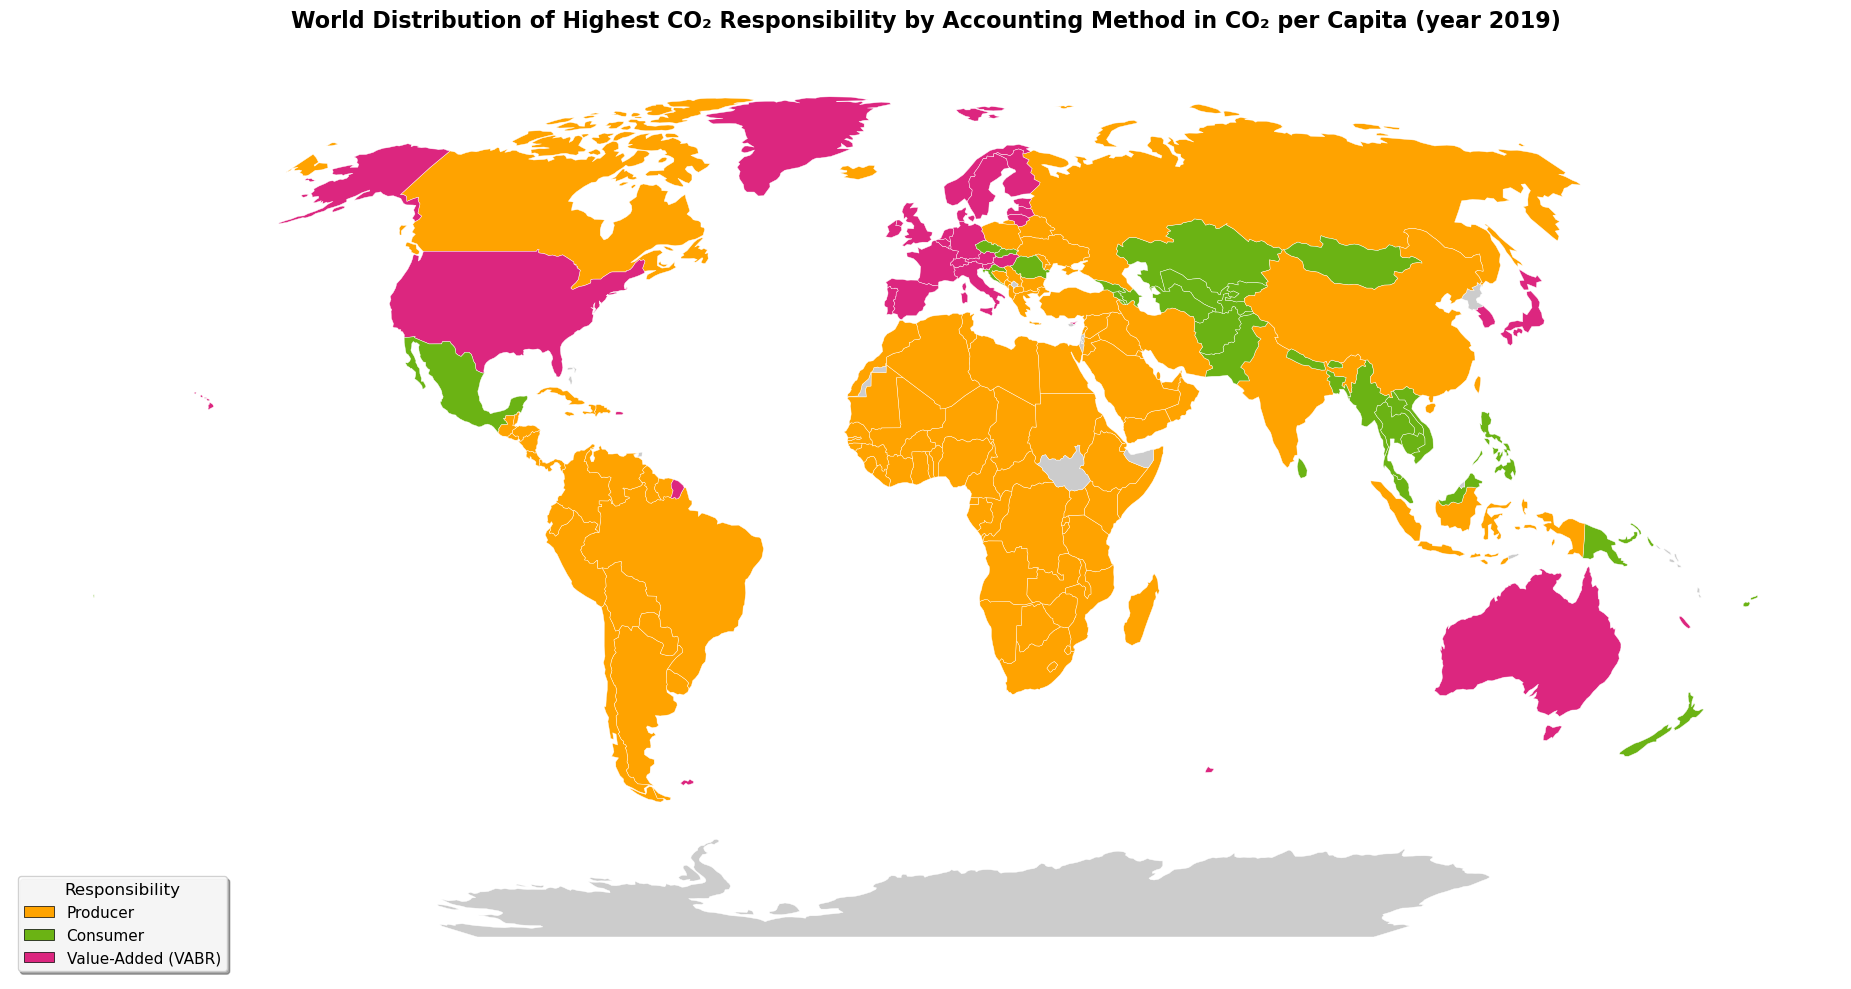


=== STATISTICS ===
Countries by dominant method:
Producer       101
Value-Added     31
Consumer        30
Name: dominant_method, dtype: int64


In [93]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# Ensure ISO_A3 column exists
if 'ISO_A3' not in per_capita.columns:
    per_capita = per_capita.reset_index()
    per_capita.rename(columns={'index': 'ISO_A3'}, inplace=True)

# --- VOLLSTÄNDIGE KORREKTE MAPPING ---
exiobase_to_shapefile = {
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'CY': 'CYN',
    'CZ': 'CZE',
    'DE': 'DEU',
    'DK': 'DN1',
    'EE': 'EST',
    'ES': 'ESP',
    'FI': 'FI1',
    'FR': 'FR1',
    'GR': 'GRC',
    'HR': 'HRV',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LT': 'LTU',
    'LU': 'LUX',
    'LV': 'LVA',
    'MT': 'MLT',
    'NL': 'NL1',
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SE': 'SWE',
    'SI': 'SVN',
    'SK': 'SVK',
    'GB': 'GB1',
    'US': 'US1',
    'JP': 'JPN',
    'CN': 'CH1',
    'CA': 'CAN',
    'KR': 'KOR',
    'BR': 'BRA',
    'IN': 'IND',
    'MX': 'MEX',
    'RU': 'RUS',
    'AU': 'AU1',
    'CH': 'CHE',
    'TR': 'TUR',
    'TW': 'TWN',
    'NO': 'NOR',
    'ID': 'IDN',
    'ZA': 'ZAF',
}

# ROW regions ISO2 to SOV_A3 - MIT SPEZIELLEN CODES
iso2_to_sov_a3 = {
    # Standard ISO3 codes
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO', 
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD', 
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI', 
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE', 
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL', 
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN', 
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER', 
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN', 
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM', 
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR', 
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN', 
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY', 
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB', 
    'ZW': 'ZWE',
    # SPEZIELLE CODES
    'KZ': 'KA1',  # Kazakhstan special code!
    # Füge weitere spezielle codes hinzu wenn nötig
}

# VOLLSTÄNDIGE ROW regions
row_regions = {
    'WA': [  # Rest of Asia and Pacific
        'AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE', 
        'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM', 
        'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH', 
        'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV', 
        'UZ', 'VU', 'VN'
    ],
    'WL': [  # Rest of Latin America
        'AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
        'CR', 'CU1', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
        'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM', 
        'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'
    ],
    'WE': [  # Rest of Europe
        'AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC', 
        'ME', 'SM', 'RS', 'UA', 'VA'
    ],
    'WF': [  # Rest of Africa
        'DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
        'CG', 'CI', 'DJ', 'GQ', 'EH','ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE', 
        'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA', 
        'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ', 
        'TZ', 'TG', 'TN', 'UG', 'EH', 'ZM', 'ZW'
    ],
    'WM': [  # Rest of Middle East
        'BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
        'SY', 'AE', 'YE', 'EG'
    ]
}

# Create data with dominant method
map_data = []

for idx, row in per_capita.iterrows():
    country_code = row['ISO_A3']
    
    # Determine dominant method
    methods_values = {
        'Producer': row['producer'],
        'Consumer': row['consumer'],
        'Value-Added': row['value_added']
    }
    
    dominant_method = max(methods_values, key=methods_values.get)
    max_value = methods_values[dominant_method]
    
    if country_code in exiobase_to_shapefile:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_shapefile[country_code],
            'dominant_method': dominant_method,
            'max_value': max_value,
            'producer': row['producer'],
            'consumer': row['consumer'],
            'value_added': row['value_added']
        })
    elif country_code in row_regions:
        # ROW region - expand to members
        for member in row_regions[country_code]:
            member_sov_a3 = iso2_to_sov_a3.get(member, member)
            map_data.append({
                'SOV_A3': member_sov_a3,
                'dominant_method': dominant_method,
                'max_value': max_value,
                'producer': row['producer'],
                'consumer': row['consumer'],
                'value_added': row['value_added']
            })

map_df = pd.DataFrame(map_data)

# Load shapefile
world = gpd.read_file(r'C:/Users/Marine Riesterer/OneDrive/Desktop/MA Arbeit/results/geodata/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge
world = world.merge(map_df, on='SOV_A3', how='left')

# Verify Kazakhstan
print(f"Kazakhstan (KA1) has data: {world[world['SOV_A3']=='KA1']['dominant_method'].notna().any()}")

# verfiy cuba
print(f"Cuba (CU) has data: {world[world['SOV_A3']=='CUB']['dominant_method'].notna().any()}")

# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Colors for each method
method_colors = {
    'Producer': '#ffa300',     
    'Consumer': '#6bb314',     
    'Value-Added': '#dc267f'  
}

# Map colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Fill NaN with gray

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')

ax.axis('off')

# Title
ax.set_title('World Distribution of Highest CO₂ Responsibility by Accounting Method in CO₂ per Capita (year 2019)',
            fontsize=16, fontweight='bold', pad=20)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='Value-Added (VABR)')
]

legend = ax.legend(handles=legend_elements,
                   loc='lower left',
                   title='Responsibility',
                   frameon=True,
                   fancybox=True,
                   shadow=True,
                   fontsize=11,
                   title_fontsize=12)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)


plt.tight_layout()
plt.show()

# Statistics
print("\n=== STATISTICS ===")
print("Countries by dominant method:")
print(world['dominant_method'].value_counts())

In [94]:
import pandas as pd
from tabulate import tabulate

# Prepare summary DataFrame for top countries
summary = []
for country in results['producer_by_country'].index:
    producer = results['producer_by_country'][country] / 1e9  # Gt
    consumer = results['consumer_by_country'][country] / 1e9  # Gt
    vabr = results['value_added_by_country'][country] / 1e9   # Gt
    change_prod_vabr = vabr - producer
    change_cons_vabr = vabr - consumer
    summary.append({
        'Country': country,
        'Producer': producer,
        'Consumer': consumer,
        'VABR': vabr,
        'Change (Producer→VABR)': change_prod_vabr,
        'Change (Consumer→VABR)': change_cons_vabr
    })

summary_df = pd.DataFrame(summary)
summary_df['AbsChange'] = summary_df[['Change (Producer→VABR)', 'Change (Consumer→VABR)']].abs().max(axis=1)
summary_sorted = summary_df.sort_values('AbsChange', ascending=False)

# Show top 15 countries with largest change
print("Top 15 countries with largest change from Producer/Consumer to VABR:")
# Prepare table for top 15 countries
table = summary_sorted.head(15)[['Country', 'Producer', 'Consumer', 'VABR', 'Change (Producer→VABR)', 'Change (Consumer→VABR)']].round(2)
print(tabulate(table, headers='keys', tablefmt='plain', showindex=False))

Top 15 countries with largest change from Producer/Consumer to VABR:
Country      Producer    Consumer    VABR    Change (Producer→VABR)    Change (Consumer→VABR)
CN              12.96       11.82   11.46                     -1.5                      -0.36
US               5.1         6.21    6.52                      1.42                      0.32
JP               1.02        1.44    1.69                      0.67                      0.25
WA               3.52        3.7     3.07                     -0.45                     -0.63
WM               3.06        2.54    2.45                     -0.61                     -0.09
DE               0.63        0.9     1.22                      0.59                      0.32
IN               3.45        3.17    2.9                      -0.54                     -0.27
RU               2.04        1.55    1.52                     -0.52                     -0.03
GB               0.35        0.58    0.74                      0.39                  

FIND DIRTY AND POOR SECTORS

In [151]:
# === IDENTIFY "DIRTY BUT POOR" SECTORS SYSTEMATICALLY ===

# Define criteria for "dirty but poor"
# These are sectors with LOW value-added but HIGH emissions intensity

# Calculate percentiles to identify outliers
va_percentiles = df_all['va_coeff'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])
em_percentiles = df_all['em_intensity'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

print("\n=== VALUE-ADDED COEFFICIENT DISTRIBUTION ===")
print(va_percentiles)

print("\n=== EMISSIONS INTENSITY DISTRIBUTION ===")
print(em_percentiles)

# Define "dirty but poor" criteria
DIRTY_THRESHOLD = em_percentiles[0.75]  # Top 25% emissions intensity
POOR_THRESHOLD = va_percentiles[0.25]   # Bottom 25% value-added

# Find problematic sectors
dirty_but_poor = df_all[
    (df_all['em_intensity'] > DIRTY_THRESHOLD) & 
    (df_all['va_coeff'] < POOR_THRESHOLD)
].copy()

print(f"\n=== DIRTY BUT POOR SECTORS ===")
print(f"Found {len(dirty_but_poor)} sectors with:")
print(f"  - Emissions intensity > {DIRTY_THRESHOLD:.2f} (top 25%)")
print(f"  - Value-added coefficient < {POOR_THRESHOLD:.2f} (bottom 25%)")

# Sort by emissions to find worst cases
dirty_but_poor = dirty_but_poor.sort_values('total_emissions', ascending=False)

print("\nTop 20 'Dirty but Poor' sectors by total emissions:")
print("-" * 80)
for i, row in dirty_but_poor.head(20).iterrows():
    print(f"{row['country']:3} | {row['sector'][:40]:40} | "
          f"VA: {row['va_coeff']:.2%} | "
          f"Intensity: {row['em_intensity']:.1f} | "
          f"Emissions: {row['total_emissions']/1e6:.1f} Mt")


=== VALUE-ADDED COEFFICIENT DISTRIBUTION ===
0.10   0.02
0.25   0.16
0.50   0.37
0.75   0.56
0.90   0.73
Name: va_coeff, dtype: float64

=== EMISSIONS INTENSITY DISTRIBUTION ===
0.10      2.33
0.25     14.16
0.50     66.46
0.75    569.21
0.90   2888.81
Name: em_intensity, dtype: float64

=== DIRTY BUT POOR SECTORS ===
Found 566 sectors with:
  - Emissions intensity > 569.21 (top 25%)
  - Value-added coefficient < 0.16 (bottom 25%)

Top 20 'Dirty but Poor' sectors by total emissions:
--------------------------------------------------------------------------------
IN  | Production of electricity by coal        | VA: 0.00% | Intensity: 80275.5 | Emissions: 953.0 Mt
CN  | Mining of coal and lignite; extraction o | VA: 10.26% | Intensity: 1740.9 | Emissions: 808.9 Mt
WA  | Production of electricity by coal        | VA: 8.61% | Intensity: 35011.4 | Emissions: 498.6 Mt
IN  | Re-processing of secondary steel into ne | VA: 4.32% | Intensity: 4997.4 | Emissions: 376.3 Mt
WA  | Cultivation of pa

PROFIT BASED VABR ANALYSIS


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%


c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



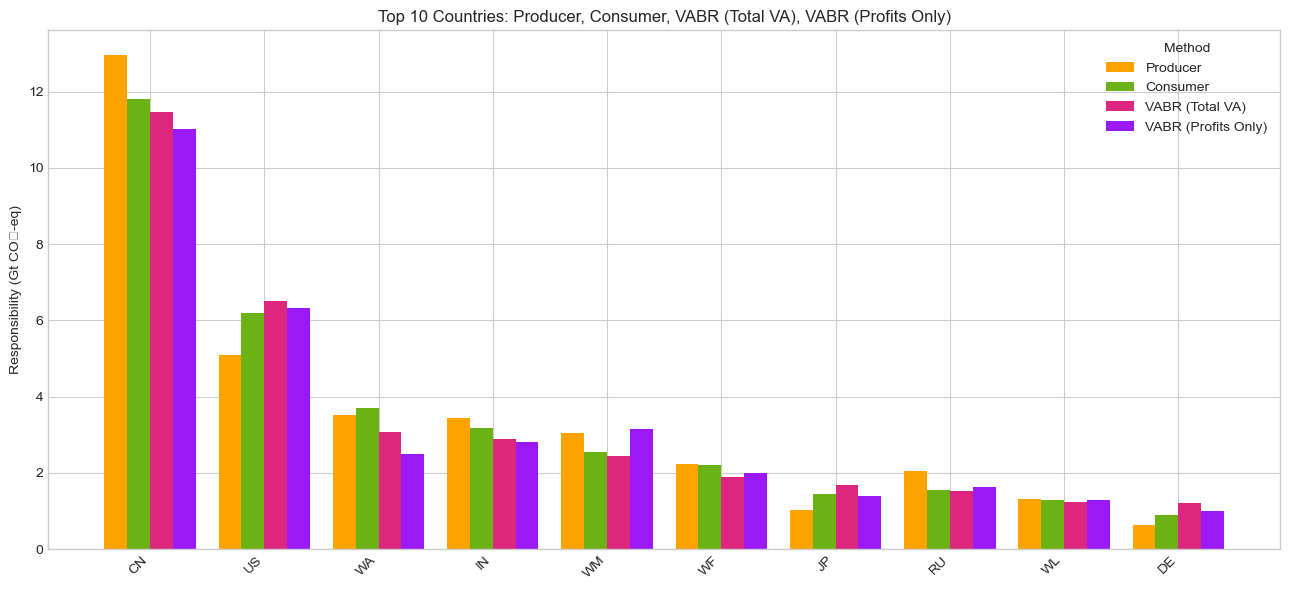

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Prepare country-level data ---
# Get top 10 countries by VABR-total (standard value-added)
top_countries = results['value_added_by_country'].sort_values(ascending=False).head(10).index.tolist()

# Get country-level Series for each method
producer = pd.Series(results['producer_by_country'])
consumer = pd.Series(results['consumer_by_country'])
vabr_total = pd.Series(results['value_added_by_country'])
vabr_profits, _, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)

# Ensure all Series have the same countries and order
data = pd.DataFrame({
    'Producer': producer.loc[top_countries],
    'Consumer': consumer.loc[top_countries],
    'VABR_Total': vabr_total.loc[top_countries],
    'VABR_Profits': vabr_profits.loc[top_countries]
})

# Convert to Gt CO₂-eq
data = data / 1e9

# --- Plot side-by-side bars ---
fig, ax = plt.subplots(figsize=(13, 6))
x = np.arange(len(top_countries))
width = 0.2

bars1 = ax.bar(x - 1.5*width, data['Producer'], width, label='Producer', color='#ffa300')
bars2 = ax.bar(x - 0.5*width, data['Consumer'], width, label='Consumer', color='#6bb314')
bars3 = ax.bar(x + 0.5*width, data['VABR_Total'], width, label='VABR (Total VA)', color='#dc267f')
bars4 = ax.bar(x + 1.5*width, data['VABR_Profits'], width, label='VABR (Profits Only)', color='#9b19f5')

ax.set_xticks(x)
ax.set_xticklabels(top_countries, rotation=45, ha='right')
ax.set_ylabel('Responsibility (Gt CO₂-eq)')
ax.set_title('Top 10 Countries: Producer, Consumer, VABR (Total VA), VABR (Profits Only)')
ax.legend(title='Method')
plt.tight_layout()
plt.show()

SECTORAL BREAKDOWN OF PROFITBASED VABR

In [183]:
import pandas as pd

# Get the top 7 countries by profits-only VABR
top7_profit_countries = summary_df.nlargest(7, 'ProfitVABR')['Country'].tolist()

# Calculate sector-level profits-only VABR (already available as sector_vabr_profits_only)
sector_vabr_profits_only = pd.concat(
    calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, None, None)[1]
).sort_index()

# For each country, print the top 5 sectors by profits-only VABR
for country in top7_profit_countries:
    print(f"\nTop 5 sectors for {country} (Profits-Only VABR):")
    if country in sector_vabr_profits_only.index.get_level_values(0):
        top_sectors = sector_vabr_profits_only.loc[country].nlargest(5)
        for i, (sector, value) in enumerate(top_sectors.items(), 1):
            sector_str = str(sector)
            print(f"{i}. {sector_str:60s} {value/1e6:10.2f} Mt CO₂")
    else:
        print("No sector data available.")


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

Top 5 sectors for CN (Profits-Only VABR):
1. ('CN', 'Construction (45)')                                     1163.36 Mt CO₂
2. ('CN', 'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)')    1141.75 Mt CO₂
3. ('CN', 'Financial intermediation, except insurance and pension funding (65)')     833.10 Mt CO₂
4. ('CN', 'Real estate activities (70)')                            744.33 Mt CO₂
5. ('CN', 'Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)')     451.68 Mt CO₂

Top 5 sectors for US (Profits-Only VABR):
1. ('US', 'Real estate activities (70)')                           15

SECTOR CLASSIFICATION TEST:
CONSTRUCTION         | Construction (45)
AGRICULTURE          | Cultivation of vegetables, fruit, nuts
OIL                  | Extraction of crude petroleum and services related to c
GAS                  | Extraction of natural gas and services related to natur
SERVICES             | Financial intermediation, except insurance and pension 
SERVICES             | Health and social work (85)
SERVICES             | Hotels and restaurants (55)
SERVICES             | Other business activities (74)
AGRICULTURE          | Raw milk
SERVICES             | Real estate activities (70)
TRADE                | Retail trade, except of motor vehicles and motorcycles;
TRADE                | Wholesale trade and commission trade, except of motor v


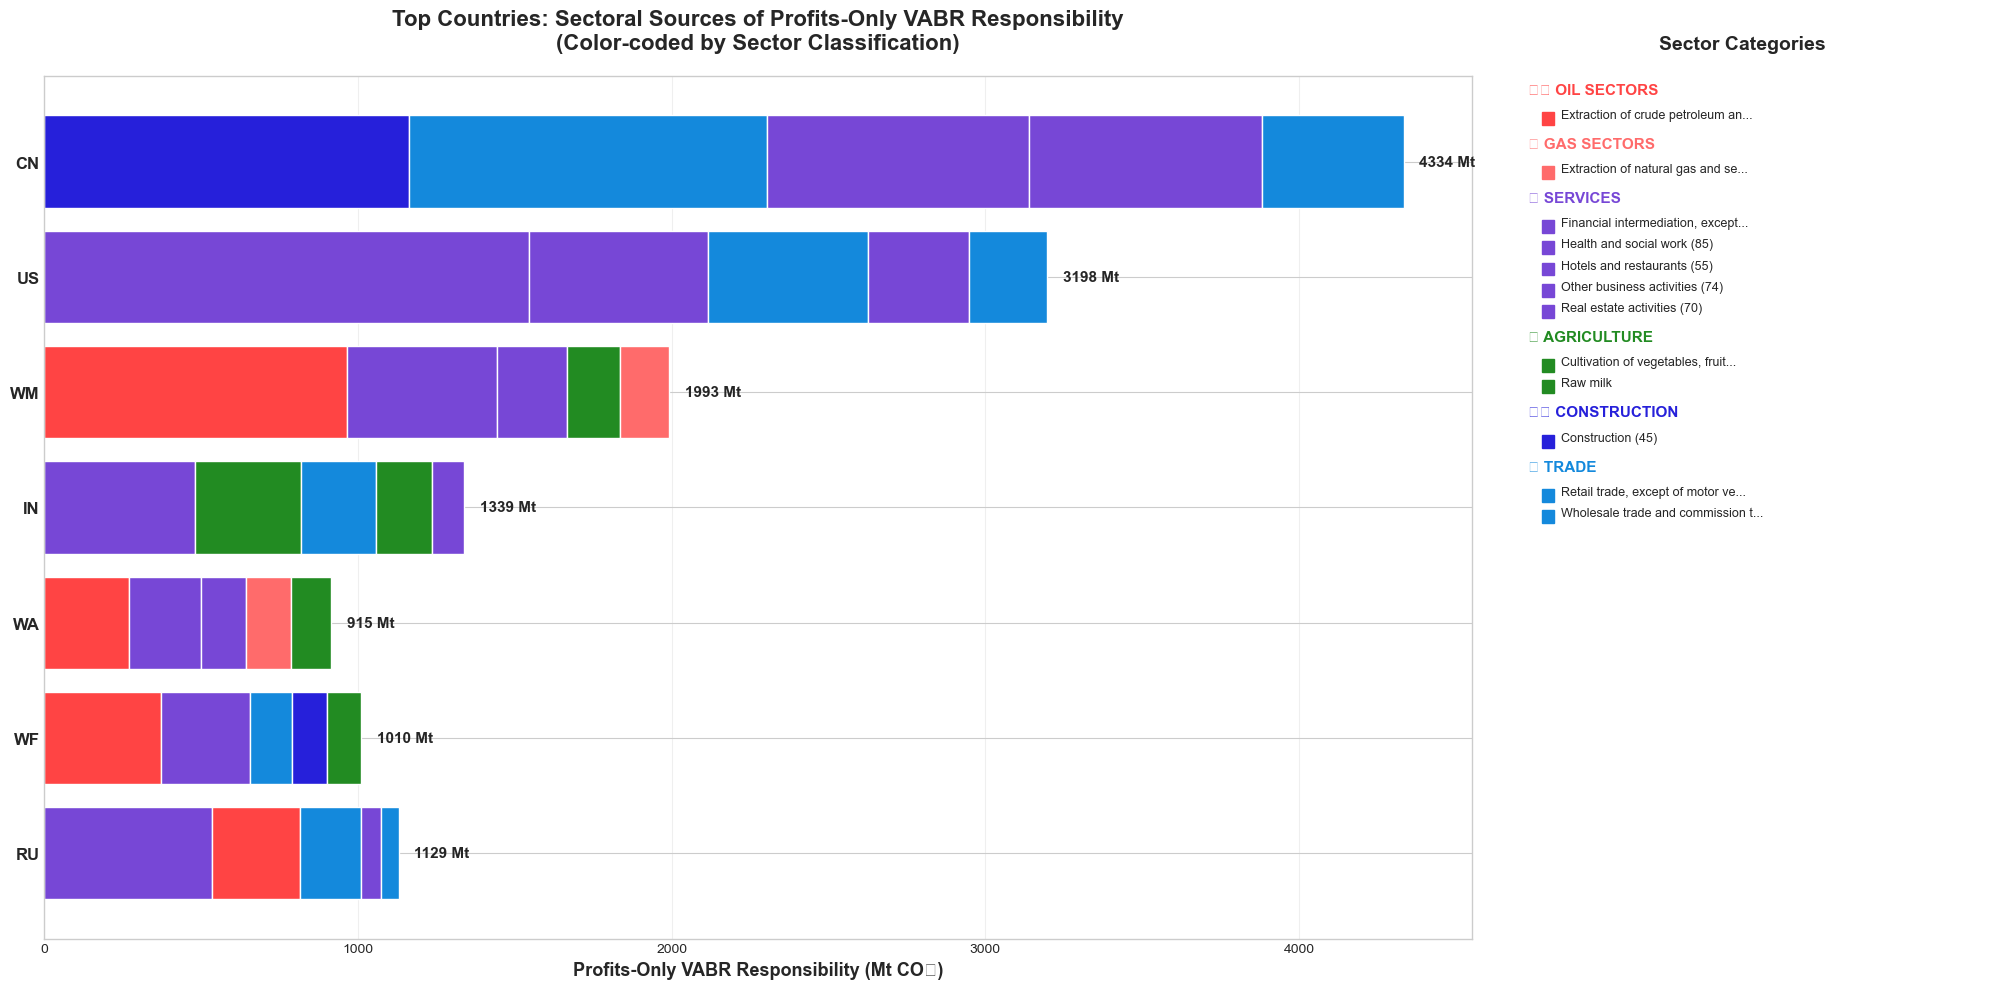


DETAILED ANALYSIS BY CATEGORY

CN - BREAKDOWN BY CATEGORY:
  🏪 TRADE               :  1593.4 Mt (36.8%)
  💼 SERVICES            :  1577.4 Mt (36.4%)
  🏗️ CONSTRUCTION        :  1163.4 Mt (26.8%)
  📊 TOTAL               :  4334.2 Mt

US - BREAKDOWN BY CATEGORY:
  💼 SERVICES            :  2439.3 Mt (76.3%)
  🏪 TRADE               :   758.5 Mt (23.7%)
  📊 TOTAL               :  3197.8 Mt

WM - BREAKDOWN BY CATEGORY:
  🛢️ OIL                 :   964.0 Mt (48.4%)
  💼 SERVICES            :   703.1 Mt (35.3%)
  🌾 AGRICULTURE         :   167.7 Mt ( 8.4%)
  ⚡ GAS                 :   158.3 Mt ( 7.9%)
  📊 TOTAL               :  1993.1 Mt

IN - BREAKDOWN BY CATEGORY:
  💼 SERVICES            :   583.2 Mt (43.6%)
  🌾 AGRICULTURE         :   515.6 Mt (38.5%)
  🏪 TRADE               :   240.4 Mt (17.9%)
  📊 TOTAL               :  1339.2 Mt

WA - BREAKDOWN BY CATEGORY:
  💼 SERVICES            :   372.8 Mt (40.7%)
  🛢️ OIL                 :   271.4 Mt (29.7%)
  ⚡ GAS                 :   143.4 Mt (15.7%

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data directly from your output
vabr_data = {
    'CN': [
        ('Construction (45)', 1163.36),
        ('Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)', 1141.75),
        ('Financial intermediation, except insurance and pension funding (65)', 833.10),
        ('Real estate activities (70)', 744.33),
        ('Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)', 451.68)
    ],
    'US': [
        ('Real estate activities (70)', 1546.33),
        ('Other business activities (74)', 570.54),
        ('Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)', 510.08),
        ('Financial intermediation, except insurance and pension funding (65)', 322.46),
        ('Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)', 248.37)
    ],
    'WM': [
        ('Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 963.97),
        ('Real estate activities (70)', 480.04),
        ('Health and social work (85)', 223.06),
        ('Cultivation of vegetables, fruit, nuts', 167.74),
        ('Extraction of natural gas and services related to natural gas extraction, excluding surveying', 158.26)
    ],
    'IN': [
        ('Real estate activities (70)', 479.54),
        ('Cultivation of vegetables, fruit, nuts', 339.02),
        ('Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)', 240.36),
        ('Raw milk', 176.58),
        ('Financial intermediation, except insurance and pension funding (65)', 103.67)
    ],
    'WA': [
        ('Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 271.38),
        ('Financial intermediation, except insurance and pension funding (65)', 228.86),
        ('Hotels and restaurants (55)', 143.89),
        ('Extraction of natural gas and services related to natural gas extraction, excluding surveying', 143.45),
        ('Cultivation of vegetables, fruit, nuts', 127.56)
    ],
    'WF': [
        ('Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 371.93),
        ('Real estate activities (70)', 284.33),
        ('Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)', 131.96),
        ('Construction (45)', 112.66),
        ('Cultivation of vegetables, fruit, nuts', 109.06)
    ],
    'RU': [
        ('Real estate activities (70)', 534.48),
        ('Extraction of crude petroleum and services related to crude oil extraction, excluding surveying', 280.74),
        ('Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)', 195.64),
        ('Financial intermediation, except insurance and pension funding (65)', 60.98),
        ('Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)', 57.58)
    ]
}

# Complete sector classification from your project
sector_classification = {
    "coal": [
        "Mining of coal and lignite; extraction of peat (10)",
        "Production of electricity by coal",
        "Manufacture of coke oven products",
    ],
    "oil": [
        "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
        "Petroleum Refinery",
        "Production of electricity by petroleum and other oil derivatives",
        "Retail sale of automotive fuel",
        "Incineration of waste: Oil/Hazardous waste",
        "Plastics, basic",
    ],
    "gas": [
        "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
        "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
        "Manufacture of gas; distribution of gaseous fuels through mains",
        "Production of electricity by gas",
        "Transport via pipelines",
        "N-fertiliser",
    ],
    "fossil_electricity": [
        "Distribution and trade of electricity",
        "Transmission of electricity",
        "Steam and hot water supply",
    ],
    "renewable": [
        "Production of electricity by Geothermal",
        "Production of electricity by biomass and waste",
        "Production of electricity by hydro",
        "Production of electricity by solar photovoltaic",
        "Production of electricity by solar thermal",
        "Production of electricity by tide, wave, ocean",
        "Production of electricity by wind",
    ],
    "industry_heavy": [
        "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
        "Manufacture of cement, lime and plaster",
        "Manufacture of other non-metallic mineral products n.e.c.",
        "Aluminium production",
        "Copper production",
        "Lead, zinc and tin production",
        "Other non-ferrous metal production",
    ],
    "industry_light": [
        "Chemicals nec",
        "Manufacture of beverages",
        "Manufacture of fabricated metal products, except machinery and equipment (28)",
        "Manufacture of machinery and equipment n.e.c. (29)",
        "Manufacture of motor vehicles, trailers and semi-trailers (34)",
        "Manufacture of textiles (17)",
        "Manufacture of rubber and plastic products (25)",
    ],
    "agriculture": [
        "Cattle farming",
        "Poultry farming", 
        "Pigs farming",
        "Meat animals nec",
        "Cultivation of cereal grains nec",
        "Cultivation of crops nec",
        "Cultivation of oil seeds",
        "Cultivation of paddy rice",
        "Cultivation of vegetables, fruit, nuts",
        "Cultivation of sugar cane, sugar beet",
        "Cultivation of wheat",
        "Raw milk",
    ],
    "transport": [
        "Air transport (62)",
        "Other land transport",
        "Sea and coastal water transport",
        "Inland water transport",
        "Supporting and auxiliary transport activities; activities of travel agencies (63)",
        "Sale, maintenance, repair of motor vehicles, motor vehicles parts and motorcycles",
    ],
    "services": [
        "Financial intermediation, except insurance and pension funding (65)",
        "Activities auxiliary to financial intermediation (67)",
        "Computer and related activities (72)",
        "Research and development (73)",
        "Education (80)",
        "Health and social work (85)",
        "Hotels and restaurants (55)",
        "Other business activities (74)",
        "Real estate activities (70)",
    ],
    "waste_and_recycling": [
        "Incineration of waste: Food",
        "Incineration of waste: Metals and Inert materials",
        "Incineration of waste: Paper",
        "Incineration of waste: Plastic",
        "Incineration of waste: Textiles",
        "Incineration of waste: Wood",
        "Recycling of waste and scrap",
        "Landfill of waste: Food",
        "Landfill of waste: Inert/metal/hazardous",
        "Landfill of waste: Paper",
        "Landfill of waste: Plastic",
        "Landfill of waste: Textiles",
        "Landfill of waste: Wood",
        "Composting of food waste, incl. land application",
        "Composting of paper and wood, incl. land application",
        "Manure treatment (biogas), storage and land application",
        "Manure treatment (conventional), storage and land application",
    ]
}

# Create comprehensive classification lookup
sector_to_category = {}
for category, sectors in sector_classification.items():
    for sector in sectors:
        sector_to_category[sector] = category

# Define colors for each category
category_colors = {
    'coal': '#8B0000',           # Dark red
    'oil': '#FF4444',            # Bright red  
    'gas': '#FF6B6B',            # Light red
    'fossil_electricity': '#FFB3B3', # Very light red
    'renewable': '#32CD32',       # Green
    'industry_heavy': '#4169E1',  # Royal blue
    'industry_light': '#87CEEB',  # Sky blue
    'agriculture': '#228B22',     # Forest green
    'transport': '#FF8C00',       # Dark orange
    'services': "#7747D6",        # Medium purple
    'waste_and_recycling': '#8B4513', # Saddle brown
    'construction': "#2620DA",    # Goldenrod
    'trade': "#1489DC",          # Crimson
    'other': '#A9A9A9'           # Gray for unclassified
}

def classify_sector(sector_name):
    """Classify a sector based on your classification system"""
    # First check exact matches
    for category, color in category_colors.items():
        if sector_name in sector_classification.get(category, []):
            return category, color
    
    # Then check for specific patterns not in the main classification
    sector_lower = sector_name.lower()
    
    if 'construction' in sector_lower:
        return 'construction', category_colors['construction']
    elif any(word in sector_lower for word in ['wholesale', 'retail', 'trade']):
        return 'trade', category_colors['trade']
    else:
        return 'other', category_colors['other']

# Test classification
print("SECTOR CLASSIFICATION TEST:")
print("="*60)
all_sectors_in_data = set()
for country_data in vabr_data.values():
    for sector_name, _ in country_data:
        all_sectors_in_data.add(sector_name)

for sector in sorted(all_sectors_in_data):
    category, color = classify_sector(sector)
    print(f"{category.upper():<20} | {sector[:55]}")

# Create sector info mapping
sector_info = {}
for sector in all_sectors_in_data:
    category, color = classify_sector(sector)
    
    # Create shortened name
    if len(sector) > 35:
        short_name = sector[:32] + "..."
    else:
        short_name = sector
    
    sector_info[sector] = {
        'short_name': short_name,
        'color': color,
        'category': category
    }

# Create the plot
countries = list(vabr_data.keys())
fig, (ax_main, ax_legend) = plt.subplots(1, 2, figsize=(20, 10), 
                                        gridspec_kw={'width_ratios': [3, 1]})

y_pos = np.arange(len(countries))
bottoms = np.zeros(len(countries))

# Plot each sector position
for position in range(5):
    values = []
    colors = []
    
    for country in countries:
        if position < len(vabr_data[country]):
            sector_name, value = vabr_data[country][position]
            values.append(value)
            colors.append(sector_info[sector_name]['color'])
        else:
            values.append(0)
            colors.append(category_colors['other'])
    
    values = np.array(values)
    
    # Plot bars
    ax_main.barh(y_pos, values, left=bottoms, color=colors, 
                edgecolor='white', linewidth=1.0)
    
    bottoms += values

# Main plot formatting
ax_main.set_yticks(y_pos)
ax_main.set_yticklabels(countries, fontsize=12, fontweight='bold')
ax_main.invert_yaxis()
ax_main.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=13, fontweight='bold')
ax_main.set_title('Top Countries: Sectoral Sources of Profits-Only VABR Responsibility\n(Color-coded by Sector Classification)', 
                 fontsize=16, fontweight='bold', pad=20)

# Add total values
for i, country in enumerate(countries):
    total = sum([item[1] for item in vabr_data[country]])
    ax_main.text(bottoms[i] + 50, i, f'{total:.0f} Mt', va='center', 
                fontsize=11, fontweight='bold')

ax_main.grid(True, axis='x', alpha=0.3)

# Create detailed legend organized by category
ax_legend.axis('off')
ax_legend.set_title('Sector Categories', fontsize=14, fontweight='bold', pad=20)

# Group sectors by category
sectors_by_category = {}
for sector in all_sectors_in_data:
    category = sector_info[sector]['category']
    if category not in sectors_by_category:
        sectors_by_category[category] = []
    sectors_by_category[category].append(sector)

# Define category order and labels
category_labels = {
    'oil': '🛢️ OIL SECTORS',
    'gas': '⚡ GAS SECTORS', 
    'coal': '🔥 COAL SECTORS',
    'fossil_electricity': '⚡ FOSSIL ELECTRICITY',
    'renewable': '🔋 RENEWABLE ENERGY',
    'services': '💼 SERVICES',
    'agriculture': '🌾 AGRICULTURE',
    'construction': '🏗️ CONSTRUCTION',
    'trade': '🏪 TRADE',
    'industry_heavy': '🏭 HEAVY INDUSTRY',
    'industry_light': '🏗️ LIGHT INDUSTRY',
    'transport': '🚛 TRANSPORT',
    'waste_and_recycling': '♻️ WASTE & RECYCLING',
    'other': '❓ OTHER'
}

# Plot legend
y_legend = 0.98
legend_spacing = 0.035

category_order = ['oil', 'gas', 'coal', 'fossil_electricity', 'renewable', 
                 'services', 'agriculture', 'construction', 'trade', 
                 'industry_heavy', 'industry_light', 'transport', 
                 'waste_and_recycling', 'other']

for category in category_order:
    if category in sectors_by_category and y_legend > 0.05:
        # Category header
        label = category_labels.get(category, category.upper())
        ax_legend.text(0.05, y_legend, label, fontsize=11, 
                      fontweight='bold', transform=ax_legend.transAxes,
                      color=category_colors[category])
        y_legend -= legend_spacing * 0.8
        
        # List sectors in this category
        for sector in sorted(sectors_by_category[category]):
            if y_legend > 0.05:
                # Draw colored square
                ax_legend.add_patch(plt.Rectangle((0.08, y_legend-0.008), 0.025, 0.015, 
                                                 color=sector_info[sector]['color'], 
                                                 transform=ax_legend.transAxes))
                # Add sector name
                ax_legend.text(0.12, y_legend, sector_info[sector]['short_name'], 
                              fontsize=9, transform=ax_legend.transAxes)
                y_legend -= legend_spacing * 0.7
        
        y_legend -= legend_spacing * 0.3  # Extra space between categories

plt.tight_layout()
plt.show()

# Print detailed analysis
print(f"\n{'='*70}")
print("DETAILED ANALYSIS BY CATEGORY")
print("="*70)

for country in countries:
    print(f"\n{country} - BREAKDOWN BY CATEGORY:")
    total_country = sum([item[1] for item in vabr_data[country]])
    
    category_totals = {}
    for sector_name, value in vabr_data[country]:
        category, _ = classify_sector(sector_name)
        if category not in category_totals:
            category_totals[category] = 0
        category_totals[category] += value
    
    # Sort by value
    for category, total in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
        percentage = (total/total_country) * 100
        emoji = category_labels.get(category, category).split()[0]
        print(f"  {emoji} {category.upper():<20}: {total:>7.1f} Mt ({percentage:>4.1f}%)")
    
    print(f"  📊 {'TOTAL':<20}: {total_country:>7.1f} Mt")

EXTRACTING TOP 10 COUNTRIES...
Top 10 countries: ['CN', 'US', 'WM', 'IN', 'WA', 'WF', 'RU', 'JP', 'WL', 'ID']

CALCULATING SECTOR-LEVEL VABR...

=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...


Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%
Sector data shape: (7987,)
Sample index structure: MultiIndex([('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...),
            ('AT', 'AT', ...)],
           names=[None, 'region', 'sector'])

TEST CLASSIFICATIONS:
'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying' -> fossil_fuel
'Real estate activities (70)' -> services
'Construction (45)' -> construction
'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)' -> trade

EXTRACTING SECTOR DATA FOR TOP 10 COUNTRIES...

Processing CN...
  Total VABR: 11015.5 Mt
  Significant sectors: 29
    Construction (45)                             -> CONSTRUCTION (1163.4 Mt)
    Wholesale trade and commission trade, except  -> TRADE        (11

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



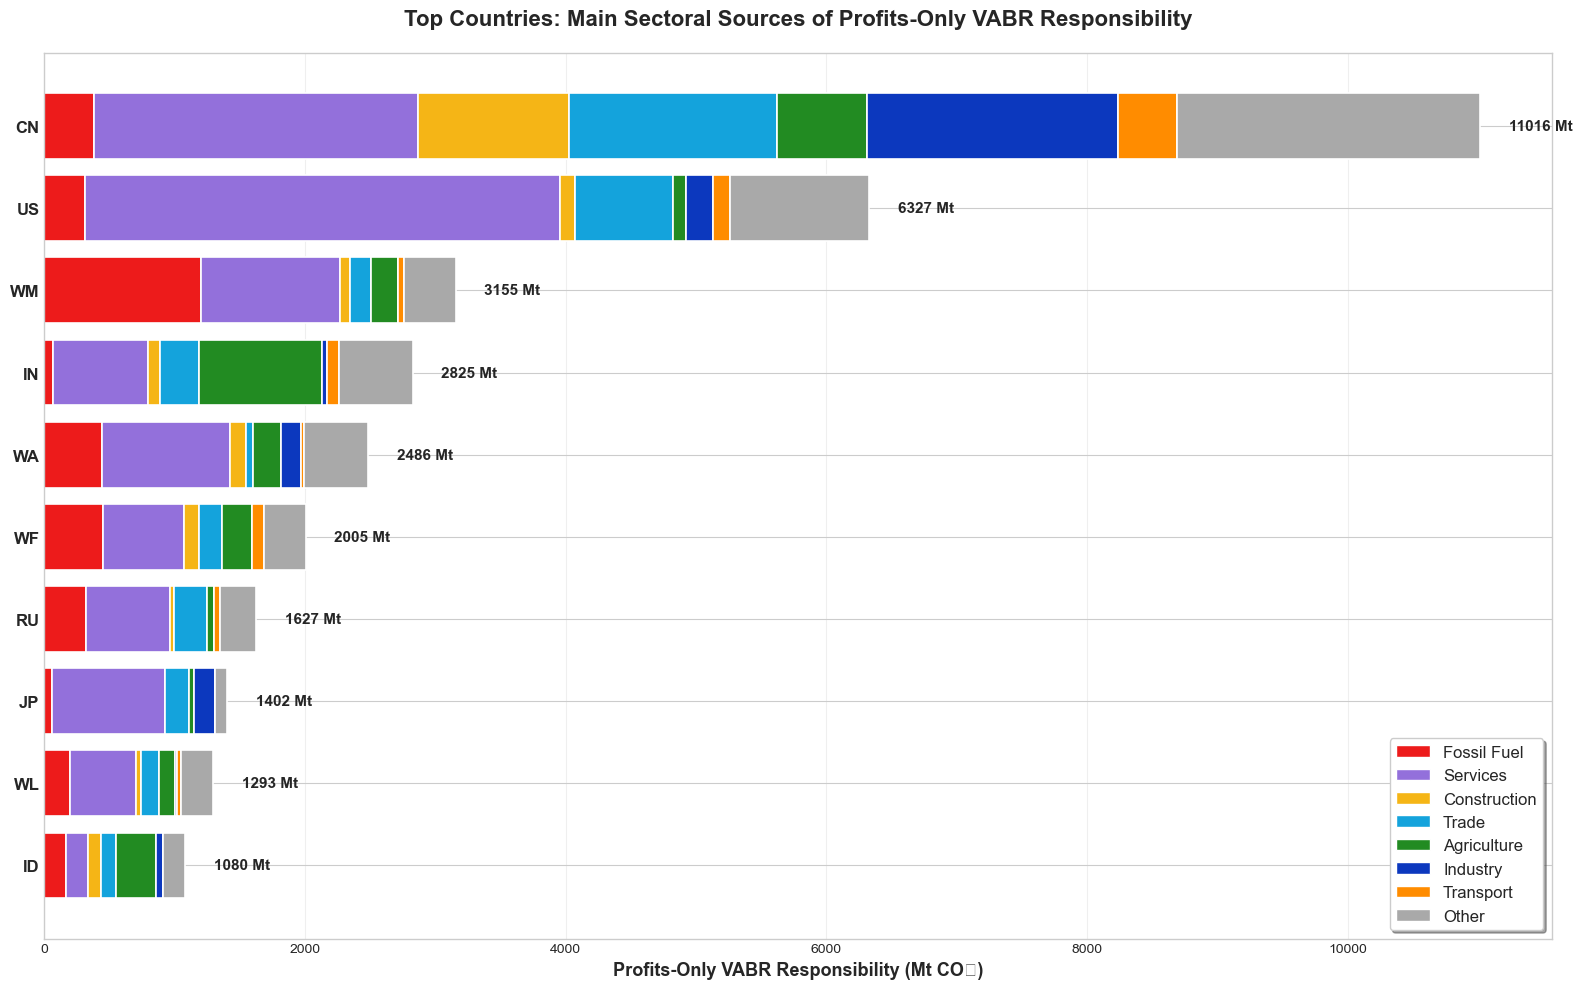

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Extract top 10 countries by profits-only VABR
print("EXTRACTING TOP 10 COUNTRIES...")
top10_profit_countries = summary_df.nlargest(10, 'ProfitVABR')['Country'].tolist()
print(f"Top 10 countries: {top10_profit_countries}")

# STEP 2: Calculate sector-level profits-only VABR
print("\nCALCULATING SECTOR-LEVEL VABR...")
sector_vabr_profits_only = pd.concat(
    calculate_vabr_profits_only(ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, None)[1]
).sort_index()

# Convert to Mt CO₂
sector_vabr_profits_only = sector_vabr_profits_only / 1e6

print(f"Sector data shape: {sector_vabr_profits_only.shape}")
print("Sample index structure:", sector_vabr_profits_only.index[:5])

# STEP 3: Define sector classification system with EXACT matching
# Use sets for faster lookup
fossil_fuel_sectors = {
    # Coal
    "Mining of coal and lignite; extraction of peat (10)",
    "Production of electricity by coal",
    "Manufacture of coke oven products",
    # Oil
    "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying",
    "Petroleum Refinery",
    "Production of electricity by petroleum and other oil derivatives",
    "Retail sale of automotive fuel",
    "Incineration of waste: Oil/Hazardous waste",
    "Plastics, basic",
    # Gas
    "Extraction of natural gas and services related to natural gas extraction, excluding surveying",
    "Extraction, liquefaction, and regasification of other petroleum and gaseous materials",
    "Manufacture of gas; distribution of gaseous fuels through mains",
    "Production of electricity by gas",
    "Transport via pipelines",
    "N-fertiliser",
    # Fossil electricity
    "Distribution and trade of electricity",
    "Transmission of electricity",
    "Steam and hot water supply",
}

renewable_sectors = {
    "Production of electricity by Geothermal",
    "Production of electricity by biomass and waste",
    "Production of electricity by hydro",
    "Production of electricity by solar photovoltaic",
    "Production of electricity by solar thermal",
    "Production of electricity by tide, wave, ocean",
    "Production of electricity by wind",
}

industry_sectors = {
    # Heavy + Light industry combined
    "Manufacture of basic iron and steel and of ferro-alloys and first products thereof",
    "Manufacture of cement, lime and plaster",
    "Manufacture of other non-metallic mineral products n.e.c.",
    "Aluminium production", "Copper production", "Lead, zinc and tin production",
    "Other non-ferrous metal production",
    "Chemicals nec", "Manufacture of beverages",
    "Manufacture of fabricated metal products, except machinery and equipment (28)",
    "Manufacture of machinery and equipment n.e.c. (29)",
    "Manufacture of motor vehicles, trailers and semi-trailers (34)",
    "Manufacture of textiles (17)", "Manufacture of rubber and plastic products (25)",
    "Manufacture of electrical machinery and apparatus n.e.c. (31)",
    "Manufacture of office machinery and computers (30)",
    "Manufacture of furniture; manufacturing n.e.c.; recycling (36)",
    "Manufacture of glass and glass products",
    "Tanning and dressing of leather; manufacture of luggage, handbags, saddlery, harness and footwear (19)",
    "Manufacture of other transport equipment (35)",
    "Paper"
}

agriculture_sectors = {
    "Cattle farming", "Poultry farming", "Pigs farming", "Meat animals nec",
    "Cultivation of cereal grains nec", "Cultivation of crops nec", "Cultivation of oil seeds",
    "Cultivation of paddy rice", "Cultivation of vegetables, fruit, nuts",
    "Cultivation of sugar cane, sugar beet", "Cultivation of wheat", "Raw milk",
    "Cultivation of plant-based fibers", "Forestry, logging and related service activities (02)",
    "Fishing, operating of fish hatcheries and fish farms; service activities incidental to fishing (05)",
    "Processing of Food products nec", "Manufacture of fish products", "Processing of meat poultry",
    "Processed rice", "Processing vegetable oils and fats", "Production of meat products nec"
}

transport_sectors = {
    "Air transport (62)", "Other land transport", "Sea and coastal water transport",
    "Inland water transport", "Supporting and auxiliary transport activities; activities of travel agencies (63)",
    "Sale, maintenance, repair of motor vehicles, motor vehicles parts and motorcycles",
    "Transport via railways"
}

services_sectors = {
    "Financial intermediation, except insurance and pension funding (65)",
    "Activities auxiliary to financial intermediation (67)",
    "Computer and related activities (72)", "Research and development (73)",
    "Education (80)", "Health and social work (85)", "Hotels and restaurants (55)",
    "Other business activities (74)", "Real estate activities (70)",
    "Post and telecommunications (64)", "Insurance and pension funding, except compulsory social security (66)",
    "Publishing, printing and reproduction of recorded media (22)",
    "Recreational, cultural and sporting activities (92)",
    "Other service activities (93)"
}

waste_sectors = {
    "Incineration of waste: Food", "Incineration of waste: Metals and Inert materials",
    "Incineration of waste: Paper", "Incineration of waste: Plastic",
    "Incineration of waste: Textiles", "Incineration of waste: Wood",
    "Recycling of waste and scrap", "Landfill of waste: Food",
    "Landfill of waste: Inert/metal/hazardous", "Landfill of waste: Paper",
    "Landfill of waste: Plastic", "Landfill of waste: Textiles", "Landfill of waste: Wood",
    "Composting of food waste, incl. land application",
    "Composting of paper and wood, incl. land application",
    "Manure treatment (biogas), storage and land application",
    "Manure treatment (conventional), storage and land application",
}

construction_sectors = {
    "Construction (45)"
}

trade_sectors = {
    "Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)",
    "Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)"
}

# Main category colors
main_category_colors = {
    'fossil_fuel': "#ED1B1B",     # Red for fossil fuels
    'renewable': '#32CD32',       # Green for renewables  
    'industry': "#0C38BE",        # Blue for industry
    'agriculture': '#228B22',     # Forest green for agriculture
    'transport': '#FF8C00',       # Orange for transport
    'services': '#9370DB',        # Purple for services
    'construction': "#F5B516",    # Goldenrod for construction
    'trade': "#14A3DC",          # Crimson for trade
    'waste': '#8B4513',          # Brown for waste
    'other': '#A9A9A9'           # Gray for other
}

def extract_sector_name(index_item):
    """Extract sector name from index item (could be tuple or string)"""
    if isinstance(index_item, tuple):
        # Usually (country, sector) tuple
        return index_item[1] if len(index_item) > 1 else str(index_item[0])
    else:
        return str(index_item)

def classify_main_category(sector_name):
    """Classify sector into main categories using exact matching"""
    # Clean the sector name
    sector_clean = sector_name.strip()
    
    # Exact matching first
    if sector_clean in fossil_fuel_sectors:
        return 'fossil_fuel'
    elif sector_clean in renewable_sectors:
        return 'renewable'
    elif sector_clean in industry_sectors:
        return 'industry'
    elif sector_clean in agriculture_sectors:
        return 'agriculture'
    elif sector_clean in transport_sectors:
        return 'transport'
    elif sector_clean in services_sectors:
        return 'services'
    elif sector_clean in waste_sectors:
        return 'waste'
    elif sector_clean in construction_sectors:
        return 'construction'
    elif sector_clean in trade_sectors:
        return 'trade'
    else:
        # Fallback to keyword matching for edge cases
        sector_lower = sector_clean.lower()
        if any(word in sector_lower for word in ['construction']):
            return 'construction'
        elif any(word in sector_lower for word in ['wholesale', 'retail', 'trade']):
            return 'trade'
        elif any(word in sector_lower for word in ['petroleum', 'crude oil', 'natural gas', 'coal']):
            return 'fossil_fuel'
        else:
            return 'other'

# Test the classification function with a few examples
print(f"\nTEST CLASSIFICATIONS:")
test_sectors = [
    'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
    'Real estate activities (70)',
    'Construction (45)',
    'Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)'
]

for sector in test_sectors:
    category = classify_main_category(sector)
    print(f"'{sector}' -> {category}")

# STEP 4: Extract and process data for top 10 countries
print(f"\n{'='*70}")
print("EXTRACTING SECTOR DATA FOR TOP 10 COUNTRIES...")
print("="*70)

country_sector_data = {}
country_category_data = {}

for country in top10_profit_countries:
    print(f"\nProcessing {country}...")
    
    if country in sector_vabr_profits_only.index.get_level_values(0):
        # Get all sectors for this country
        country_sectors = sector_vabr_profits_only.loc[country].sort_values(ascending=False)
        
        # Convert to proper numeric values if needed
        if hasattr(country_sectors, 'values'):
            # Extract just the values, convert any tuples to first element
            clean_values = []
            clean_index = []
            for idx, val in country_sectors.items():
                # Handle tuple values
                if isinstance(val, tuple):
                    clean_val = val[0] if len(val) > 0 and isinstance(val[0], (int, float)) else 0
                else:
                    clean_val = val
                clean_values.append(clean_val)
                clean_index.append(idx)
            
            country_sectors = pd.Series(clean_values, index=clean_index).sort_values(ascending=False)
        
        # Filter to significant sectors (>1% of country total OR top 10)
        country_total = country_sectors.sum()
        significant_sectors = country_sectors[
            (country_sectors/country_total >= 0.01) | 
            (country_sectors.rank(ascending=False) <= 10)
        ]
        
        print(f"  Total VABR: {country_total:.1f} Mt")
        print(f"  Significant sectors: {len(significant_sectors)}")
        
        # Store sector data
        country_sector_data[country] = significant_sectors
        
        # Group by main categories
        category_totals = {}
        for sector, value in significant_sectors.items():
            # Extract sector name properly
            sector_name = extract_sector_name(sector)
            main_category = classify_main_category(sector_name)
            
            if main_category not in category_totals:
                category_totals[main_category] = 0
            category_totals[main_category] += value
            
            # Print classification for verification (only first 10 for readability)
            if len([k for k in category_totals.keys()]) <= 15:  # Only show first few
                print(f"    {sector_name[:45]:<45} -> {main_category.upper():<12} ({value:.1f} Mt)")
        
        # Add remaining small sectors as "other" if significant
        remaining = country_total - significant_sectors.sum()
        if remaining > 0:
            if 'other' not in category_totals:
                category_totals['other'] = 0
            category_totals['other'] += remaining
            print(f"    {'Remaining small sectors':<45} -> {'OTHER':<12} ({remaining:.1f} Mt)")
        
        country_category_data[country] = category_totals
        
        # Print category summary for this country
        print(f"  CATEGORY SUMMARY for {country}:")
        for cat, val in sorted(category_totals.items(), key=lambda x: x[1], reverse=True):
            pct = (val/country_total)*100
            print(f"    {cat.upper():<15}: {val:>6.1f} Mt ({pct:>4.1f}%)")
    else:
        print(f"  ⚠️  No sector data available for {country}")
        country_category_data[country] = {}

# STEP 5: Create the visualization
print(f"\n{'='*70}")
print("CREATING VISUALIZATION...")

countries_with_data = [c for c in top10_profit_countries if c in country_category_data and country_category_data[c]]
print(f"Countries with data: {countries_with_data}")

if len(countries_with_data) == 0:
    print("❌ No countries with sector data found!")
else:
    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Get all categories that appear in the data
    all_categories = set()
    for country_data in country_category_data.values():
        all_categories.update(country_data.keys())
    
    print(f"All categories found: {sorted(all_categories)}")
    
    # Order categories (fossil fuels first, then others)
    category_order = ['fossil_fuel', 'services', 'construction', 'trade', 'agriculture', 
                     'industry', 'transport', 'renewable', 'waste', 'other']
    categories_in_data = [cat for cat in category_order if cat in all_categories]
    
    print(f"Categories to plot: {categories_in_data}")
    
    y_pos = np.arange(len(countries_with_data))
    bottoms = np.zeros(len(countries_with_data))
    
    # Plot each main category
    for category in categories_in_data:
        values = []
        for country in countries_with_data:
            val = country_category_data[country].get(category, 0)
            values.append(val)
        
        values = np.array(values)
        print(f"Plotting {category}: values = {values}")
        
        if values.sum() > 0:  # Only plot if category has data
            ax.barh(y_pos, values, left=bottoms, 
                   color=main_category_colors[category],
                   edgecolor='white', linewidth=1.2,
                   label=category.replace('_', ' ').title())
            bottoms += values
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(countries_with_data, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=13, fontweight='bold')
    ax.set_title('Top Countries: Main Sectoral Sources of Profits-Only VABR Responsibility', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add total values
    for i, country in enumerate(countries_with_data):
        total = bottoms[i]  # bottoms now contains the cumulative total
        ax.text(total + max(bottoms)*0.02, i, f'{total:.0f} Mt', va='center', 
               fontsize=11, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=main_category_colors[cat], edgecolor='white', 
                           label=cat.replace('_', ' ').title()) 
                      for cat in categories_in_data]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=12, 
             frameon=True, fancybox=True, shadow=True)
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

Countries with higher responsibility under profit-based VABR than standard VABR:
['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB', 'US', 'JP', 'CN', 'CA', 'KR', 'BR', 'IN', 'MX', 'RU', 'AU', 'CH', 'TR', 'TW', 'NO', 'ID', 'ZA', 'WA', 'WL', 'WE', 'WF', 'WM']


c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



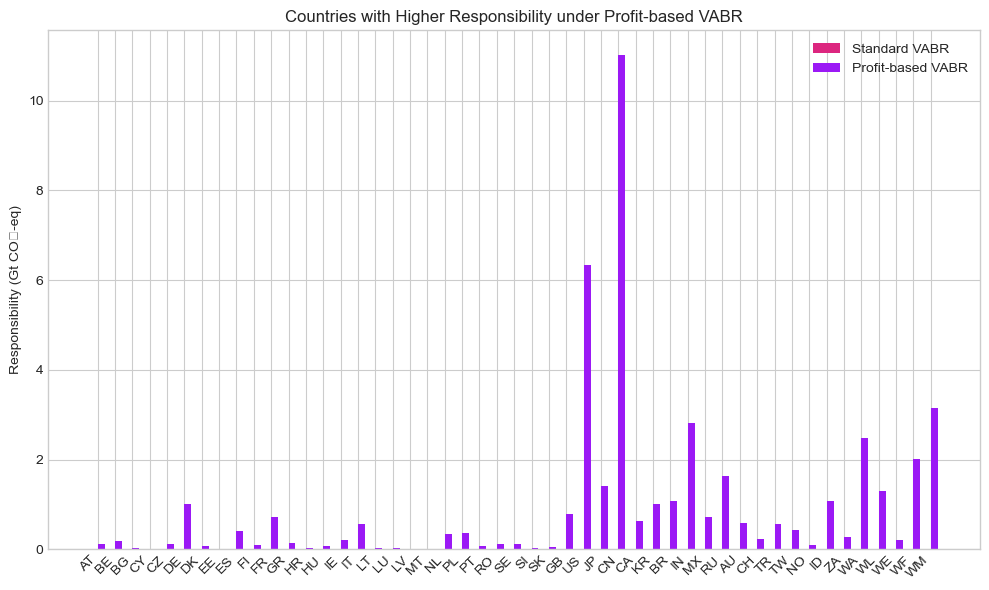

In [ ]:
import matplotlib.pyplot as plt

# Find all countries with higher responsibility under profit-based VABR than standard VABR
higher_profit_vabr = summary_df[summary_df['ProfitVABR'] > summary_df['VABR']]['Country'].tolist()
print("Countries with higher responsibility under profit-based VABR than standard VABR:")
print(higher_profit_vabr)

# Extract values for plotting
standard_vabr_vals = summary_df.set_index('Country').loc[higher_profit_vabr, 'VABR']
profit_vabr_vals = summary_df.set_index('Country').loc[higher_profit_vabr, 'ProfitVABR']

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(higher_profit_vabr))
width = 0.35
ax.bar(x - width/2, standard_vabr_vals / 1e9, width, label='Standard VABR', color='#dc267f')
ax.bar(x + width/2, profit_vabr_vals / 1e9, width, label='Profit-based VABR', color='#9b19f5')
ax.set_xticks(x)
ax.set_xticklabels(higher_profit_vabr, rotation=45, ha='right')
ax.set_ylabel('Responsibility (Gt CO₂-eq)')
ax.set_title('Countries with Higher Responsibility under Profit-based VABR')
ax.legend()
plt.tight_layout()
plt.show()

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



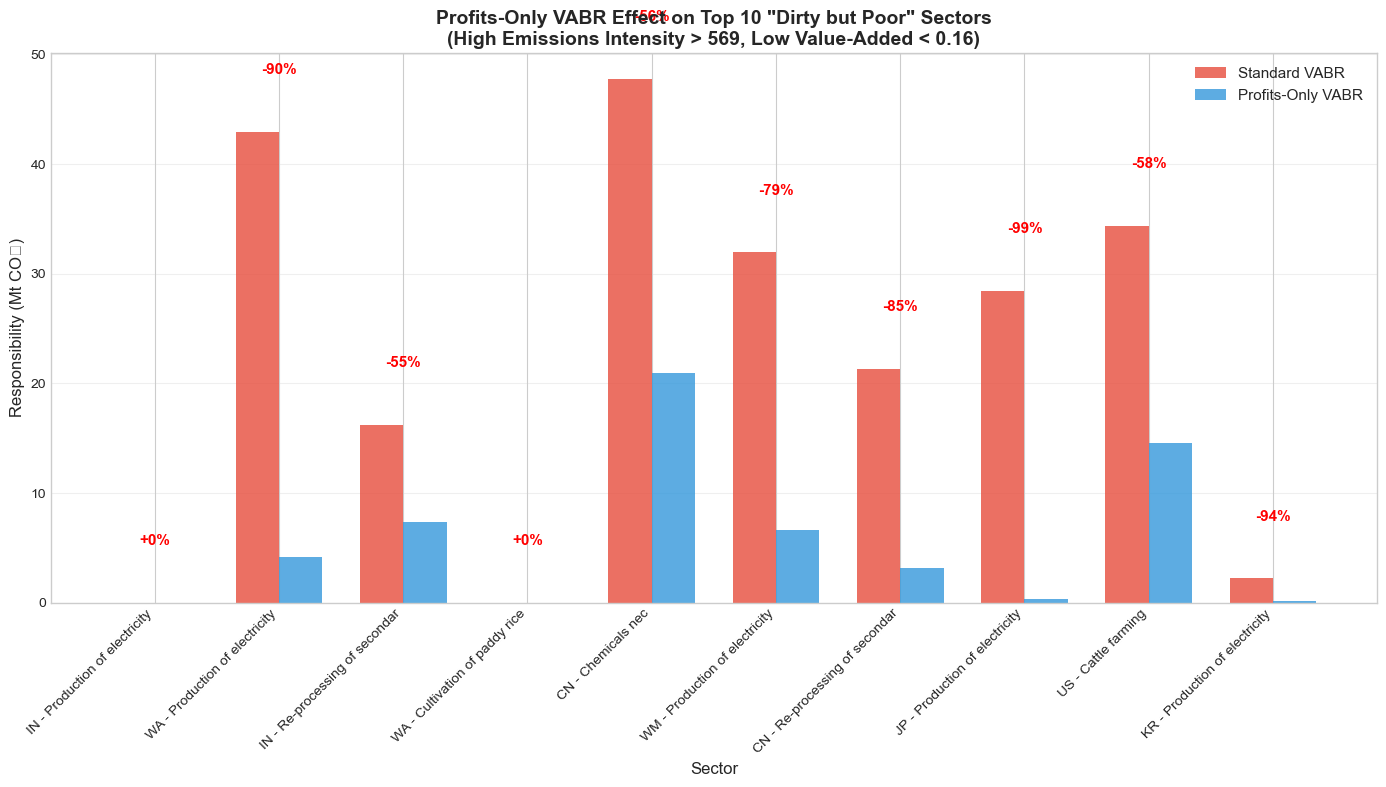

In [132]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# === TEIL 1: VERWENDE DIE ECHTEN TOP 20 DIRTY BUT POOR SEKTOREN ===
top20_dirty_poor = [
    ('IN', 'Production of electricity by coal'),
    ('CN', 'Mining of coal and lignite; extraction of peat'),
    ('WA', 'Production of electricity by coal'),
    ('IN', 'Re-processing of secondary steel into new steel'),
    ('WA', 'Cultivation of paddy rice'),
    ('CN', 'Chemicals nec'),
    ('WM', 'Production of electricity by petroleum and other oil derivatives'),
    ('CN', 'Re-processing of secondary steel into new steel'),
    ('JP', 'Production of electricity by coal'),
    ('US', 'Cattle farming'),
    ('KR', 'Production of electricity by coal'),
    ('WA', 'Cattle farming'),
    ('WF', 'Landfill of waste: Food'),
    ('WM', 'Manufacture of medical, precision and optical instruments'),
    ('JP', 'Production of electricity by gas'),
    ('US', 'Manufacture of wood and of products of wood'),
    ('WA', 'Manufacture of medical, precision and optical instruments'),
    ('CN', 'Production of electricity by gas'),
    ('WE', 'Production of electricity by coal'),
    ('WM', 'Landfill of waste: Food')
]

comparison_data = []
for country, sector in top20_dirty_poor:
    idx_list = [(i, ix) for i, ix in enumerate(ixi_data.x.index) if ix == (country, sector)]
    if idx_list:
        idx = idx_list[0][0]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        output = ixi_data.x.values.flatten()[idx]
        va_coeff = v_clean[idx]
        standard_vabr = emissions * va_coeff
        operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (country, sector)]
        profit_coeff = operating_surplus / output if output > 0 else 0
        profits_vabr = emissions * profit_coeff
        pct_change = ((profits_vabr - standard_vabr) / standard_vabr * 100) if standard_vabr > 0 else 0
        comparison_data.append({
            'label': f"{country} - {sector[:25]}",
            'standard': standard_vabr / 1e6,
            'profits': profits_vabr / 1e6,
            'pct_change': pct_change,
            'emissions': emissions / 1e6
        })

df_plot = pd.DataFrame(comparison_data)
df_plot = df_plot.sort_values('emissions', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(df_plot))
width = 0.35

bars1 = ax.bar(x - width/2, df_plot['standard'], width, 
               label='Standard VABR', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, df_plot['profits'], width,
               label='Profits-Only VABR', color='#3498db', alpha=0.8)

ax.set_xlabel('Sector', fontsize=12)
ax.set_ylabel('Responsibility (Mt CO₂)', fontsize=12)
ax.set_title('Profits-Only VABR Effect on Top 10 "Dirty but Poor" Sectors\n'
             '(High Emissions Intensity > 569, Low Value-Added < 0.16)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_plot['label'], rotation=45, ha='right', fontsize=10)

for i, (idx, row) in enumerate(df_plot.iterrows()):
    color = 'green' if row['pct_change'] > 0 else 'red'
    y_pos = max(row['standard'], row['profits']) + 5
    ax.text(i, y_pos, f"{row['pct_change']:+.0f}%",
           ha='center', va='bottom', fontweight='bold',
           color=color, fontsize=11)

ax.legend(loc='upper right', fontsize=11)
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

=== GEWINNER UNTER PROFITS-ONLY VABR (bekommen WENIGER Verantwortung) ===

Found 49 countries that PAY LESS under Profits-Only VABR
Total reduction in responsibility: 11680 Mt CO₂



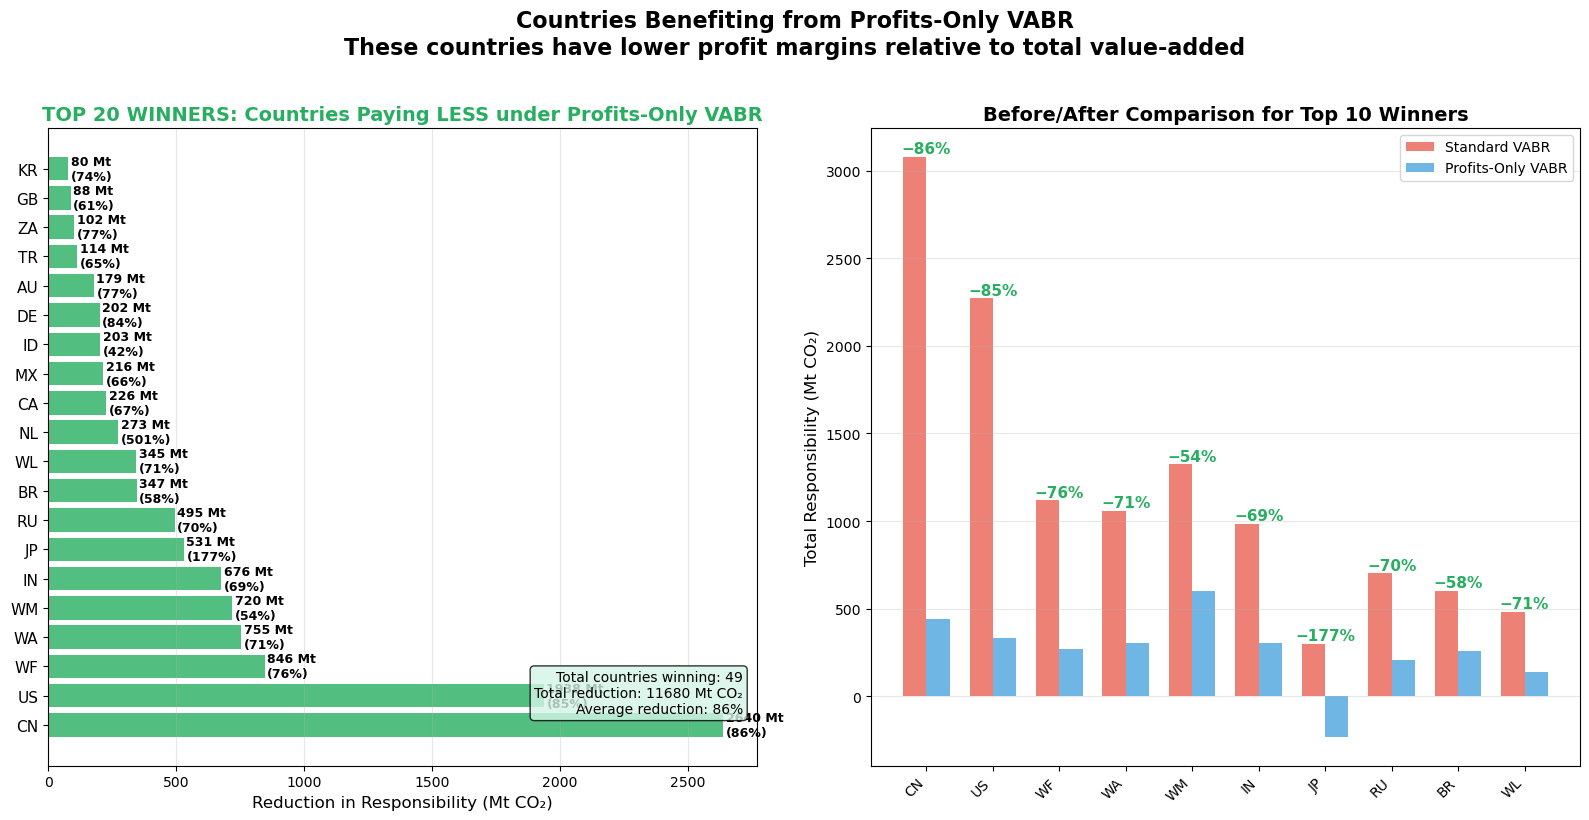


=== CHARAKTERISTIKA DER GEWINNER ===
Winners from developing regions: 10 (20%)
Winners from developed countries: 14 (29%)

TOP 5 WINNERS IN DETAIL:
------------------------------------------------------------
CN:
  Standard VABR: 3078 Mt
  Profits-Only: 438 Mt
  Reduction: 2640 Mt (86%)

US:
  Standard VABR: 2271 Mt
  Profits-Only: 333 Mt
  Reduction: 1938 Mt (85%)

WF:
  Standard VABR: 1118 Mt
  Profits-Only: 271 Mt
  Reduction: 846 Mt (76%)

WA:
  Standard VABR: 1058 Mt
  Profits-Only: 303 Mt
  Reduction: 755 Mt (71%)

WM:
  Standard VABR: 1323 Mt
  Profits-Only: 603 Mt
  Reduction: 720 Mt (54%)


=== WHICH SECTORS ARE WINNING? ===
Top 10 Winning Sectors (biggest reductions):
 1. Production of electricity by coal                  | −1677 Mt
 2. Air transport (62)                                 | −707 Mt
 3. Cattle farming                                     | −652 Mt
 4. Extraction of crude petroleum and services related | −635 Mt
 5. Manufacture of basic iron and steel and of ferr

In [103]:

## *Plot nur für GEWINNER (weniger Verantwortung unter Profits-Only VABR)*


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== GEWINNER UNTER PROFITS-ONLY VABR (bekommen WENIGER Verantwortung) ===\n")

# === SCHRITT 1: BERECHNE ÄNDERUNGEN FÜR ALLE LÄNDER ===
country_changes = {}
for country in set([idx[0] for idx in ixi_data.x.index]):
    standard_total = 0
    profits_total = 0
    
    for idx, (c, sector) in enumerate(ixi_data.x.index):
        if c == country:
            emissions = results['producer_by_sector'].get((c, sector), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # Standard VABR
                va_coeff = v_clean[idx]
                standard_total += emissions * va_coeff
                
                # Profits-Only VABR
                operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (c, sector)]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_total += emissions * profit_coeff
    
    if standard_total > 0:
        country_changes[country] = {
            'standard': standard_total / 1e6,  # Convert to Mt
            'profits': profits_total / 1e6,
            'reduction': (standard_total - profits_total) / 1e6,  # POSITIVE = reduction in responsibility
            'pct_reduction': (standard_total - profits_total) / standard_total * 100
        }

# Convert to DataFrame and filter ONLY WINNERS
df_countries = pd.DataFrame.from_dict(country_changes, orient='index')
winners_only = df_countries[df_countries['reduction'] > 0].copy()  # Only those with REDUCED responsibility
winners_only = winners_only.sort_values('reduction', ascending=False)  # Biggest reductions first

print(f"Found {len(winners_only)} countries that PAY LESS under Profits-Only VABR")
print(f"Total reduction in responsibility: {winners_only['reduction'].sum():.0f} Mt CO₂\n")

# === SCHRITT 2: PLOT TOP WINNERS ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- LEFT PLOT: Top 20 Countries with Reduced Responsibility ---
top_winners = winners_only.head(20)

y_pos = np.arange(len(top_winners))
bars1 = ax1.barh(y_pos, top_winners['reduction'], color='#27ae60', alpha=0.8)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_winners.index, fontsize=11)
ax1.set_xlabel('Reduction in Responsibility (Mt CO₂)', fontsize=12)
ax1.set_title('TOP 20 WINNERS: Countries Paying LESS under Profits-Only VABR', 
             fontsize=14, fontweight='bold', color='#27ae60')

# Add value labels
for i, (country, row) in enumerate(top_winners.iterrows()):
    reduction = row['reduction']
    pct = row['pct_reduction']
    
    # Show both absolute and percentage
    ax1.text(reduction + 10, i, f'{reduction:.0f} Mt\n({pct:.0f}%)',
            va='center', fontsize=9, fontweight='bold')

# Add summary box
summary_text = (f"Total countries winning: {len(winners_only)}\n"
               f"Total reduction: {winners_only['reduction'].sum():.0f} Mt CO₂\n"
               f"Average reduction: {winners_only['pct_reduction'].mean():.0f}%")
props = dict(boxstyle='round', facecolor='#d5f4e6', alpha=0.8)
ax1.text(0.98, 0.15, summary_text, transform=ax1.transAxes,
        fontsize=10, va='top', ha='right', bbox=props)

ax1.grid(True, axis='x', alpha=0.3)

# --- RIGHT PLOT: Percentage Reduction Comparison ---
# Show both standard and profits-only for context
top10 = winners_only.head(10)

x_pos = np.arange(len(top10))
width = 0.35

bars2 = ax2.bar(x_pos - width/2, top10['standard'], width, 
               label='Standard VABR', color='#e74c3c', alpha=0.7)
bars3 = ax2.bar(x_pos + width/2, top10['profits'], width,
               label='Profits-Only VABR', color='#3498db', alpha=0.7)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(top10.index, rotation=45, ha='right')
ax2.set_ylabel('Total Responsibility (Mt CO₂)', fontsize=12)
ax2.set_title('Before/After Comparison for Top 10 Winners', 
             fontsize=14, fontweight='bold')

# Add reduction percentages on top
for i, (country, row) in enumerate(top10.iterrows()):
    height = max(row['standard'], row['profits'])
    ax2.text(i, height + 20, f"−{row['pct_reduction']:.0f}%",
            ha='center', fontweight='bold', color='#27ae60', fontsize=11)

ax2.legend(loc='upper right')
ax2.grid(True, axis='y', alpha=0.3)

plt.suptitle('Countries Benefiting from Profits-Only VABR\n' +
            'These countries have lower profit margins relative to total value-added',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === SCHRITT 3: ANALYSE DER GEWINNER-CHARAKTERISTIKA ===
print("\n=== CHARAKTERISTIKA DER GEWINNER ===")

# Check if they are mostly developing countries
developing_regions = ['WA', 'WL', 'WF', 'WM', 'WE', 'IN', 'CN', 'BR', 'ID', 'MX']
developed = ['US', 'JP', 'DE', 'GB', 'FR', 'IT', 'CA', 'AU', 'KR', 'ES', 'NL', 'CH', 'SE', 'NO']

winners_developing = [c for c in winners_only.index if c in developing_regions]
winners_developed = [c for c in winners_only.index if c in developed]

print(f"Winners from developing regions: {len(winners_developing)} ({len(winners_developing)/len(winners_only)*100:.0f}%)")
print(f"Winners from developed countries: {len(winners_developed)} ({len(winners_developed)/len(winners_only)*100:.0f}%)")

# Top 5 winners with details
print("\nTOP 5 WINNERS IN DETAIL:")
print("-" * 60)
for country in top_winners.head(5).index:
    row = top_winners.loc[country]
    print(f"{country}:")
    print(f"  Standard VABR: {row['standard']:.0f} Mt")
    print(f"  Profits-Only: {row['profits']:.0f} Mt")
    print(f"  Reduction: {row['reduction']:.0f} Mt ({row['pct_reduction']:.0f}%)")
    print()

# === OPTIONAL: Sektor-Analyse für Gewinner ===
print("\n=== WHICH SECTORS ARE WINNING? ===")

# Aggregate by sector
sector_reductions = {}
for idx, (country, sector) in enumerate(ixi_data.x.index):
    emissions = results['producer_by_sector'].get((country, sector), 0)
    output = ixi_data.x.values.flatten()[idx]
    
    if output > 0 and emissions > 0:
        va_coeff = v_clean[idx]
        standard = emissions * va_coeff

        operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (country, sector)]
        profit_coeff = operating_surplus / output if output > 0 else 0
        profits = emissions * profit_coeff
        
        reduction = standard - profits
        
        if sector not in sector_reductions:
            sector_reductions[sector] = 0
        sector_reductions[sector] += reduction

# Find winning sectors
winning_sectors = {k: v/1e6 for k, v in sector_reductions.items() if v > 0}
winning_sectors = dict(sorted(winning_sectors.items(), key=lambda x: x[1], reverse=True))

print("Top 10 Winning Sectors (biggest reductions):")
for i, (sector, reduction) in enumerate(list(winning_sectors.items())[:10], 1):
    print(f"{i:2}. {sector[:50]:50} | −{reduction:.0f} Mt")

=== ABSOLUTE BURDEN UNDER PROFITS-ONLY VABR ===



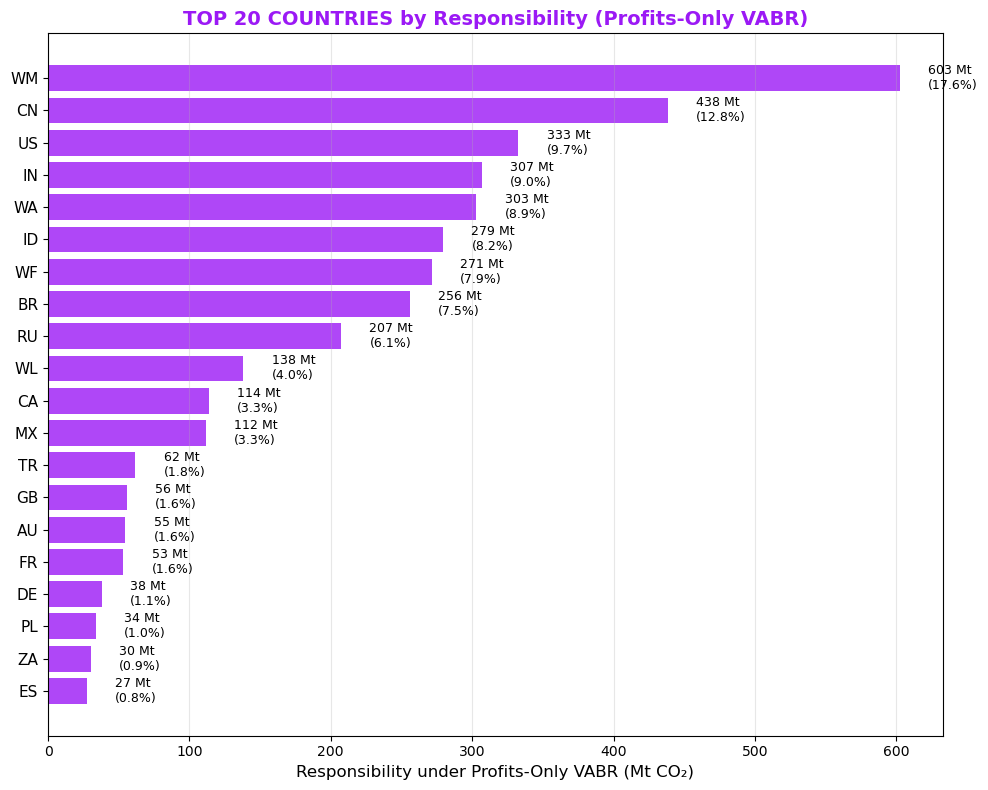

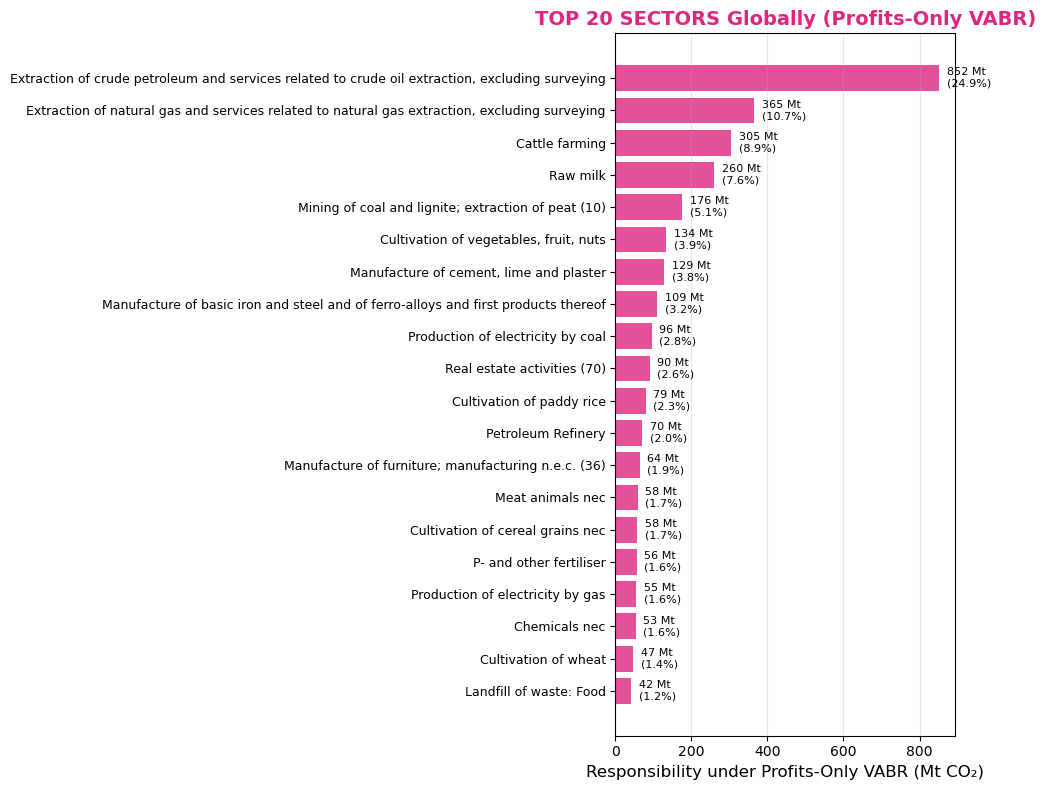


=== SUMMARY ===
Total global responsibility under profits-only VABR: 3418 Mt CO₂
Top 5 countries:
     profits  share_%
WM   602.71    17.63
CN   438.37    12.83
US   332.63     9.73
IN   306.69     8.97
WA   302.91     8.86
Top 5 sectors:
                                                     profits  share_%
Extraction of crude petroleum and services rela...   851.65    24.92
Extraction of natural gas and services related ...   365.37    10.69
Cattle farming                                       304.82     8.92
Raw milk                                             259.58     7.59
Mining of coal and lignite; extraction of peat ...   176.00     5.15


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== ABSOLUTE BURDEN UNDER PROFITS-ONLY VABR ===\n")

# === STEP 1: CALCULATE PROFIT-BASED VABR FOR ALL COUNTRIES & SECTORS ===
country_burden = {}
sector_burden = {}

for idx, (country, sector) in enumerate(ixi_data.x.index):
    emissions = results['producer_by_sector'].get((country, sector), 0)
    output = ixi_data.x.values.flatten()[idx]
    
    if output > 0 and emissions > 0:
        # Profits-Only VABR
        operating_surplus = ixi_data.factor_inputs.F.loc[
            'Operating surplus: Remaining net operating surplus',
            (country, sector)
        ]
        profit_coeff = operating_surplus / output if output > 0 else 0
        profits_alloc = emissions * profit_coeff
        
        # Aggregate to country
        if country not in country_burden:
            country_burden[country] = 0
        country_burden[country] += profits_alloc
        
        # Aggregate to sector (global)
        if sector not in sector_burden:
            sector_burden[sector] = 0
        sector_burden[sector] += profits_alloc

# Convert to DataFrames
df_countries = pd.DataFrame.from_dict(country_burden, orient='index', columns=['profits'])
df_countries['profits'] = df_countries['profits'] / 1e6  # Mt CO₂
df_countries['share_%'] = df_countries['profits'] / df_countries['profits'].sum() * 100

df_sectors = pd.DataFrame.from_dict(sector_burden, orient='index', columns=['profits'])
df_sectors['profits'] = df_sectors['profits'] / 1e6  # Mt CO₂
df_sectors['share_%'] = df_sectors['profits'] / df_sectors['profits'].sum() * 100

# === STEP 2: TOP 20 COUNTRIES ===
top_countries = df_countries.sort_values('profits', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_countries))

bars = ax.barh(y_pos, top_countries['profits'], color='#9b19f5', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_countries.index, fontsize=11)
ax.invert_yaxis()

ax.set_xlabel('Responsibility under Profits-Only VABR (Mt CO₂)', fontsize=12)
ax.set_title('TOP 20 COUNTRIES by Responsibility (Profits-Only VABR)', 
             fontsize=14, fontweight='bold', color='#9b19f5')

# Add labels with Mt and share %
for i, (country, row) in enumerate(top_countries.iterrows()):
    ax.text(row['profits'] + 20, i,
            f"{row['profits']:.0f} Mt\n({row['share_%']:.1f}%)",
            va='center', fontsize=9)

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# === STEP 3: TOP 20 SECTORS ===
top_sectors = df_sectors.sort_values('profits', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(top_sectors))

bars = ax.barh(y_pos, top_sectors['profits'], color='#dc267f', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_sectors.index, fontsize=9)
ax.invert_yaxis()

ax.set_xlabel('Responsibility under Profits-Only VABR (Mt CO₂)', fontsize=12)
ax.set_title('TOP 20 SECTORS Globally (Profits-Only VABR)', 
             fontsize=14, fontweight='bold', color='#dc267f')

# Add labels with Mt and share %
for i, (sector, row) in enumerate(top_sectors.iterrows()):
    ax.text(row['profits'] + 20, i,
            f"{row['profits']:.0f} Mt\n({row['share_%']:.1f}%)",
            va='center', fontsize=8)

ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# === STEP 4: SUMMARY ===
print("\n=== SUMMARY ===")
print(f"Total global responsibility under profits-only VABR: {df_countries['profits'].sum():.0f} Mt CO₂")
print("Top 5 countries:\n", top_countries.head(5))
print("Top 5 sectors:\n", top_sectors.head(5))


=== PROFITS-ONLY VABR: WER HAT DIE HÖCHSTE VERANTWORTUNG? ===



c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning:

Glyph 8322 missing from current font.

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning:

Glyph 8322 missing from current font.



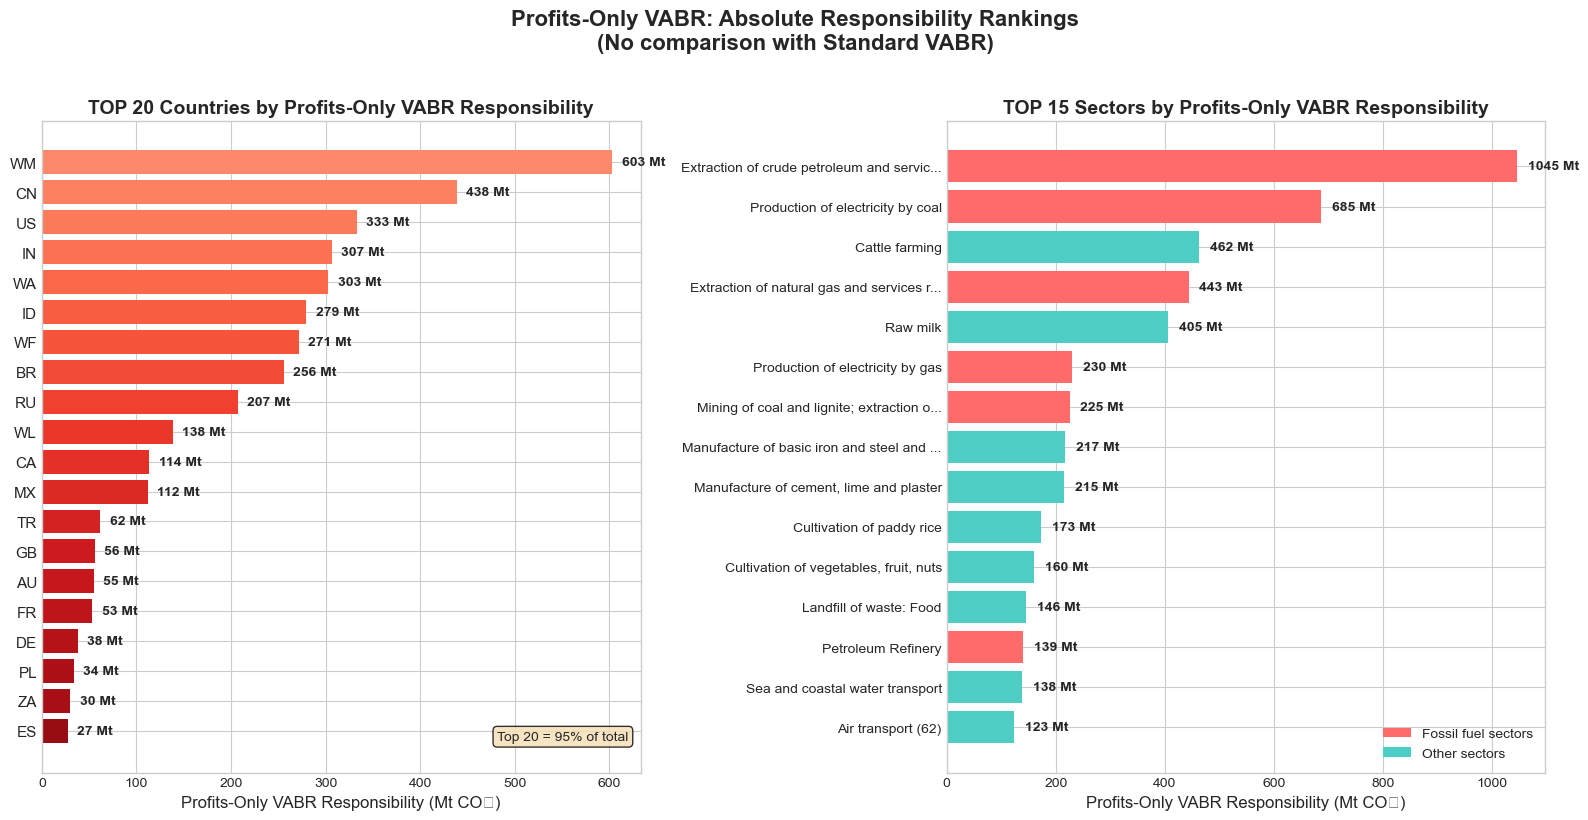


=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===
Total responsibility under Profits-Only VABR: 3898 Mt CO₂

TOP 10 COUNTRIES:
 1. WM :     603 Mt (15.5%)
 2. CN :     438 Mt (11.2%)
 3. US :     333 Mt ( 8.5%)
 4. IN :     307 Mt ( 7.9%)
 5. WA :     303 Mt ( 7.8%)
 6. ID :     279 Mt ( 7.2%)
 7. WF :     271 Mt ( 7.0%)
 8. BR :     256 Mt ( 6.6%)
 9. RU :     207 Mt ( 5.3%)
10. WL :     138 Mt ( 3.5%)

TOP 10 SECTORS:
 1. Extraction of crude petroleum and services related...:   1045 Mt
 2. Production of electricity by coal                 :    685 Mt
 3. Cattle farming                                    :    462 Mt
 4. Extraction of natural gas and services related to ...:    443 Mt
 5. Raw milk                                          :    405 Mt
 6. Production of electricity by gas                  :    230 Mt
 7. Mining of coal and lignite; extraction of peat (10...:    225 Mt
 8. Manufacture of basic iron and steel and of ferro-a...:    217 Mt
 9. Manufacture of cement, lime and plast

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== PROFITS-ONLY VABR: WER HAT DIE HÖCHSTE VERANTWORTUNG? ===\n")

# === SCHRITT 1: BERECHNE PROFITS-ONLY VABR FÜR ALLE LÄNDER ===
country_profits_vabr = {}

for country in set([idx[0] for idx in ixi_data.x.index]):
    total_profits_responsibility = 0
    
    for idx, (c, sector) in enumerate(ixi_data.x.index):
        if c == country:
            emissions = results['producer_by_sector'].get((c, sector), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # NUR Profits-Only VABR berechnen
                operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (c, sector)]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_profits_responsibility += profits_responsibility
    
    if total_profits_responsibility > 0:
        country_profits_vabr[country] = total_profits_responsibility / 1e6  # Convert to Mt

# === SCHRITT 2: BERECHNE PROFITS-ONLY VABR FÜR ALLE SEKTOREN ===
sector_profits_vabr = {}

for sector in set([idx[1] for idx in ixi_data.x.index]):
    total_sector_responsibility = 0
    
    for idx, (country, s) in enumerate(ixi_data.x.index):
        if s == sector:
            emissions = results['producer_by_sector'].get((country, s), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # Nur "Operating surplus: Remaining net operating surplus" verwenden
                operating_surplus = ixi_data.factor_inputs.F.loc[
                    "Operating surplus: Remaining net operating surplus", (country, s)
                ]
                operating_surplus = sum(
                    ixi_data.factor_inputs.F.loc[comp, (country, s)]
                    for comp in os_components
                )
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_sector_responsibility += profits_responsibility
    
    if total_sector_responsibility > 0:
        sector_profits_vabr[sector] = total_sector_responsibility / 1e6  # Convert to Mt

# Sort by responsibility
country_ranking = pd.Series(country_profits_vabr).sort_values(ascending=False)
sector_ranking = pd.Series(sector_profits_vabr).sort_values(ascending=False)

# === SCHRITT 3: VISUALISIERUNG ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- PLOT 1: Top 20 Länder mit höchster Profits-Only VABR Verantwortung ---
top20_countries = country_ranking.head(20)

colors_countries = plt.cm.Reds(np.linspace(0.4, 0.9, len(top20_countries)))
bars1 = ax1.barh(range(len(top20_countries)), top20_countries.values, color=colors_countries)

ax1.set_yticks(range(len(top20_countries)))
ax1.set_yticklabels(top20_countries.index, fontsize=11)
ax1.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=12)
ax1.set_title('TOP 20 Countries by Profits-Only VABR Responsibility', 
             fontsize=14, fontweight='bold')
ax1.invert_yaxis()  # Highest at top

# Add value labels
for i, (country, value) in enumerate(top20_countries.items()):
    ax1.text(value + 10, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add total percentage
total_country_resp = country_ranking.sum()
top20_share = top20_countries.sum() / total_country_resp * 100
ax1.text(0.98, 0.05, f'Top 20 = {top20_share:.0f}% of total',
        transform=ax1.transAxes, ha='right', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- PLOT 2: Top 15 Sektoren mit höchster Profits-Only VABR Verantwortung ---
top15_sectors = sector_ranking.head(15)

# Truncate long names
sector_names = [s[:40] + '...' if len(s) > 40 else s for s in top15_sectors.index]

# Color fossil fuel sectors differently
fossil_keywords = ['coal', 'oil', 'gas', 'petroleum', 'lignite']
colors_sectors = []
for sector in top15_sectors.index:
    if any(k in sector.lower() for k in fossil_keywords):
        colors_sectors.append('#ff6b6b')  # Red for fossil
    else:
        colors_sectors.append('#4ecdc4')  # Teal for others

bars2 = ax2.barh(range(len(top15_sectors)), top15_sectors.values, color=colors_sectors)

ax2.set_yticks(range(len(top15_sectors)))
ax2.set_yticklabels(sector_names, fontsize=10)
ax2.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=12)
ax2.set_title('TOP 15 Sectors by Profits-Only VABR Responsibility', 
             fontsize=14, fontweight='bold')
ax2.invert_yaxis()  # Highest at top

# Add value labels
for i, value in enumerate(top15_sectors.values):
    ax2.text(value + 20, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff6b6b', label='Fossil fuel sectors'),
    Patch(facecolor='#4ecdc4', label='Other sectors')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Profits-Only VABR: Absolute Responsibility Rankings\n(No comparison with Standard VABR)',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === SCHRITT 4: ZUSAMMENFASSUNG ===
print("\n=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===")
print(f"Total responsibility under Profits-Only VABR: {country_ranking.sum():.0f} Mt CO₂\n")

print("TOP 10 COUNTRIES:")
for i, (country, value) in enumerate(country_ranking.head(10).items(), 1):
    print(f"{i:2}. {country:3}: {value:7.0f} Mt ({value/country_ranking.sum()*100:4.1f}%)")

print("\nTOP 10 SECTORS:")
for i, (sector, value) in enumerate(sector_ranking.head(10).items(), 1):
    sector_short = sector[:50] + '...' if len(sector) > 50 else sector
    print(f"{i:2}. {sector_short:50}: {value:6.0f} Mt")

# Check concentration
print(f"\nCONCENTRATION:")
print(f"Top 5 countries: {country_ranking.head(5).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 10 countries: {country_ranking.head(10).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 5 sectors: {sector_ranking.head(5).sum()/sector_ranking.sum()*100:.1f}% of total")

In [106]:
import plotly.graph_objects as go

# === PREPARE DATA FOR SANKEY ===
# Take top 5 sectors and top 10 countries for readability
top_sectors = sector_ranking.head(5).index
top_countries = country_ranking.head(10).index

# Build flows: from each sector to each country
flows = []
for sector in top_sectors:
    for idx, (country, s) in enumerate(ixi_data.x.index):
        if s == sector and country in top_countries:
            emissions = results['producer_by_sector'].get((country, s), 0)
            output = ixi_data.x.values.flatten()[idx]
            if output > 0 and emissions > 0:
                operating_surplus = ixi_data.factor_inputs.F.loc[
                    'Operating surplus: Remaining net operating surplus', (country, s)
                ]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff / 1e6  # Mt

                if profits_responsibility > 0:
                    flows.append((sector, country, profits_responsibility))

# === MAP SECTORS AND COUNTRIES TO NODE INDICES ===
sector_nodes = list(top_sectors)
country_nodes = list(top_countries)
all_nodes = sector_nodes + country_nodes

node_indices = {node: i for i, node in enumerate(all_nodes)}

# Build Sankey link lists
sources = [node_indices[s] for s, c, v in flows]
targets = [node_indices[c] for s, c, v in flows]
values = [v for s, c, v in flows]

# === CREATE SANKEY DIAGRAM ===
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes,
        color=["#ff6b6b"]*len(sector_nodes) + ["#4ecdc4"]*len(country_nodes)  # sectors red, countries teal
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(150,150,150,0.4)"  # semi-transparent gray flows
    )
)])

fig.update_layout(
    title_text="Profits-Only VABR: Flows from Top 5 Sectors to Top 10 Countries",
    font_size=12
)

fig.show()


=== Extended profit VABR: Who has highest responsability ===



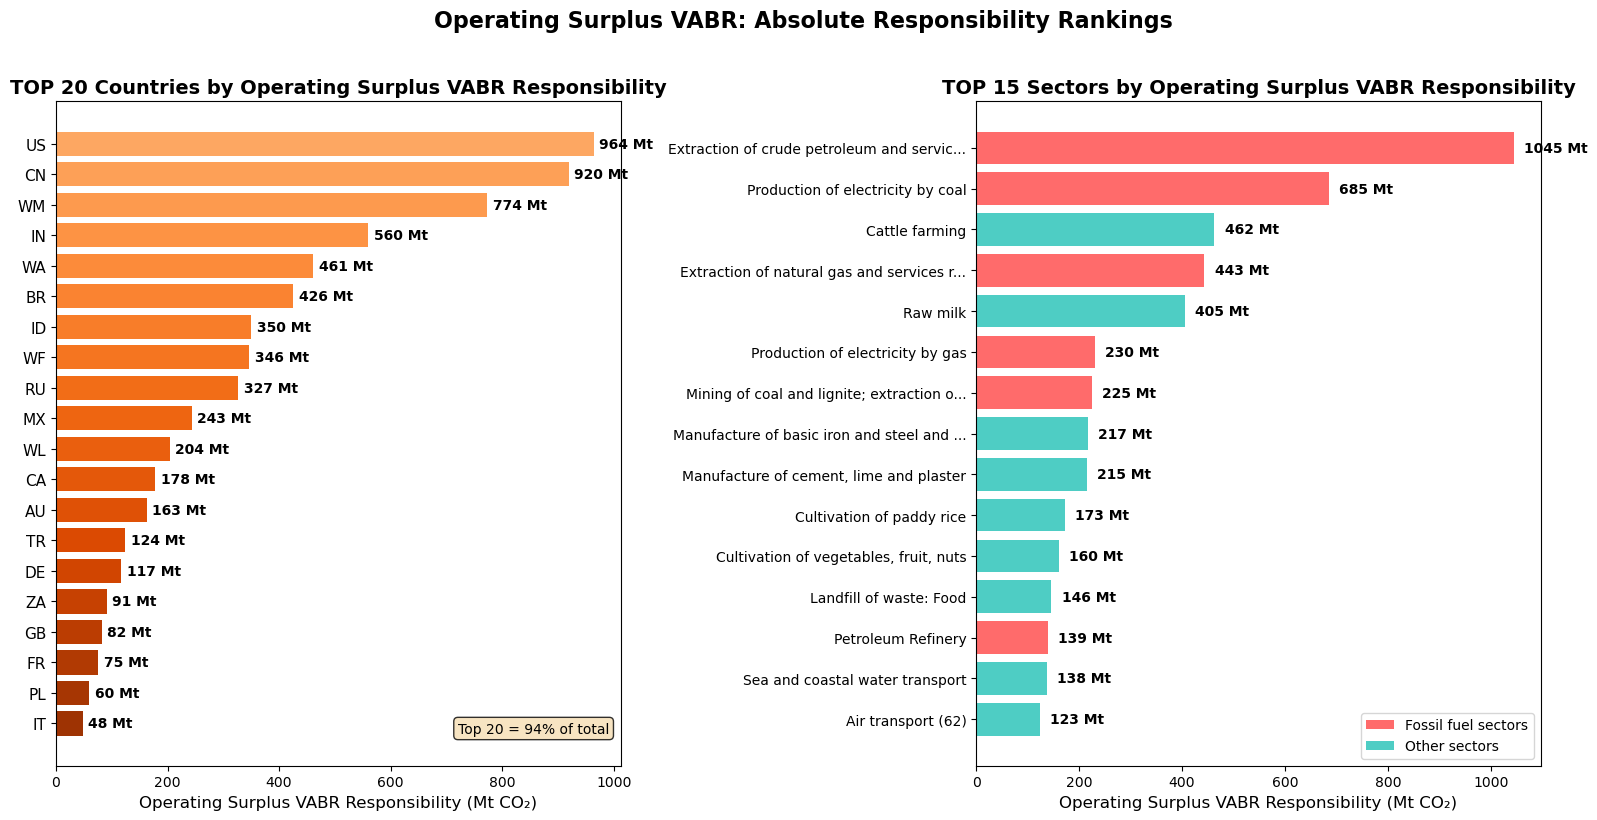


=== SUMMARY: OPERATING SURPLUS VABR RANKINGS ===
Total responsibility under Operating Surplus VABR: 6901 Mt CO₂

TOP 10 COUNTRIES:
 1. US :     964 Mt (14.0%)
 2. CN :     920 Mt (13.3%)
 3. WM :     774 Mt (11.2%)
 4. IN :     560 Mt ( 8.1%)
 5. WA :     461 Mt ( 6.7%)
 6. BR :     426 Mt ( 6.2%)
 7. ID :     350 Mt ( 5.1%)
 8. WF :     346 Mt ( 5.0%)
 9. RU :     327 Mt ( 4.7%)
10. MX :     243 Mt ( 3.5%)

TOP 10 SECTORS:
 1. Extraction of crude petroleum and services related...:   1045 Mt
 2. Production of electricity by coal                 :    685 Mt
 3. Cattle farming                                    :    462 Mt
 4. Extraction of natural gas and services related to ...:    443 Mt
 5. Raw milk                                          :    405 Mt
 6. Production of electricity by gas                  :    230 Mt
 7. Mining of coal and lignite; extraction of peat (10...:    225 Mt
 8. Manufacture of basic iron and steel and of ferro-a...:    217 Mt
 9. Manufacture of cement, lime

<Figure size 640x480 with 0 Axes>


=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===
Total responsibility under Profits-Only VABR: 3898 Mt CO₂

TOP 10 COUNTRIES:
 1. WM :     603 Mt (15.5%)
 2. CN :     438 Mt (11.2%)
 3. US :     333 Mt ( 8.5%)
 4. IN :     307 Mt ( 7.9%)
 5. WA :     303 Mt ( 7.8%)
 6. ID :     279 Mt ( 7.2%)
 7. WF :     271 Mt ( 7.0%)
 8. BR :     256 Mt ( 6.6%)
 9. RU :     207 Mt ( 5.3%)
10. WL :     138 Mt ( 3.5%)

TOP 10 SECTORS:
 1. Extraction of crude petroleum and services related...:   1045 Mt
 2. Production of electricity by coal                 :    685 Mt
 3. Cattle farming                                    :    462 Mt
 4. Extraction of natural gas and services related to ...:    443 Mt
 5. Raw milk                                          :    405 Mt
 6. Production of electricity by gas                  :    230 Mt
 7. Mining of coal and lignite; extraction of peat (10...:    225 Mt
 8. Manufacture of basic iron and steel and of ferro-a...:    217 Mt
 9. Manufacture of cement, lime and plast

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("=== Extended profit VABR: Who has highest responsability ===\n")

# === SCHRITT 1: BERECHNE PROFITS-ONLY VABR FÜR ALLE LÄNDER ===
country_profits_vabr = {}

for country in set([idx[0] for idx in ixi_data.x.index]):
    total_profits_responsibility = 0
    
    for idx, (c, sector) in enumerate(ixi_data.x.index):
        if c == country:
            emissions = results['producer_by_sector'].get((c, sector), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                # NUR Profits-Only VABR berechnen
                operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (c, sector)]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_profits_responsibility += profits_responsibility
    
    if total_profits_responsibility > 0:
        country_profits_vabr[country] = total_profits_responsibility / 1e6  # Convert to Mt

# === SCHRITT 2: BERECHNE PROFITS-ONLY VABR FÜR ALLE SEKTOREN ===
sector_profits_vabr = {}

for sector in set([idx[1] for idx in ixi_data.x.index]):
    total_sector_responsibility = 0
    
    for idx, (country, s) in enumerate(ixi_data.x.index):
        if s == sector:
            emissions = results['producer_by_sector'].get((country, s), 0)
            output = ixi_data.x.values.flatten()[idx]
            
            if output > 0 and emissions > 0:
                operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (country, s)]
                profit_coeff = operating_surplus / output if output > 0 else 0
                profits_responsibility = emissions * profit_coeff
                total_sector_responsibility += profits_responsibility

os_components = [
    "Operating surplus: Consumption of fixed capital",
    "Operating surplus: Rents on land",
    "Operating surplus: Royalties on resources",
    "Operating surplus: Remaining net operating surplus"
]

country_os_vabr = {}
for country in set([idx[0] for idx in ixi_data.x.index]):
    total_os_responsibility = 0
    for idx, (c, sector) in enumerate(ixi_data.x.index):
        if c == country:
            emissions = results['producer_by_sector'].get((c, sector), 0)
            output = ixi_data.x.values.flatten()[idx]
            if output > 0 and emissions > 0:
                operating_surplus = sum(
                    ixi_data.factor_inputs.F.loc[comp, (c, sector)]
                    for comp in os_components
                )
                os_coeff = operating_surplus / output if output > 0 else 0
                os_responsibility = emissions * os_coeff
                total_os_responsibility += os_responsibility
    if total_os_responsibility > 0:
        country_os_vabr[country] = total_os_responsibility / 1e6  # Mt

sector_os_vabr = {}
for sector in set([idx[1] for idx in ixi_data.x.index]):
    total_sector_os_responsibility = 0
    for idx, (country, s) in enumerate(ixi_data.x.index):
        if s == sector:
            emissions = results['producer_by_sector'].get((country, s), 0)
            output = ixi_data.x.values.flatten()[idx]
            if output > 0 and emissions > 0:
                operating_surplus = sum(
                    ixi_data.factor_inputs.F.loc[comp, (country, s)]
                    for comp in os_components
                )
                os_coeff = operating_surplus / output if output > 0 else 0
                os_responsibility = emissions * os_coeff
                total_sector_os_responsibility += os_responsibility
    if total_sector_os_responsibility > 0:
        sector_os_vabr[sector] = total_sector_os_responsibility / 1e6  # Mt

# ...visualization and summary as before, but use country_os_vabr and sector_os_vabr...
# === SCHRITT 3: VISUALISIERUNG ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- PLOT 1: Top 20 Länder mit höchster Operating Surplus VABR Verantwortung ---
country_os_ranking = pd.Series(country_os_vabr).sort_values(ascending=False)
top20_os_countries = country_os_ranking.head(20)

colors_os_countries = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top20_os_countries)))
bars1 = ax1.barh(range(len(top20_os_countries)), top20_os_countries.values, color=colors_os_countries)

ax1.set_yticks(range(len(top20_os_countries)))
ax1.set_yticklabels(top20_os_countries.index, fontsize=11)
ax1.set_xlabel('Operating Surplus VABR Responsibility (Mt CO₂)', fontsize=12)
ax1.set_title('TOP 20 Countries by Operating Surplus VABR Responsibility', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels
for i, (country, value) in enumerate(top20_os_countries.items()):
    ax1.text(value + 10, i, f'{value:.0f} Mt', va='center', fontsize=10, fontweight='bold')

# Add total percentage
total_os_country_resp = country_os_ranking.sum()
top20_os_share = top20_os_countries.sum() / total_os_country_resp * 100
ax1.text(0.98, 0.05, f'Top 20 = {top20_os_share:.0f}% of total',
        transform=ax1.transAxes, ha='right', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- PLOT 2: Top 15 Sektoren mit höchster Operating Surplus VABR Verantwortung ---
sector_os_ranking = pd.Series(sector_os_vabr).sort_values(ascending=False)
top15_os_sectors = sector_os_ranking.head(15)

sector_names_os = [s[:40] + '...' if len(s) > 40 else s for s in top15_os_sectors.index]
fossil_keywords = ['coal', 'oil', 'gas', 'petroleum', 'lignite']
colors_os_sectors = []
for sector in top15_os_sectors.index:
    if any(k in sector.lower() for k in fossil_keywords):
        colors_os_sectors.append('#ff6b6b')
    else:
        colors_os_sectors.append('#4ecdc4')

bars2 = ax2.barh(range(len(top15_os_sectors)), top15_os_sectors.values, color=colors_os_sectors)

ax2.set_yticks(range(len(top15_os_sectors)))
ax2.set_yticklabels(sector_names_os, fontsize=10)
ax2.set_xlabel('Operating Surplus VABR Responsibility (Mt CO₂)', fontsize=12)
ax2.set_title('TOP 15 Sectors by Operating Surplus VABR Responsibility', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

for i, value in enumerate(top15_os_sectors.values):
    ax2.text(value + 20, i, f'{value:.0f} Mt', va='center', fontsize=10, fontweight='bold')

legend_elements = [
    Patch(facecolor='#ff6b6b', label='Fossil fuel sectors'),
    Patch(facecolor='#4ecdc4', label='Other sectors')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Operating Surplus VABR: Absolute Responsibility Rankings', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === SCHRITT 4: ZUSAMMENFASSUNG ===
print("\n=== SUMMARY: OPERATING SURPLUS VABR RANKINGS ===")
print(f"Total responsibility under Operating Surplus VABR: {country_os_ranking.sum():.0f} Mt CO₂\n")

print("TOP 10 COUNTRIES:")
for i, (country, value) in enumerate(country_os_ranking.head(10).items(), 1):
    print(f"{i:2}. {country:3}: {value:7.0f} Mt ({value/country_os_ranking.sum()*100:4.1f}%)")

print("\nTOP 10 SECTORS:")
for i, (sector, value) in enumerate(sector_os_ranking.head(10).items(), 1):
    sector_short = sector[:50] + '...' if len(sector) > 50 else sector
    print(f"{i:2}. {sector_short:50}: {value:6.0f} Mt")

print(f"\nCONCENTRATION:")
print(f"Top 5 countries: {country_os_ranking.head(5).sum()/country_os_ranking.sum()*100:.1f}% of total")
print(f"Top 10 countries: {country_os_ranking.head(10).sum()/country_os_ranking.sum()*100:.1f}% of total")
print(f"Top 5 sectors: {sector_os_ranking.head(5).sum()/sector_os_ranking.sum()*100:.1f}% of total")

# Add value labels
for i, (country, value) in enumerate(top20_countries.items()):
    ax1.text(value + 10, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add total percentage
total_country_resp = country_ranking.sum()
top20_share = top20_countries.sum() / total_country_resp * 100
ax1.text(0.98, 0.05, f'Top 20 = {top20_share:.0f}% of total',
        transform=ax1.transAxes, ha='right', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# --- PLOT 2: Top 15 Sektoren mit höchster Profits-Only VABR Verantwortung ---
top15_sectors = sector_ranking.head(15)

# Truncate long names
sector_names = [s[:40] + '...' if len(s) > 40 else s for s in top15_sectors.index]

# Color fossil fuel sectors differently
fossil_keywords = ['coal', 'oil', 'gas', 'petroleum', 'lignite']
colors_sectors = []
for sector in top15_sectors.index:
    if any(k in sector.lower() for k in fossil_keywords):
        colors_sectors.append('#ff6b6b')  # Red for fossil
    else:
        colors_sectors.append('#4ecdc4')  # Teal for others

bars2 = ax2.barh(range(len(top15_sectors)), top15_sectors.values, color=colors_sectors)

ax2.set_yticks(range(len(top15_sectors)))
ax2.set_yticklabels(sector_names, fontsize=10)
ax2.set_xlabel('Profits-Only VABR Responsibility (Mt CO₂)', fontsize=12)
ax2.set_title('TOP 15 Sectors by Profits-Only VABR Responsibility', 
             fontsize=14, fontweight='bold')
ax2.invert_yaxis()  # Highest at top

# Add value labels
for i, value in enumerate(top15_sectors.values):
    ax2.text(value + 20, i, f'{value:.0f} Mt', 
            va='center', fontsize=10, fontweight='bold')

# Add legend for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#ff6b6b', label='Fossil fuel sectors'),
    Patch(facecolor='#4ecdc4', label='Other sectors')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.suptitle('Profits-Only VABR: Absolute Responsibility Rankings\n(No comparison with Standard VABR)',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# === SCHRITT 4: ZUSAMMENFASSUNG ===
print("\n=== SUMMARY: PROFITS-ONLY VABR RANKINGS ===")
print(f"Total responsibility under Profits-Only VABR: {country_ranking.sum():.0f} Mt CO₂\n")

print("TOP 10 COUNTRIES:")
for i, (country, value) in enumerate(country_ranking.head(10).items(), 1):
    print(f"{i:2}. {country:3}: {value:7.0f} Mt ({value/country_ranking.sum()*100:4.1f}%)")

print("\nTOP 10 SECTORS:")
for i, (sector, value) in enumerate(sector_ranking.head(10).items(), 1):
    sector_short = sector[:50] + '...' if len(sector) > 50 else sector
    print(f"{i:2}. {sector_short:50}: {value:6.0f} Mt")

# Check concentration
print(f"\nCONCENTRATION:")
print(f"Top 5 countries: {country_ranking.head(5).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 10 countries: {country_ranking.head(10).sum()/country_ranking.sum()*100:.1f}% of total")
print(f"Top 5 sectors: {sector_ranking.head(5).sum()/sector_ranking.sum()*100:.1f}% of total")


=== VABR CALCULATION (PROFITS ONLY) ===
Mean profit coefficient: 0.0743
Non-zero profit coefficients: 5773/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on profits only...
[VABR PROFITS] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%


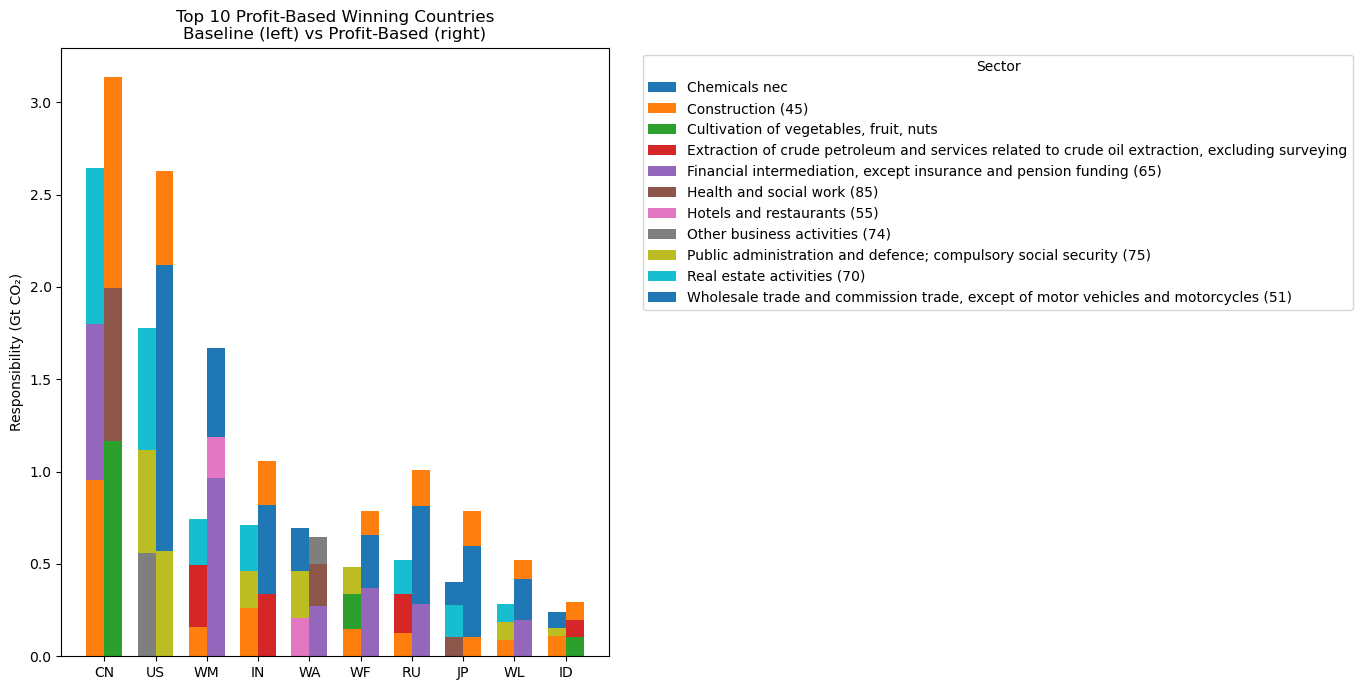

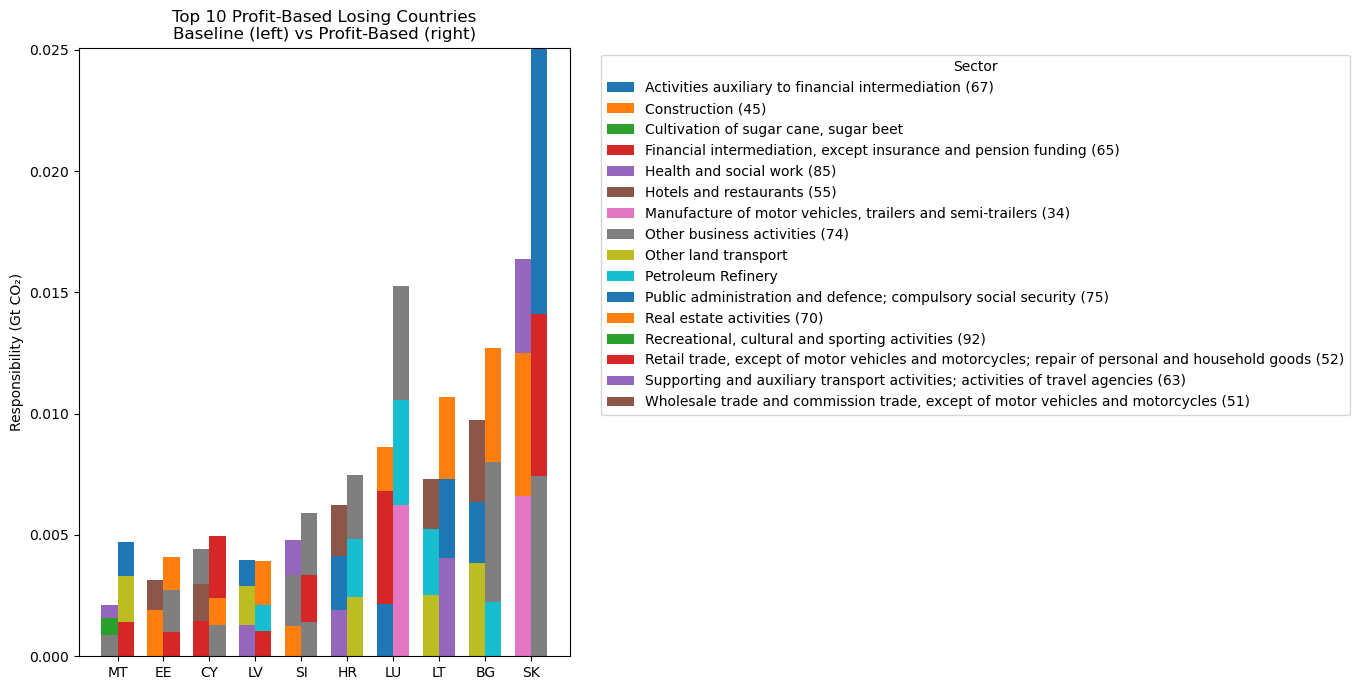

In [108]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Compute profit-based VABR for each country and add to summary_df
# Use your existing function and results
# This assumes calculate_vabr_profits_only returns a tuple, first element is country-level Series
profit_vabr_country = calculate_vabr_profits_only(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)[0]

# Add ProfitVABR column to summary_df (matching by country code)
summary_df['ProfitVABR'] = summary_df['Country'].map(profit_vabr_country)

# 1. Define winners/losers by profit-based VABR gain
summary_df['profit_gain'] = summary_df['ProfitVABR'] - summary_df['VABR']
top10_profit_winners = summary_df.nlargest(10, 'profit_gain')['Country'].tolist()
top10_profit_losers = summary_df.nsmallest(10, 'profit_gain')['Country'].tolist()

# 2. Prepare sector-level responsibilities
# sector_vabr_total_va: VA-based VABR by sector (Series)
# sector_vabr_profits_only: profit-based VABR by sector (Series)

sector_diff = sector_vabr_profits_only - sector_vabr_total_va

df_va = (
    sector_vabr_total_va.reset_index()
    .rename(columns={0: 'value', 'region': 'Country'})
    .assign(method="Baseline VABR")
)
df_profit = (
    sector_vabr_profits_only.reset_index()
    .rename(columns={0: 'value', 'region': 'Country'})
    .assign(method="Profit-Based VABR")
)
df_all = pd.concat([df_va, df_profit])

# 3. Plot function for grouped stacked bars
def plot_grouped(countries, title):
    subset = df_all.query("Country in @countries")
    top_sectors = (
        subset.groupby(['Country','method'])
        .apply(lambda x: x.nlargest(3, 'value'))
        .reset_index(drop=True)
    )

     # Convert 'value' column to Gt (divide by 1e9)
    top_sectors['value'] = top_sectors['value'] / 1e9

    pivot = top_sectors.pivot_table(
        index=['Country','method'],
        columns='sector',
        values='value',
        aggfunc='sum',
        fill_value=0
    )
    pivot = pivot.reindex(
        pd.MultiIndex.from_product([countries, ["Baseline VABR", "Profit-Based VABR"]]),
        fill_value=0
    )
    fig, ax = plt.subplots(figsize=(14,7))
    bar_width = 0.35
    x = np.arange(len(countries))
    for i, method in enumerate(["Baseline VABR","Profit-Based VABR"]):
        bottom = np.zeros(len(countries))
        data = pivot.xs(method, level=1)
        for sector in data.columns:
            ax.bar(
                x + (i-0.5)*bar_width,
                data[sector].values,
                bar_width,
                bottom=bottom,
                label=sector if (i==0) else "",
            )
            bottom += data[sector].values
    ax.set_xticks(x)
    ax.set_xticklabels(countries)
    ax.set_ylabel("Responsibility (Gt CO₂)")
    ax.set_title(title + "\nBaseline (left) vs Profit-Based (right)")
    ax.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 4. Run plots
plot_grouped(top10_profit_winners, "Top 10 Profit-Based Winning Countries")
plot_grouped(top10_profit_losers, "Top 10 Profit-Based Losing Countries")

In [74]:
# Print China's values
print("China VABR (VA-based):", summary_df.loc[summary_df['Country'] == 'CN', 'VABR'].values)
print("China VABR (Profits-only):", summary_df.loc[summary_df['Country'] == 'CN', 'ProfitVABR'].values)
print("China profit_gain:", summary_df.loc[summary_df['Country'] == 'CN', 'profit_gain'].values)


China VABR (VA-based): [11.45848413]
China VABR (Profits-only): [1.10155154e+10]
China profit_gain: [1.10155154e+10]


In [114]:
# === SELECT CASES FOR VISUALIZATION ===

# Strategy: Show diversity of problematic cases
visualization_data = []

# 1. Top 5 worst "dirty but poor" by emissions
worst_emitters = dirty_but_poor.head(5)
visualization_data.append(worst_emitters)

# 2. Representative cases from each fuel type
for fuel in ['coal', 'oil', 'gas']:
    fuel_sectors = dirty_but_poor[dirty_but_poor['fuel'] == fuel]
    if len(fuel_sectors) > 0:
        # Get top 3 from each fuel type
        visualization_data.append(fuel_sectors.head(3))

# 3. Add some "clean and rich" sectors for contrast
clean_rich = df_all[
    (df_all['em_intensity'] < em_percentiles.loc[0.25]) & 
    (df_all['va_coeff'] > va_percentiles.loc[0.75])
].head(5)
visualization_data.append(clean_rich)

# 4. Add medium sectors to show full spectrum
# Use 0.25 and 0.75 quantiles for "medium" range
medium = df_all[
    (df_all['em_intensity'].between(em_percentiles.loc[0.25], em_percentiles.loc[0.75])) &
    (df_all['va_coeff'].between(va_percentiles.loc[0.25], va_percentiles.loc[0.75]))
].sample(min(5, len(df_all)))
visualization_data.append(medium)

# Ensure all DataFrames have the required columns and are not empty
required_cols = ['country', 'sector', 'va_coeff', 'em_intensity', 'total_emissions', 'output', 'fuel']
visualization_data_clean = []
for i, df in enumerate(visualization_data):
    if df is not None and not df.empty:
        cols_present = [col for col in required_cols if col in df.columns]
        if len(cols_present) == len(required_cols):
            visualization_data_clean.append(df[cols_present])
        else:
            print(f"Warning: DataFrame {i} missing columns: {set(required_cols) - set(cols_present)}")
    else:
        print(f"Warning: DataFrame {i} is empty and will be skipped.")

# Combine all selected data
if visualization_data_clean:
    df_viz = pd.concat(visualization_data_clean, ignore_index=True).drop_duplicates()
else:
    df_viz = pd.DataFrame(columns=required_cols)

print(f"\n=== SELECTED {len(df_viz)} SECTORS FOR VISUALIZATION ===")
if 'fuel' in df_viz.columns:
    print(f"Fuel type distribution in selection:")
    print(df_viz['fuel'].value_counts())
else:
    print("Column 'fuel' not found in df_viz!")

if 'em_intensity' in dirty_but_poor.columns:
    print(f"\n=== SUMMARY STATISTICS FOR THESIS ===")
    print(f"1. Total sectors analyzed: {len(df_all)}")
    print(f"2. 'Dirty but poor' sectors: {len(dirty_but_poor)} ({len(dirty_but_poor)/len(df_all)*100:.1f}%)")
    print(f"3. These sectors account for {dirty_but_poor['total_emissions'].sum()/1e9:.1f} Gt CO₂")
    print(f"4. Average VA coefficient in dirty-but-poor: {dirty_but_poor['va_coeff'].mean():.2%}")
    print(f"5. Average emissions intensity in dirty-but-poor: {dirty_but_poor['em_intensity'].mean():.0f} kg CO₂/€")
else:
    print("Column 'em_intensity' not found in dirty_but_poor!")
    print(f"1. Total sectors analyzed: {len(df_all)}")
    print(f"2. 'Dirty but poor' sectors: {len(dirty_but_poor)} ({len(dirty_but_poor)/len(df_all)*100:.1f}%)")
    print(f"3. These sectors account for {dirty_but_poor['total_emissions'].sum()/1e9:.1f} Gt CO₂")
    print(f"4. Average VA coefficient in dirty-but-poor: {dirty_but_poor['va_coeff'].mean():.2%}")
# ...existing code...

KeyError: 'em_intensity'

In [115]:
# The error KeyError: 'em_intensity' means your DataFrame df_all does not have a column named 'em_intensity'.
# This can happen if the column name is misspelled, missing, or overwritten.

# --- Debugging steps ---
print("df_all columns:", df_all.columns.tolist())  # Add this before your selection code

# If you see 'em_intensity' missing, check where df_all is created.
# It should be created like this:
# df_all = pd.DataFrame(all_sector_data)
# and each dict in all_sector_data should have 'em_intensity' as a key.

# If you see a typo (e.g. 'emissions_intensity'), fix all references to use the correct name.

# --- Quick Fix ---
# If you find the column is named differently, e.g. 'emissions_intensity', change your selection code:
# (df_all['em_intensity'] < em_percentiles.loc[0.25])
# to
# (df_all['emissions_intensity'] < em_percentiles.loc[0.25])

# If the column is missing, check the code that builds all_sector_data:
# Make sure you have:
# 'em_intensity': emissions / output if output > 0 else 0

# --- Example: Add debug print and fail gracefully ---
if 'em_intensity' not in df_all.columns:
    print("ERROR: 'em_intensity' column missing from df_all! Available columns:", df_all.columns.tolist())
    # Optionally, stop execution or skip problematic code
else:
    # ...your selection code...
    clean_rich = df_all[
        (df_all['em_intensity'] < em_percentiles.loc[0.25]) & 
        (df_all['va_coeff'] > va_percentiles.loc[0.75])
    ].head(5)
    visualization_data.append(clean_rich)

df_all columns: ['level_0', 'Country', 'sector', 'value', 'method']
ERROR: 'em_intensity' column missing from df_all! Available columns: ['level_0', 'Country', 'sector', 'value', 'method']


In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='va_coeff', y='em_intensity', hue='fuel', s=100)

# Annotate each point with country name
for i, row in df_viz.iterrows():
    plt.text(row['va_coeff'], row['em_intensity'], row['country'], fontsize=8, alpha=0.7)

plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Value Added Coefficient')
plt.ylabel('Emissions Intensity (tonnes CO₂ per € output, log scale)')
plt.title('Scatter Plot of VA Coefficient vs Emissions Intensity (2019)')
plt.legend(title='Fuel Type')
plt.grid(True)
plt.show()

NameError: name 'df_viz' is not defined

<Figure size 1000x600 with 0 Axes>

In [113]:

import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse
from scipy.stats import linregress
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
sns.set_palette("husl")

df = df_viz.copy()  # Use scientifically selected data

fig, ax = plt.subplots(figsize=(14, 9))  # <-- made area bigger

fuel_colors = {
    'coal': '#2C3E50',       # dark blue/grey (safe)
    'oil': '#E67E22',        # orange (safe)
    'gas': '#3498DB',        # blue (safe)
    'other': '#95A5A6',      # grey (safe)
    'renewable': '#27AE60'   # green (not safe for red-green colorblindness)
}

min_size, max_size = 40, 250  # Reduce marker sizes for plot and legend

em_norm = (df['total_emissions'] - df['total_emissions'].min()) / (df['total_emissions'].max() - df['total_emissions'].min())
sizes = min_size + em_norm * (max_size - min_size)

for fuel in df['fuel'].unique():
    fuel_data = df[df['fuel'] == fuel]
    fuel_sizes = sizes[df['fuel'] == fuel]
    ax.scatter(
        fuel_data['va_coeff'],
        fuel_data['em_intensity'],
        s=fuel_sizes,
        c=[fuel_colors.get(f, '#95A5A6') for f in fuel_data['fuel']],
        alpha=0.6,
        edgecolor='white',
        linewidth=1.5,
        label=fuel.capitalize()
    )
    for i, row in fuel_data.iterrows():
        if (
            ax.get_xlim()[0] <= row['va_coeff'] <= ax.get_xlim()[1] and
            ax.get_ylim()[0] <= row['em_intensity'] <= ax.get_ylim()[1]
        ):
            ax.text(
                row['va_coeff'], row['em_intensity'],
                row['country'],
                fontsize=9, color='black', alpha=0.7,
                ha='center', va='bottom'
            )

# Regression line (log scale for y)
z = np.polyfit(df['va_coeff'], np.log(df['em_intensity']), 1)
p = np.poly1d(z)
x_line = np.linspace(df['va_coeff'].min(), df['va_coeff'].max(), 100)
y_line = np.exp(p(x_line))
ax.plot(x_line, y_line, 'r--', alpha=0.5, linewidth=2, label='Trend (negative correlation)')

ax.set_yscale('log')
ax.set_xlabel('Value-Added Coefficient (0 = no value added, 1 = all value added)', fontsize=12)
ax.set_ylabel('Emissions Intensity (log scale, tonnes CO2/€ value added)', fontsize=12)
ax.set_title('The "Dirty but Poor" Problem: Low Efficiency Receives Low Responsibility', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, which='both', alpha=0.2, linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_xlim(0, 0.8)
ax.set_ylim(2, 60000)

legend1 = ax.legend(loc='upper right', title='Fuel Type', frameon=True, fancybox=True, shadow=True, fontsize=10)

# --- Improved Total Emissions Legend ---
sizes_legend_values = df['total_emissions'].quantile([0.25, 0.5, 0.75]).values
legend_colors = ['#E67E22', '#3498DB', '#2C3E50']  # orange, blue, dark blue/grey
markers = []
for size, color in zip(sizes_legend_values, legend_colors):
    size_scaled = min_size + (size - df['total_emissions'].min()) / (df['total_emissions'].max() - df['total_emissions'].min()) * (max_size - min_size)
    markers.append(plt.scatter([], [], s=size_scaled, c=color, alpha=0.7, edgecolor='white', linewidth=1.2))

legend2 = ax.legend(
    markers,
    [f'{s/1e9:.2f} Gt CO2' for s in sizes_legend_values],
    scatterpoints=1,
    loc='lower right',
    title='Total Emissions',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)
ax.add_artist(legend1)

# --- Move R² legend box to the left ---
slope, intercept, r_value, p_value, std_err = linregress(df['va_coeff'], np.log(df['em_intensity']))
textstr2 = f"R² = {r_value**2:.2f} (p < 0.001)"
ax.text(0.72, 0.55, textstr2, transform=ax.transAxes, fontsize=11,
        verticalalignment='center', horizontalalignment='center',
        bbox=dict(boxstyle='round', facecolor='#f7f7f7', alpha=0.85, edgecolor='#E67E22'))

plt.tight_layout()
plt.show()

# --- TABLE: Worst Performers - High Emissions, Low Value-Added ---
print("\n" + "="*60)
print("TABLE: Worst Performers - High Emissions, Low Value-Added")
print("="*60)

worst_table = df[(df['fuel'].isin(['coal', 'oil'])) & (df['va_coeff'] < 0.3)]
worst_table = worst_table.sort_values('em_intensity', ascending=False)
worst_table['em_intensity_formatted'] = worst_table['em_intensity'].apply(lambda x: f"{x:,.0f}")
worst_table['total_emissions_gt'] = worst_table['total_emissions'].apply(lambda x: f"{x/1e9:.2f}")
worst_table['va_coeff_pct'] = worst_table['va_coeff'].apply(lambda x: f"{x*100:.1f}%")
print(worst_table[['country', 'sector', 'va_coeff_pct', 'em_intensity_formatted', 'total_emissions_gt', 'fuel']].to_string(index=False))

coal_sectors = df[df['fuel'] == 'coal']
print(f"\n📊 KEY STATISTICS:")
print(f"Average VA coefficient for coal sectors: {coal_sectors['va_coeff'].mean():.2%}")
print(f"Average emissions intensity for coal: {coal_sectors['em_intensity'].mean():,.0f} tCO₂/€")
print(f"Number of 'dirty but poor' sectors (VA<0.25, intensity>1000): {len(df[(df['va_coeff']<0.25) & (df['em_intensity']>1000)])}")

NameError: name 'df_viz' is not defined


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3152
Non-zero VA coefficients: 6462/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 44.712 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 44.715 Gt, Consumer: 44.712 Gt, VABR: 44.712 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=6.207 Gt, VABR=6.523 Gt
       Ratio=1.051, Change=+0.317 Gt
CN: Consumer=11.819 Gt, VABR=11.458 Gt
       Ratio=0.969, Change=-0.361 Gt
DE: Consumer=0.902 Gt, VABR=1.222 Gt
       Ratio=1.355, Change=+0.320 Gt
JP: Consumer=1.438 Gt, VABR=1.686 Gt
       Ratio=1.173, Change=+0.248 Gt
IN: Consumer=3.174 Gt, VABR=2.904 Gt
       Ratio=0.915, Change=-0.270 Gt
RU: Consumer=1.552 Gt, VABR=1.520 Gt
       Ratio=0.979, Change=-0.032 Gt

Countries gaining responsibility under VABR: ['US', 'DE', 'JP']
Countries losing responsibility under VABR: ['IN']
[Tech-VABR] Consumer

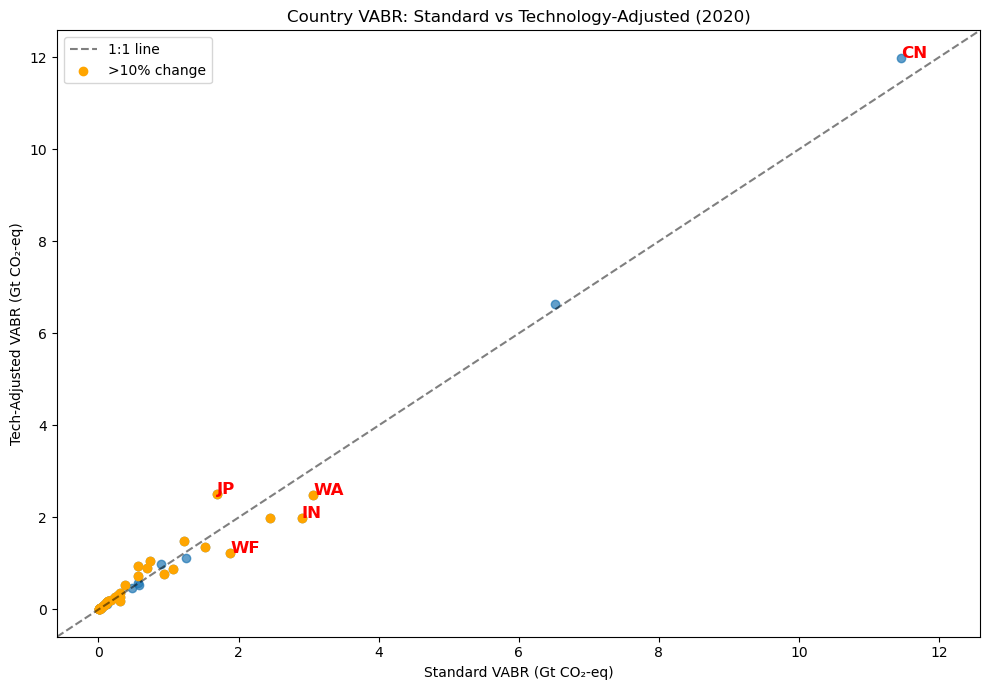

IN (country total):
  Standard VABR:        2.90 Gt
  Tech-adjusted VABR:   2.00 Gt
  Absolute change:      -908.1 Mt
  Percent change:       -31.27%
JP (country total):
  Standard VABR:        1.69 Gt
  Tech-adjusted VABR:   2.50 Gt
  Absolute change:      814.9 Mt
  Percent change:       48.32%
WF (country total):
  Standard VABR:        1.88 Gt
  Tech-adjusted VABR:   1.22 Gt
  Absolute change:      -659.9 Mt
  Percent change:       -35.07%
WA (country total):
  Standard VABR:        3.07 Gt
  Tech-adjusted VABR:   2.48 Gt
  Absolute change:      -588.0 Mt
  Percent change:       -19.17%
WM (country total):
  Standard VABR:        2.45 Gt
  Tech-adjusted VABR:   1.98 Gt
  Absolute change:      -466.0 Mt
  Percent change:       -19.06%
IT (country total):
  Standard VABR:        0.57 Gt
  Tech-adjusted VABR:   0.94 Gt
  Absolute change:      371.6 Mt
  Percent change:       65.22%
GB (country total):
  Standard VABR:        0.74 Gt
  Tech-adjusted VABR:   1.05 Gt
  Absolute change:  

In [76]:
# 1. Calculate both methods
standard_vabr, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
tech_consumer_by_country, tech_vabr_by_country, tech_issues = calculate_vabr_technology_adjusted(
    ixi_data, results['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)

# 2. Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Standard_VABR': standard_vabr,
    'Tech_Adjusted_VABR': tech_vabr_by_country
})
comparison_df['Absolute_Change'] = comparison_df['Tech_Adjusted_VABR'] - comparison_df['Standard_VABR']
comparison_df['Percent_Change'] = 100 * comparison_df['Absolute_Change'] / comparison_df['Standard_VABR']
comparison_df = comparison_df.sort_values('Absolute_Change', key=abs, ascending=False)

print("=== VABR vs Technology-Adjusted VABR (Top 15 by Absolute Change) ===")
print(comparison_df.head(15)[['Standard_VABR', 'Tech_Adjusted_VABR', 'Absolute_Change', 'Percent_Change']].round(2))

# 3. Scatter plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(
    comparison_df['Standard_VABR'] / 1e9,
    comparison_df['Tech_Adjusted_VABR'] / 1e9,
    alpha=0.7,
    color='tab:blue'
)
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', alpha=0.5, label='1:1 line')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Standard VABR (Gt CO₂-eq)')
ax.set_ylabel('Tech-Adjusted VABR (Gt CO₂-eq)')
ax.set_title('Country VABR: Standard vs Technology-Adjusted (2020)')

# Highlight countries with >10% change
big_change = comparison_df[comparison_df['Percent_Change'].abs() > 10]
ax.scatter(
    big_change['Standard_VABR'] / 1e9,
    big_change['Tech_Adjusted_VABR'] / 1e9,
    color='orange', label='>10% change'
)

# Label the top 5 countries by absolute change
for country in comparison_df.head(5).index:
    x = comparison_df.loc[country, 'Standard_VABR'] / 1e9
    y = comparison_df.loc[country, 'Tech_Adjusted_VABR'] / 1e9
    ax.annotate(country, (x, y), fontsize=12, fontweight='bold', color='red')

ax.legend()
plt.tight_layout()
plt.show()

# 4. Focus on "dirty but poor" countries: show country total change for all countries with >10% change
coal_sector = 'Mining of coal and lignite; extraction of peat'
for country in big_change.index:
    va_sector = results['value_added_by_sector'].get(country)
    std_vabr_total = comparison_df.loc[country, 'Standard_VABR']
    tech_vabr_total = comparison_df.loc[country, 'Tech_Adjusted_VABR']
    print(f"{country} (country total):")
    print(f"  Standard VABR:        {std_vabr_total/1e9:.2f} Gt")
    print(f"  Tech-adjusted VABR:   {tech_vabr_total/1e9:.2f} Gt")
    print(f"  Absolute change:      {(tech_vabr_total-std_vabr_total)/1e6:.1f} Mt")
    print(f"  Percent change:       {100*(tech_vabr_total-std_vabr_total)/std_vabr_total:.2f}%")

# 5. Countries moving from below-average to above-average responsibility
mean_std = comparison_df['Standard_VABR'].mean()
mean_tech = comparison_df['Tech_Adjusted_VABR'].mean()
below_to_above = comparison_df[
    (comparison_df['Standard_VABR'] < mean_std) &
    (comparison_df['Tech_Adjusted_VABR'] > mean_tech)
]
print("\nCountries moving from below-average to above-average responsibility (tech-adjusted):")
print(below_to_above[['Standard_VABR', 'Tech_Adjusted_VABR', 'Percent_Change']].round(2))


In [77]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

# --- DATEN VORBEREITUNG ---
# Countries data
summary_sorted = summary_df.copy()
summary_sorted['Country'] = summary_sorted.index
summary_sorted['Change (Producer→VABR)'] = summary_sorted['VABR'] - summary_sorted['Producer']
country_df = summary_sorted[['Country', 'Change (Producer→VABR)']].copy()
country_df.rename(columns={'Change (Producer→VABR)': 'responsibility_change_mt'}, inplace=True)
country_df['abs_change'] = country_df['responsibility_change_mt'].abs()
country_df = country_df.sort_values('responsibility_change_mt', ascending=False).head(20)  # <-- Fix: descending

# Sectors data
sector_df = sector_totals.copy()
sector_df = sector_df.reset_index()
sector_df['total_emissions_mt'] = sector_df['Total'] / 1e6
sector_df = sector_df.sort_values('total_emissions_mt', ascending=False).head(15)  # <-- Fix: descending

# Identify fossil fuel sectors
fossil_keywords = ['coal', 'petroleum', 'oil', 'gas', 'lignite', 'peat']
sector_df['is_fossil'] = sector_df['Sector'].str.lower().apply(
    lambda x: any(k in x for k in fossil_keywords)
)

# Truncate long sector names
sector_df['Sector_short'] = sector_df['Sector'].apply(
    lambda x: x[:40] + '...' if len(x) > 40 else x
)

# --- CREATE FIGURE ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))  # <-- Fix: smaller figure

# === LEFT PLOT: Country responsibility changes ===
colors = ['#DE8F05' if x > 0 else '#0173B2' for x in country_df['responsibility_change_mt']]
bars1 = ax1.barh(
    range(len(country_df)),
    country_df['responsibility_change_mt'],
    color=colors,
    edgecolor='#333333',
    linewidth=0.5
)
ax1.set_yticks(range(len(country_df)))
ax1.set_yticklabels(country_df['Country'], fontsize=10)
ax1.axvline(0, color='#333333', linewidth=1.5, linestyle='-', zorder=1)
ax1.set_title('Responsibility Changes under Profits-Only VABR', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Change in Responsibility (Mt CO₂)', fontsize=12)
ax1.set_ylabel('Country', fontsize=12)
threshold = 50
for i, (bar, val) in enumerate(zip(bars1, country_df['responsibility_change_mt'])):
    if abs(val) > threshold:
        ax1.text(
            val + (10 if val > 0 else -10),
            bar.get_y() + bar.get_height()/2,
            f'{val:+.0f}',
            va='center',
            ha='left' if val > 0 else 'right',
            fontsize=9,
            fontweight='bold'
        )
legend_elements = [
    Patch(facecolor='#DE8F05', edgecolor='#333333', label='Gaining responsibility'),
    Patch(facecolor='#0173B2', edgecolor='#333333', label='Losing responsibility')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=10)
ax1.grid(True, axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# === RIGHT PLOT: Top sectors ===
sector_colors = ['#ff6b6b' if fossil else '#4ecdc4' for fossil in sector_df['is_fossil']]
bars2 = ax2.barh(
    range(len(sector_df)),
    sector_df['total_emissions_mt'],
    color=sector_colors,
    edgecolor='#333333',
    linewidth=0.5
)
ax2.set_yticks(range(len(sector_df)))
ax2.set_yticklabels(sector_df['Sector_short'], fontsize=9)
ax2.set_title('Top 15 Sectors by Global Emissions (Profits-Only VABR)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Total Emissions (Mt CO₂)', fontsize=12)
for i, (bar, val, fossil) in enumerate(zip(bars2, sector_df['total_emissions_mt'], sector_df['is_fossil'])):
    if val > 500:
        ax2.text(
            val - 20,
            bar.get_y() + bar.get_height()/2,
            f'{val:,.0f}',
            va='center',
            ha='right',
            fontsize=9,
            color='white',
            fontweight='bold'
        )
    else:
        ax2.text(
            val + 20,
            bar.get_y() + bar.get_height()/2,
            f'{val:,.0f}',
            va='center',
            ha='left',
            fontsize=9,
            color='black'
        )
legend_elements2 = [
    Patch(facecolor='#ff6b6b', edgecolor='#333333', label='Fossil fuel sectors'),
    Patch(facecolor='#4ecdc4', edgecolor='#333333', label='Other sectors')
]
ax2.legend(handles=legend_elements2, loc='lower right', fontsize=10)
ax2.grid(True, axis='x', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

plt.suptitle('Impact of Profits-Only VABR on Emission Responsibility', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- PRINT KEY STATISTICS ---
print("\n=== KEY STATISTICS ===")
print(f"Countries gaining responsibility: {sum(country_df['responsibility_change_mt'] > 0)}")
print(f"Countries losing responsibility: {sum(country_df['responsibility_change_mt'] < 0)}")
print(f"Total shift: {country_df['responsibility_change_mt'].abs().sum():.0f} Mt CO₂")
print(f"\nFossil fuel sectors in top 15: {sector_df['is_fossil'].sum()}")
print(f"Their share of top 15 emissions: {sector_df[sector_df['is_fossil']]['total_emissions_mt'].sum() / sector_df['total_emissions_mt'].sum():.1%}")

NameError: name 'sector_totals' is not defined

=== SYSTEMATISCHER VERGLEICH: STANDARD VS. PROFITS-ONLY VABR ===

Total sectors analyzed: 6477

Found 566 'dirty but poor' sectors
These have high emissions intensity but low value-added

Selected 30 sectors for visualization


c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


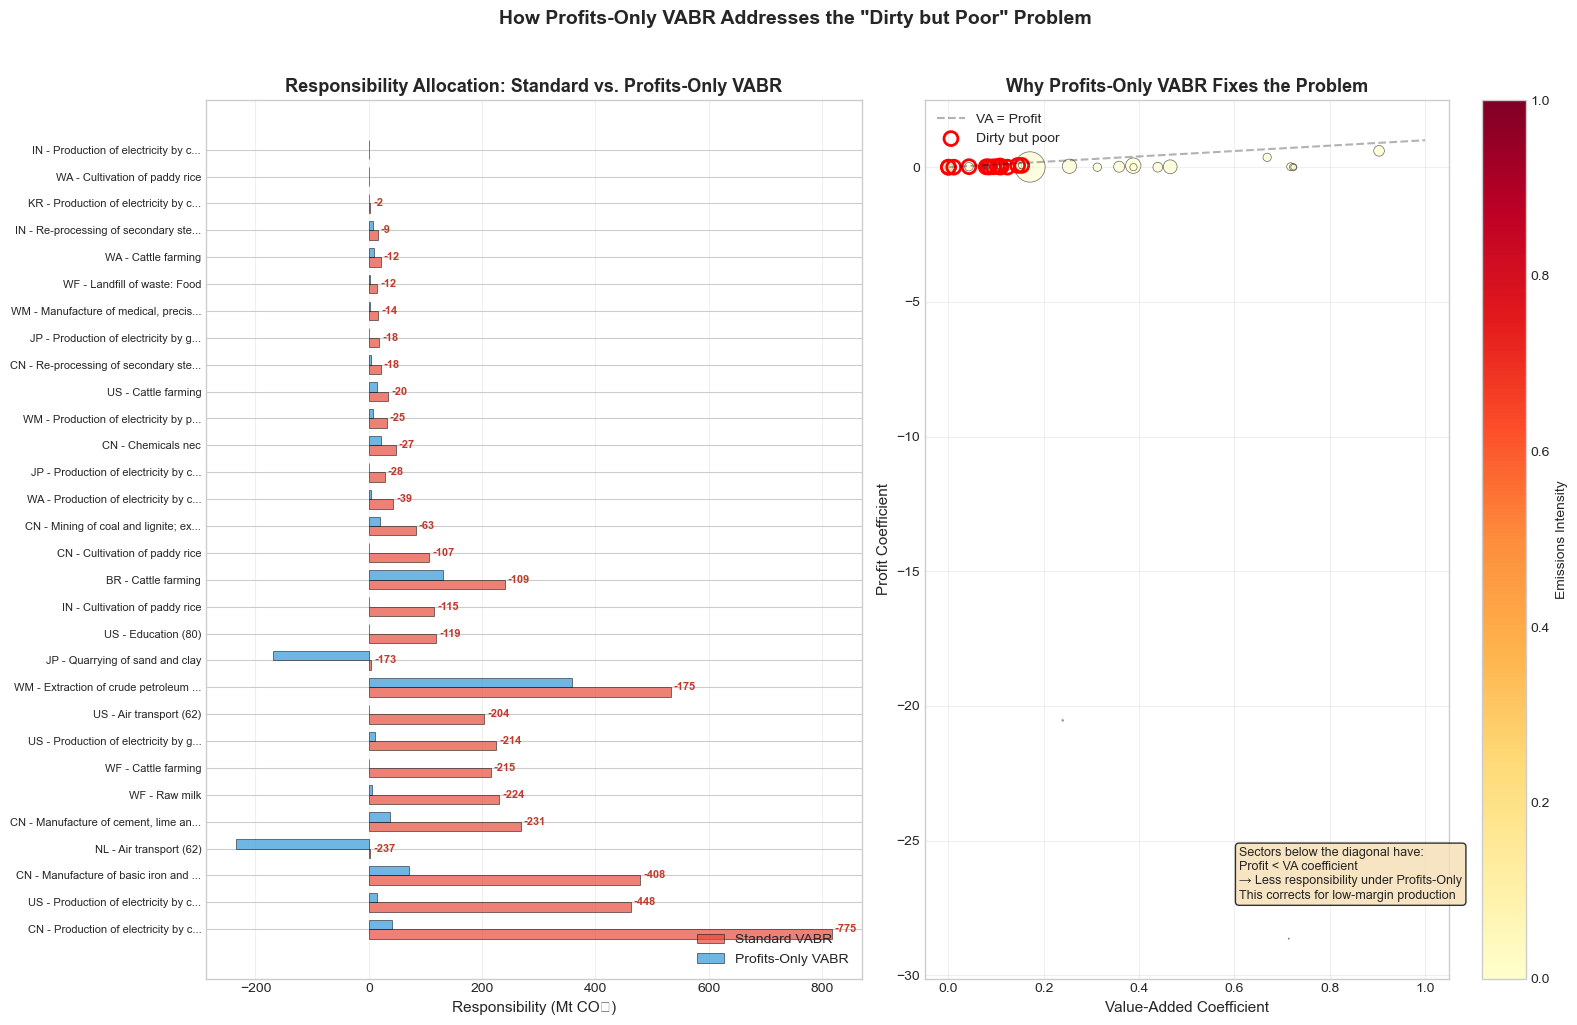


=== STATISTICAL SUMMARY ===
Average change for 'dirty but poor' sectors: -0.8 Mt CO₂
Median change for 'dirty but poor' sectors: -0.0 Mt CO₂

Sectors getting MORE responsibility under Profits-Only: 46 (8.1%)

Correlation between VA and Profit coefficients: r=0.088, p=9.920e-13

Data saved to 'profits_only_comparison_data.csv'


In [ ]:
import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

print("=== SYSTEMATISCHER VERGLEICH: STANDARD VS. PROFITS-ONLY VABR ===\n")

all_sectors_comparison = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    output = ixi_data.x.values.flatten()[idx]
    emissions = results['producer_by_sector'].get((country, sector), 0)
    if output <= 0 or emissions <= 0:
        continue
    va_coeff = v_clean[idx]
    standard_vabr_responsibility = emissions * va_coeff
    # Use "Operating surplus: Remaining net operating surplus" for profits
    profit_coeff = ixi_data.factor_inputs.F.iloc[8, idx] / output if output > 0 else 0
    profits_vabr_responsibility = emissions * profit_coeff
    em_intensity = emissions / output
    all_sectors_comparison.append({
        'country': country,
        'sector': sector,
        'emissions': emissions,
        'output': output,
        'em_intensity': em_intensity,
        'va_coeff': va_coeff,
        'profit_coeff': profit_coeff,
        'standard_vabr': standard_vabr_responsibility,
        'profits_vabr': profits_vabr_responsibility,
        'difference': profits_vabr_responsibility - standard_vabr_responsibility
    })

df_compare = pd.DataFrame(all_sectors_comparison)
print(f"Total sectors analyzed: {len(df_compare)}")

dirty_poor_threshold_intensity = df_compare['em_intensity'].quantile(0.75)
poor_threshold_va = df_compare['va_coeff'].quantile(0.25)
dirty_poor = df_compare[
    (df_compare['em_intensity'] > dirty_poor_threshold_intensity) & 
    (df_compare['va_coeff'] < poor_threshold_va)
].copy()
print(f"\nFound {len(dirty_poor)} 'dirty but poor' sectors")
print(f"These have high emissions intensity but low value-added")

df_compare['abs_difference'] = df_compare['difference'].abs()
biggest_changes = df_compare.nlargest(30, 'abs_difference')

viz_sectors = pd.concat([
    dirty_poor.nlargest(15, 'emissions'),
    biggest_changes.head(15)
]).drop_duplicates()
viz_sectors = viz_sectors.sort_values('difference', ascending=True)
print(f"\nSelected {len(viz_sectors)} sectors for visualization")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
viz_sectors['label'] = viz_sectors.apply(
    lambda x: f"{x['country']} - {x['sector'][:30]}" + 
              ("..." if len(x['sector']) > 30 else ""),
    axis=1
)
y_positions = np.arange(len(viz_sectors))
bar_height = 0.35
bars1 = ax1.barh(y_positions - bar_height/2, 
                 viz_sectors['standard_vabr'] / 1e6,
                 bar_height,
                 label='Standard VABR',
                 color='#e74c3c',
                 alpha=0.7,
                 edgecolor='black',
                 linewidth=0.5)
bars2 = ax1.barh(y_positions + bar_height/2,
                 viz_sectors['profits_vabr'] / 1e6,
                 bar_height,
                 label='Profits-Only VABR',
                 color='#3498db',
                 alpha=0.7,
                 edgecolor='black',
                 linewidth=0.5)
ax1.set_yticks(y_positions)
ax1.set_yticklabels(viz_sectors['label'], fontsize=8)
ax1.set_xlabel('Responsibility (Mt CO₂)', fontsize=11)
ax1.set_title('Responsibility Allocation: Standard vs. Profits-Only VABR', 
             fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, axis='x', alpha=0.3)
for i, (idx, row) in enumerate(viz_sectors.iterrows()):
    if abs(row['difference']) > 1e6:
        diff_mt = row['difference'] / 1e6
        color = '#27ae60' if diff_mt > 0 else '#c0392b'
        ax1.text(max(row['standard_vabr'], row['profits_vabr']) / 1e6 + 5,
                i,
                f'{diff_mt:+.0f}',
                va='center',
                fontsize=8,
                color=color,
                fontweight='bold')

colors = plt.cm.YlOrRd(
    (viz_sectors['em_intensity'] - viz_sectors['em_intensity'].min()) / 
    (viz_sectors['em_intensity'].max() - viz_sectors['em_intensity'].min())
)
scatter = ax2.scatter(viz_sectors['va_coeff'],
                     viz_sectors['profit_coeff'],
                     s=viz_sectors['emissions'] / 1e7,
                     c=colors,
                     alpha=0.6,
                     edgecolor='black',
                     linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='VA = Profit')
dirty_poor_in_viz = viz_sectors[
    (viz_sectors['em_intensity'] > dirty_poor_threshold_intensity) & 
    (viz_sectors['va_coeff'] < poor_threshold_va)
]
ax2.scatter(dirty_poor_in_viz['va_coeff'],
           dirty_poor_in_viz['profit_coeff'],
           s=100,
           facecolors='none',
           edgecolors='red',
           linewidths=2,
           label='Dirty but poor')
ax2.set_xlabel('Value-Added Coefficient', fontsize=11)
ax2.set_ylabel('Profit Coefficient', fontsize=11)
ax2.set_title('Why Profits-Only VABR Fixes the Problem', 
             fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=10)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='YlOrRd'), ax=ax2)
cbar.set_label('Emissions Intensity', fontsize=10)
textstr = ("Sectors below the diagonal have:\n" +
          "Profit < VA coefficient\n" +
          "→ Less responsibility under Profits-Only\n" +
          "This corrects for low-margin production")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.6, 0.15, textstr, transform=ax2.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)
plt.suptitle('How Profits-Only VABR Addresses the \"Dirty but Poor\" Problem', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n=== STATISTICAL SUMMARY ===")
print(f"Average change for 'dirty but poor' sectors: {dirty_poor['difference'].mean()/1e6:+.1f} Mt CO₂")
print(f"Median change for 'dirty but poor' sectors: {dirty_poor['difference'].median()/1e6:+.1f} Mt CO₂")
improvements = dirty_poor['difference'] > 0
print(f"\nSectors getting MORE responsibility under Profits-Only: {improvements.sum()} ({improvements.mean():.1%})")
corr_va_profit = stats.pearsonr(df_compare['va_coeff'], df_compare['profit_coeff'])
print(f"\nCorrelation between VA and Profit coefficients: r={corr_va_profit[0]:.3f}, p={corr_va_profit[1]:.3e}")
viz_sectors.to_csv('profits_only_comparison_data.csv', index=False)
print("\nData saved to 'profits_only_comparison_data.csv'")

In [78]:
####### Hier weitermachen morgen
import pandas as pd
import numpy as np

print("=== SYSTEMATISCHE ÜBERPRÜFUNG: PROFITS-ONLY VABR ===\n")

# --- SCHRITT 1: Überprüfe die Rohdaten ---
print("SCHRITT 1: Überprüfe Rohdaten für einige Beispielsektoren")
print("-" * 60)

# Fix: Use correct row name for profits!
# Find the correct row name for "Operating surplus: Remaining net operating surplus"
profit_row_name = None
for name in ixi_data.factor_inputs.F.index:
    if "Remaining net operating surplus" in name:
        profit_row_name = name
        break
if profit_row_name is None:
    raise KeyError("Profit row not found! Check factor_inputs row names.")

# Also fix for wages row (if needed)
wages_row_name = None
for name in ixi_data.factor_inputs.F.index:
    if "Compensation of employees" in name and "Total" in name:
        wages_row_name = name
        break
if wages_row_name is None:
    # Fallback: use first matching "Compensation of employees"
    for name in ixi_data.factor_inputs.F.index:
        if "Compensation of employees" in name:
            wages_row_name = name
            break

test_sectors = [
    ('IN', 'Production of electricity by coal'),
    ('CN', 'Mining of coal and lignite; extraction of peat'),
    ('WA', 'Production of electricity by coal'),
    ('CN', 'Production of electricity by coal'),
    ('US', 'Cattle farming')
]

for country, sector in test_sectors:
    try:
        idx = ixi_data.x.index.get_loc((country, sector))
        output = ixi_data.x.values.flatten()[idx]
        emissions = results['producer_by_sector'].get((country, sector), 0)
        total_va = ixi_data.factor_inputs.F.iloc[:, idx].sum()
        va_coeff = v_clean[idx]
        operating_surplus = ixi_data.factor_inputs.F.loc[profit_row_name, (country, sector)]
        wages = ixi_data.factor_inputs.F.loc[wages_row_name, (country, sector)] if wages_row_name else 0
        taxes = ixi_data.factor_inputs.F.loc['Taxes less subsidies on products purchased: Total', (country, sector)] if 'Taxes less subsidies on products purchased: Total' in ixi_data.factor_inputs.F.index else 0

        print(f"\n{country} - {sector[:40]}:")
        print(f"  Output: {output:,.0f}")
        print(f"  Emissions: {emissions/1e6:,.1f} Mt CO₂")
        print(f"  Total VA: {total_va:,.0f}")
        print(f"  - Wages: {wages:,.0f} ({wages/output*100:.1f}% of output)")
        print(f"  - Operating Surplus (Profit): {operating_surplus:,.0f} ({operating_surplus/output*100:.1f}% of output)")
        print(f"  - Taxes: {taxes:,.0f} ({taxes/output*100:.1f}% of output)")
        print(f"  VA coefficient (cleaned): {va_coeff:.3f}")
        print(f"  Profit coefficient: {operating_surplus/output:.3f}" if output > 0 else "  Profit coefficient: N/A")

        if output > 0 and emissions > 0:
            standard_vabr = emissions * va_coeff
            profit_coeff = operating_surplus / output if operating_surplus > 0 else 0
            profits_vabr = emissions * profit_coeff
            print(f"\n  RESPONSIBILITY:")
            print(f"  Standard VABR: {standard_vabr/1e6:,.1f} Mt")
            print(f"  Profits-Only: {profits_vabr/1e6:,.1f} Mt")
            print(f"  Difference: {(profits_vabr - standard_vabr)/1e6:,.1f} Mt ({(profits_vabr/standard_vabr - 1)*100:+.0f}%)")
            if profits_vabr < standard_vabr:
                print(f"  ⚠️ LESS responsibility because: Profit ({profit_coeff:.3f}) < VA ({va_coeff:.3f})")
                print(f"     This sector has low profit margins!")
            else:
                print(f"  ✓ MORE responsibility because: Profit ({profit_coeff:.3f}) > VA ({va_coeff:.3f})")
    except KeyError:
        print(f"\n{country} - {sector}: NOT FOUND in data")

for idx, (country, sector) in enumerate(ixi_data.x.index):
    output = ixi_data.x.values.flatten()[idx]
    emissions = results['producer_by_sector'].get((country, sector), 0)
    
    if output <= 0 or emissions <= 0:
        continue
    
    # Get coefficients
    va_coeff = v_clean[idx]
    operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Total', (country, sector)]
    profit_coeff = operating_surplus / output if output > 0 else 0
    
    # Calculate emissions intensity
    em_intensity = emissions / output
    
    # Store results
    analysis_results.append({
        'country': country,
        'sector': sector,
        'emissions': emissions,
        'em_intensity': em_intensity,
        'va_coeff': va_coeff,
        'profit_coeff': profit_coeff,
        'profit_minus_va': profit_coeff - va_coeff,
        'standard_vabr': emissions * va_coeff,
        'profits_vabr': emissions * profit_coeff,
        'change': emissions * (profit_coeff - va_coeff)
    })
        'profits_vabr': emissions * profit_coeff,
        'change': emissions * (profit_coeff - va_coeff)
    })

df_analysis = pd.DataFrame(analysis_results)

# ...rest of code unchanged...

# Identify dirty-but-poor
em_threshold = df_analysis['em_intensity'].quantile(0.75)
va_threshold = df_analysis['va_coeff'].quantile(0.25)

dirty_poor = df_analysis[
    (df_analysis['em_intensity'] > em_threshold) & 
    (df_analysis['va_coeff'] < va_threshold)
]

print(f"\nFound {len(dirty_poor)} 'dirty but poor' sectors")
print(f"Emissions intensity > {em_threshold:.2f} (top 25%)")
print(f"VA coefficient < {va_threshold:.3f} (bottom 25%)")

# --- SCHRITT 3: Statistiken über Profit vs VA ---
print("\n" + "-"*60)
print("SCHRITT 3: Vergleich Profit vs. Value-Added Koeffizienten")
print("-"*60)

print(f"\nFür ALLE Sektoren (n={len(df_analysis)}):")
print(f"  Durchschnitt VA coeff: {df_analysis['va_coeff'].mean():.3f}")
print(f"  Durchschnitt Profit coeff: {df_analysis['profit_coeff'].mean():.3f}")
print(f"  Sektoren mit Profit < VA: {(df_analysis['profit_coeff'] < df_analysis['va_coeff']).sum()} ({(df_analysis['profit_coeff'] < df_analysis['va_coeff']).mean():.1%})")

print(f"\nFür 'DIRTY BUT POOR' Sektoren (n={len(dirty_poor)}):")
print(f"  Durchschnitt VA coeff: {dirty_poor['va_coeff'].mean():.3f}")
print(f"  Durchschnitt Profit coeff: {dirty_poor['profit_coeff'].mean():.3f}")
print(f"  Sektoren mit Profit < VA: {(dirty_poor['profit_coeff'] < dirty_poor['va_coeff']).sum()} ({(dirty_poor['profit_coeff'] < dirty_poor['va_coeff']).mean():.1%})")

# --- SCHRITT 4: Top problematische Fälle ---
print("\n" + "-"*60)
print("SCHRITT 4: Top 10 'Dirty but Poor' Sektoren - Was passiert unter Profits-Only?")
print("-"*60)

top_dirty_poor = dirty_poor.nlargest(10, 'emissions')

for _, row in top_dirty_poor.iterrows():
    change_pct = (row['profits_vabr'] / row['standard_vabr'] - 1) * 100 if row['standard_vabr'] > 0 else 0
    symbol = "📈" if change_pct > 0 else "📉"
    
    print(f"\n{row['country']} - {row['sector'][:40]}:")
    print(f"  VA coeff: {row['va_coeff']:.3f} | Profit coeff: {row['profit_coeff']:.3f}")
    print(f"  Standard VABR: {row['standard_vabr']/1e6:,.1f} Mt | Profits-Only: {row['profits_vabr']/1e6:,.1f} Mt")
    print(f"  {symbol} Change: {change_pct:+.0f}%")

# --- SCHRITT 5: Diagnose ---
print("\n" + "="*60)
print("DIAGNOSE: Warum funktioniert Profits-Only VABR nicht?")
print("="*60)

# Check negative profits
negative_profits = df_analysis[df_analysis['profit_coeff'] < 0]
print(f"\n1. Sektoren mit NEGATIVEN Profiten (Verluste): {len(negative_profits)}")
if len(negative_profits) > 0:
    print("   Beispiele:")
    for _, row in negative_profits.head(5).iterrows():
        print(f"   - {row['country']} - {row['sector'][:40]}: {row['profit_coeff']:.3f}")

# Check very low profits
very_low_profits = dirty_poor[dirty_poor['profit_coeff'] < 0.05]
print(f"\n2. 'Dirty but Poor' mit Profit < 5%: {len(very_low_profits)} ({len(very_low_profits)/len(dirty_poor)*100:.0f}%)")

# Distribution
print(f"\n3. Profit Coefficient Verteilung in 'Dirty but Poor':")
print(f"   Min: {dirty_poor['profit_coeff'].min():.3f}")
print(f"   25%: {dirty_poor['profit_coeff'].quantile(0.25):.3f}")
print(f"   Median: {dirty_poor['profit_coeff'].median():.3f}")
print(f"   75%: {dirty_poor['profit_coeff'].quantile(0.75):.3f}")
print(f"   Max: {dirty_poor['profit_coeff'].max():.3f}")

# Final verdict
winners = dirty_poor[dirty_poor['change'] > 0]
losers = dirty_poor[dirty_poor['change'] < 0]

print(f"\n" + "="*60)
print("FAZIT:")
print(f"Von {len(dirty_poor)} 'Dirty but Poor' Sektoren:")
print(f"  ✓ {len(winners)} ({len(winners)/len(dirty_poor)*100:.0f}%) bekommen MEHR Verantwortung")
print(f"  ✗ {len(losers)} ({len(losers)/len(dirty_poor)*100:.0f}%) bekommen WENIGER Verantwortung")
print(f"\nProfits-Only VABR löst das Problem {'NICHT' if len(losers) > len(winners) else 'TEILWEISE'}!")


IndentationError: unexpected indent (50377884.py, line 107)

In [ ]:
import pandas as pd
import numpy as np

print("=== SPEZIELLE ANALYSE: FOSSIL FUEL SEKTOREN ===\n")

# Identifiziere ALLE Fossil Fuel Sektoren
fossil_keywords = [
    'coal', 'lignite', 'peat',  # Kohle
    'petroleum', 'crude oil',    # Öl
    'natural gas',               # Gas
    'extraction', 'mining'       # Extraktion
]

# Finde alle Fossil Fuel Sektoren
fossil_sectors = []

for idx, (country, sector) in enumerate(ixi_data.x.index):
    sector_lower = sector.lower()
    if any(keyword in sector_lower for keyword in fossil_keywords):
        output = ixi_data.x.values.flatten()[idx]
        if output <= 0:
            continue
            
        emissions = results['producer_by_sector'].get((country, sector), 0)
        if emissions <= 0:
            continue
            
        # Get coefficients
        va_coeff = v_clean[idx]
        operating_surplus = ixi_data.factor_inputs.F.loc['Operating surplus: Remaining net operating surplus', (country, sector)]
        profit_coeff = operating_surplus / output if output > 0 else 0
        
        # Get other components for analysis
        # Sum all wage components for total compensation of employees
        wage_labels = [
            "Compensation of employees; wages, salaries, & employers' social contributions: Low-skilled",
            "Compensation of employees; wages, salaries, & employers' social contributions: Medium-skilled",
            "Compensation of employees; wages, salaries, & employers' social contributions: High-skilled"
        ]
        wages = sum(
            ixi_data.factor_inputs.F.loc[label, (country, sector)]
            for label in wage_labels
            if label in ixi_data.factor_inputs.F.index
        )
        taxes = ixi_data.factor_inputs.F.loc['Taxes less subsidies on products purchased: Total', (country, sector)]
        
        fossil_sectors.append({
            'country': country,
            'sector': sector,
            'emissions_mt': emissions / 1e6,
            'output': output,
            'va_coeff': va_coeff,
            'profit_coeff': profit_coeff,
            'wage_coeff': wages / output if output > 0 else 0,
            'tax_coeff': taxes / output if output > 0 else 0,
            'standard_vabr_mt': (emissions * va_coeff) / 1e6,
            'profits_vabr_mt': (emissions * profit_coeff) / 1e6,
            'change_mt': (emissions * (profit_coeff - va_coeff)) / 1e6,
            'change_pct': ((profit_coeff / va_coeff - 1) * 100) if va_coeff > 0 else 0
        })

df_fossil = pd.DataFrame(fossil_sectors)

print(f"Gefundene Fossil Fuel Sektoren: {len(df_fossil)}")

# --- ANALYSE 1: Durchschnittswerte ---
print("\n" + "="*60)
print("DURCHSCHNITTLICHE KOEFFIZIENTEN IN FOSSIL FUEL SEKTOREN:")
print("="*60)
print(f"VA Koeffizient:     {df_fossil['va_coeff'].mean():.3f}")
print(f"Profit Koeffizient: {df_fossil['profit_coeff'].mean():.3f}")
print(f"Lohn Koeffizient:   {df_fossil['wage_coeff'].mean():.3f}")
print(f"Steuer Koeffizient: {df_fossil['tax_coeff'].mean():.3f}")

# --- ANALYSE 2: Wer gewinnt, wer verliert? ---
winners = df_fossil[df_fossil['change_mt'] > 0]
losers = df_fossil[df_fossil['change_mt'] < 0]

print(f"\nUnter Profits-Only VABR:")
print(f"  ✓ Gewinner (mehr Verantwortung): {len(winners)} ({len(winners)/len(df_fossil)*100:.1f}%)")
print(f"  ✗ Verlierer (weniger Verantwortung): {len(losers)} ({len(losers)/len(df_fossil)*100:.1f}%)")

# --- ANALYSE 3: Top Fossil Fuel Emittenten ---
print("\n" + "="*60)
print("TOP 15 FOSSIL FUEL SEKTOREN NACH EMISSIONEN:")
print("="*60)

top_fossil = df_fossil.nlargest(15, 'emissions_mt')

for _, row in top_fossil.iterrows():
    print(f"\n{row['country']} - {row['sector'][:40]}:")
    print(f"  Emissionen: {row['emissions_mt']:,.0f} Mt CO₂")
    print(f"  VA: {row['va_coeff']:.3f} | Profit: {row['profit_coeff']:.3f}")
    print(f"  Standard VABR: {row['standard_vabr_mt']:,.0f} Mt")
    print(f"  Profits VABR: {row['profits_vabr_mt']:,.0f} Mt")
    print(f"  Änderung: {row['change_mt']:+,.0f} Mt ({row['change_pct']:+.0f}%)")
    
    # Erkläre WARUM
    if row['profit_coeff'] < row['va_coeff']:
        print(f"  → Grund: Niedrige Profitmargen ({row['profit_coeff']*100:.1f}% vs {row['va_coeff']*100:.1f}% VA)")

# --- ANALYSE 4: Nach Ländern aggregiert ---
print("\n" + "="*60)
print("FOSSIL FUEL VERANTWORTUNG NACH LÄNDERN (TOP 10):")
print("="*60)

country_fossil = df_fossil.groupby('country').agg({
    'emissions_mt': 'sum',
    'standard_vabr_mt': 'sum',
    'profits_vabr_mt': 'sum',
    'change_mt': 'sum'
}).sort_values('emissions_mt', ascending=False).head(10)

country_fossil['change_pct'] = (country_fossil['profits_vabr_mt'] / country_fossil['standard_vabr_mt'] - 1) * 100

print("\n{:5} {:>15} {:>15} {:>15} {:>10}".format(
    "Land", "Emissionen", "Standard", "Profits", "Änderung"
))
print("-" * 65)
for country, row in country_fossil.iterrows():
    print(f"{country:5} {row['emissions_mt']:>12,.0f} Mt {row['standard_vabr_mt']:>12,.0f} Mt "
          f"{row['profits_vabr_mt']:>12,.0f} Mt {row['change_pct']:>+9.0f}%")

# --- ANALYSE 5: Warum haben Fossil Fuels niedrige Profite? ---
print("\n" + "="*60)
print("WARUM HABEN FOSSIL FUEL SEKTOREN NIEDRIGE PROFITE?")
print("="*60)

# Analysiere die Komponenten
print("\nDurchschnittliche Aufteilung der Wertschöpfung:")
print(f"  Löhne:   {df_fossil['wage_coeff'].mean()*100:.1f}% des Outputs")
print(f"  Profite: {df_fossil['profit_coeff'].mean()*100:.1f}% des Outputs")
print(f"  Steuern: {df_fossil['tax_coeff'].mean()*100:.1f}% des Outputs")
print(f"  SUMME VA: {df_fossil['va_coeff'].mean()*100:.1f}% des Outputs")

# Finde Sektoren mit hohen Löhnen aber niedrigen Profiten
high_wage_low_profit = df_fossil[
    (df_fossil['wage_coeff'] > df_fossil['wage_coeff'].median()) &
    (df_fossil['profit_coeff'] < df_fossil['profit_coeff'].median())
]
print(f"\nSektoren mit hohen Löhnen aber niedrigen Profiten: {len(high_wage_low_profit)}")

# --- HYPOTHESE CHECK ---
print("\n" + "="*60)
print("HYPOTHESEN-CHECK:")
print("="*60)

# Check: Ölkonzerne sollten hohe Profite haben?
oil_sectors = df_fossil[df_fossil['sector'].str.contains('petroleum|oil', case=False)]
print(f"\nÖL-SEKTOREN (n={len(oil_sectors)}):")
print(f"  Durchschnitt Profit-Koeffizient: {oil_sectors['profit_coeff'].mean():.3f}")
print(f"  Durchschnitt VA-Koeffizient: {oil_sectors['va_coeff'].mean():.3f}")
print(f"  Bekommen MEHR Verantwortung: {(oil_sectors['change_mt'] > 0).sum()} von {len(oil_sectors)}")

# Save for further investigation
df_fossil.to_csv('fossil_fuel_profits_analysis.csv', index=False)
print("\n\nDaten gespeichert in 'fossil_fuel_profits_analysis.csv'")

=== SPEZIELLE ANALYSE: FOSSIL FUEL SEKTOREN ===

Gefundene Fossil Fuel Sektoren: 564

DURCHSCHNITTLICHE KOEFFIZIENTEN IN FOSSIL FUEL SEKTOREN:
VA Koeffizient:     0.306
Profit Koeffizient: 0.047
Lohn Koeffizient:   0.086
Steuer Koeffizient: 0.077

Unter Profits-Only VABR:
  ✓ Gewinner (mehr Verantwortung): 12 (2.1%)
  ✗ Verlierer (weniger Verantwortung): 547 (97.0%)

TOP 15 FOSSIL FUEL SEKTOREN NACH EMISSIONEN:

CN - Production of electricity by coal:
  Emissionen: 4,775 Mt CO₂
  VA: 0.171 | Profit: 0.009
  Standard VABR: 817 Mt
  Profits VABR: 42 Mt
  Änderung: -775 Mt (-95%)
  → Grund: Niedrige Profitmargen (0.9% vs 17.1% VA)

US - Production of electricity by coal:
  Emissionen: 993 Mt CO₂
  VA: 0.465 | Profit: 0.014
  Standard VABR: 462 Mt
  Profits VABR: 14 Mt
  Änderung: -448 Mt (-97%)
  → Grund: Niedrige Profitmargen (1.4% vs 46.5% VA)

IN - Production of electricity by coal:
  Emissionen: 953 Mt CO₂
  VA: 0.000 | Profit: 0.000
  Standard VABR: 0 Mt
  Profits VABR: 0 Mt
  Änderu


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6467/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 43.082 Gt, Consumer: 43.078 Gt, VABR: 43.078 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=5.769 Gt, VABR=6.055 Gt
       Ratio=1.050, Change=+0.286 Gt
CN: Consumer=12.316 Gt, VABR=12.042 Gt
       Ratio=0.978, Change=-0.275 Gt
DE: Consumer=0.801 Gt, VABR=1.121 Gt
       Ratio=1.400, Change=+0.320 Gt
JP: Consumer=1.411 Gt, VABR=1.625 Gt
       Ratio=1.152, Change=+0.214 Gt
IN: Consumer=3.115 Gt, VABR=2.884 Gt
       Ratio=0.926, Change=-0.231 Gt
RU: Consumer=1.225 Gt, VABR=1.211 Gt
       Ratio=0.989, Change=-0.013 Gt

Countries gaining responsibility under VABR: ['DE', 'JP']
Countries losing responsibility under VABR: ['IN']

=== VABR CALCULATION (PRO

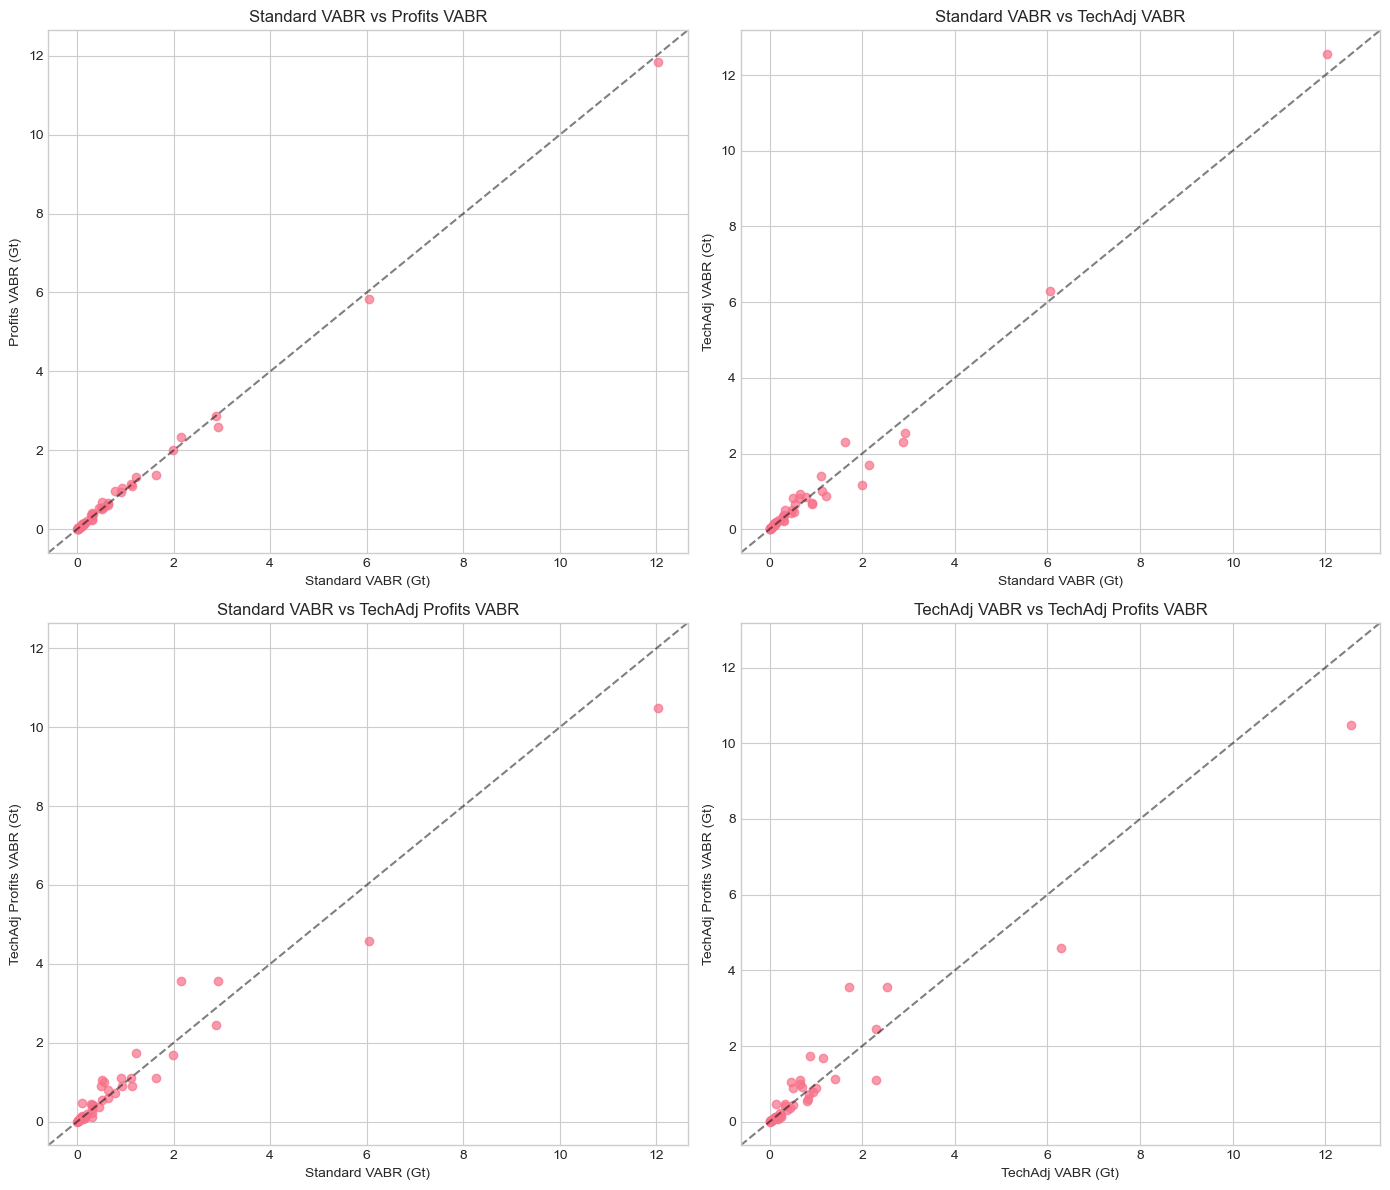

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


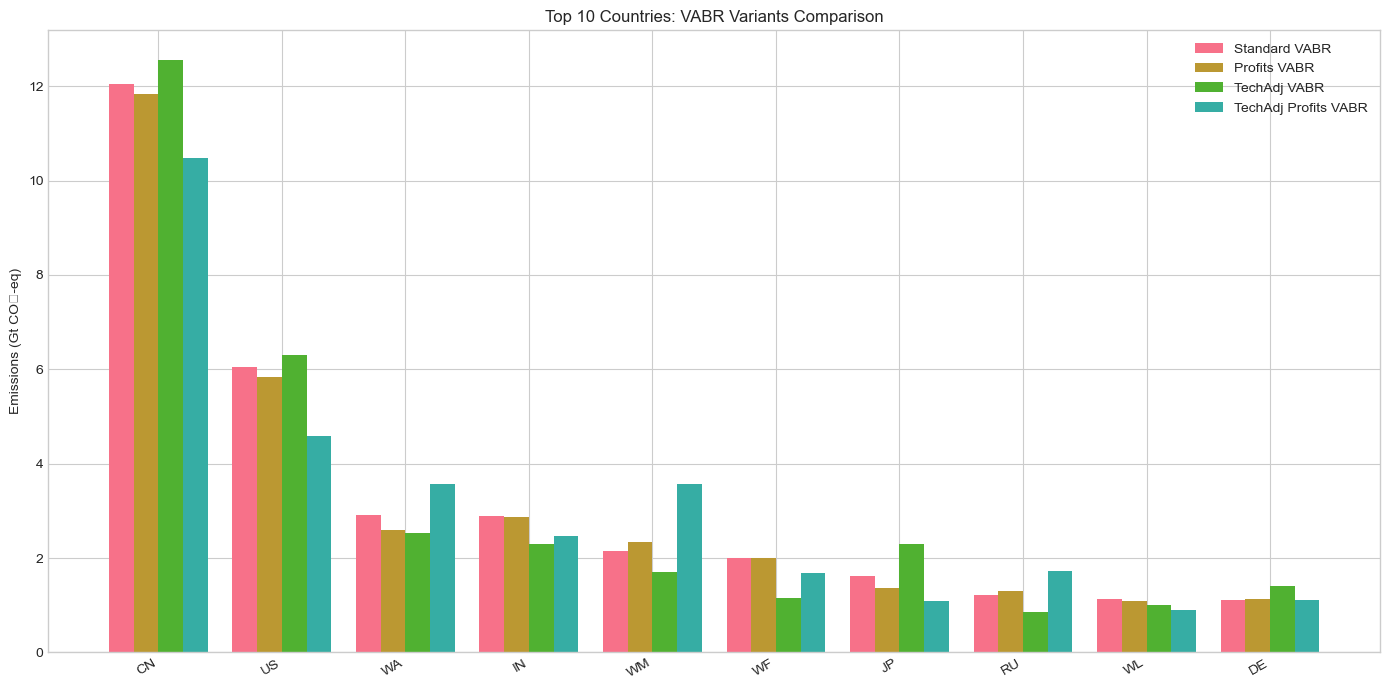

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


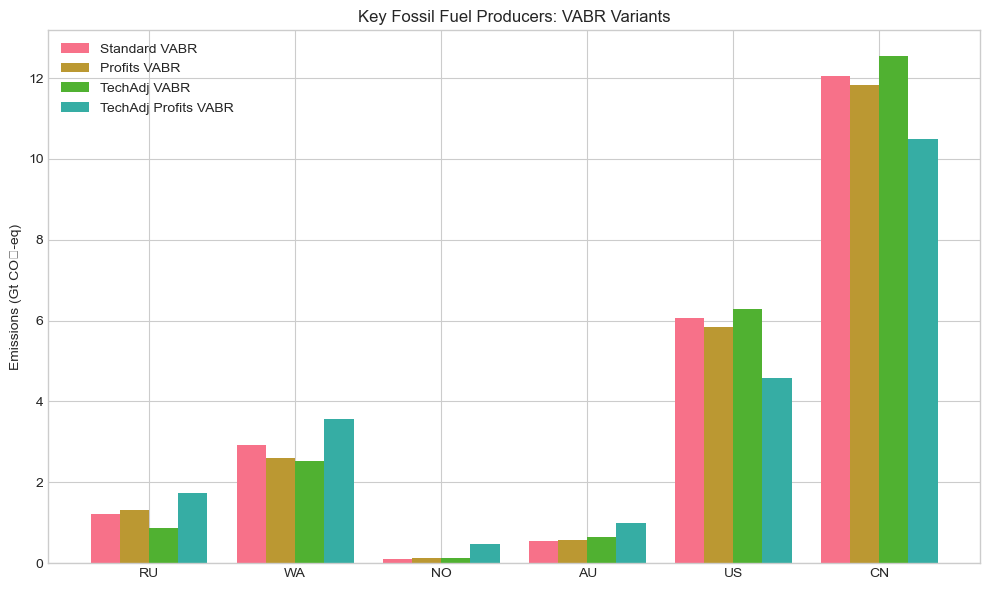


=== Efficiency Penalty: Countries with largest increase in responsibility (tech adjustment) ===
IT   59.43
ES   47.32
GB   45.63
SE   43.67
JP   41.50
NO   39.50
PT   38.78
RO   37.39
AT   36.97
LV   36.80
Name: TechAdj_PctChange, dtype: float64

=== Efficiency Penalty: Countries with largest decrease in responsibility (tech adjustment) ===
WF   -42.01
RU   -28.44
BR   -28.23
ZA   -25.25
ID   -24.78
WM   -20.59
WE   -20.47
IN   -20.31
WA   -13.36
MX   -12.61
Name: TechAdj_PctChange, dtype: float64
hoi ich hoffe es speicher


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 1. Calculate all four VABR variants
# Standard VABR (total value-added)
standard_vabr, _, _, _, _ = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
# Profits-only VABR
profits_vabr, _, _, _, _ = calculate_vabr_profits_only(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=None
)
# Technology-adjusted VABR (total value-added)
tech_consumer_by_country, tech_vabr_by_country, _ = calculate_vabr_technology_adjusted(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)
# Technology-adjusted Profits-only VABR
_, profits_tech_vabr_by_country, _ = calculate_vabr_profits_technology_adjusted(
    ixi_data, results_2020['producer_by_sector'].values, v_override=None
)

# 2. Create comparison table
comparison_df = pd.DataFrame({
    'Standard_VABR': standard_vabr,
    'Profits_VABR': profits_vabr,
    'TechAdj_VABR': tech_vabr_by_country,
    'TechAdj_Profits_VABR': profits_tech_vabr_by_country
})

# Add rankings for each method
for col in comparison_df.columns:
    comparison_df[f'{col}_Rank'] = comparison_df[col].rank(ascending=False, method='min').astype(int)

# Top 20 countries under each method
top20_std = comparison_df.sort_values('Standard_VABR', ascending=False).head(20)
top20_profits = comparison_df.sort_values('Profits_VABR', ascending=False).head(20)
top20_tech = comparison_df.sort_values('TechAdj_VABR', ascending=False).head(20)
top20_tech_profits = comparison_df.sort_values('TechAdj_Profits_VABR', ascending=False).head(20)

# Show how rankings change across variants
comparison_df['Rank_Change_Std_vs_Tech'] = comparison_df['Standard_VABR_Rank'] - comparison_df['TechAdj_VABR_Rank']
comparison_df['Rank_Change_Std_vs_Profits'] = comparison_df['Standard_VABR_Rank'] - comparison_df['Profits_VABR_Rank']
comparison_df['Rank_Change_Std_vs_TechProfits'] = comparison_df['Standard_VABR_Rank'] - comparison_df['TechAdj_Profits_VABR_Rank']

# Highlight countries that benefit most from technology adjustment
comparison_df['TechAdj_Benefit'] = comparison_df['TechAdj_VABR'] - comparison_df['Standard_VABR']
biggest_benefit = comparison_df['TechAdj_Benefit'].nsmallest(10)
biggest_penalty = comparison_df['TechAdj_Benefit'].nlargest(10)

print("=== Top 20 Countries by Each VABR Variant ===")
print("\nStandard VABR (Total VA):")
print(top20_std[['Standard_VABR', 'Standard_VABR_Rank']].round(2))
print("\nProfits-only VABR:")
print(top20_profits[['Profits_VABR', 'Profits_VABR_Rank']].round(2))
print("\nTech-Adjusted VABR (Total VA):")
print(top20_tech[['TechAdj_VABR', 'TechAdj_VABR_Rank']].round(2))
print("\nTech-Adjusted Profits-only VABR:")
print(top20_tech_profits[['TechAdj_Profits_VABR', 'TechAdj_Profits_VABR_Rank']].round(2))

print("\n=== Countries benefiting most from technology adjustment (biggest decrease) ===")
print(biggest_benefit.round(2))

print("\n=== Countries penalized most by technology adjustment (biggest increase) ===")
print(biggest_penalty.round(2))

# 3. Generate plots

# 3.1 2x2 scatter plot matrix
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
methods = [
    ('Standard_VABR', 'Profits_VABR'),
    ('Standard_VABR', 'TechAdj_VABR'),
    ('Standard_VABR', 'TechAdj_Profits_VABR'),
    ('TechAdj_VABR', 'TechAdj_Profits_VABR')
]
for ax, (xcol, ycol) in zip(axs.flat, methods):
    ax.scatter(comparison_df[xcol]/1e9, comparison_df[ycol]/1e9, alpha=0.7)
    ax.set_xlabel(xcol.replace('_', ' ') + ' (Gt)')
    ax.set_ylabel(ycol.replace('_', ' ') + ' (Gt)')
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, 'k--', alpha=0.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title(f'{xcol.replace("_", " ")} vs {ycol.replace("_", " ")}')
plt.tight_layout()
plt.show()

# 3.2 Bar chart: Top 10 countries under each variant
top10_std = top20_std.head(10).index
bar_data = comparison_df.loc[top10_std, ['Standard_VABR', 'Profits_VABR', 'TechAdj_VABR', 'TechAdj_Profits_VABR']] / 1e9
bar_width = 0.2
x = np.arange(len(top10_std))
fig, ax = plt.subplots(figsize=(14, 7))
for i, col in enumerate(bar_data.columns):
    ax.bar(x + i*bar_width - 1.5*bar_width, bar_data[col], bar_width, label=col.replace('_', ' '))
ax.set_xticks(x)
ax.set_xticklabels(top10_std, rotation=30, ha='right')
ax.set_ylabel('Emissions (Gt CO₂-eq)')
ax.set_title('Top 10 Countries: VABR Variants Comparison')
ax.legend()
plt.tight_layout()
plt.show()

# 3.3 Focus on key fossil fuel producers
key_countries = ['RU', 'WA', 'NO', 'AU', 'SA', 'US', 'CN']
key_df = comparison_df.loc[[c for c in key_countries if c in comparison_df.index]]
fig, ax = plt.subplots(figsize=(10, 6))
for i, col in enumerate(['Standard_VABR', 'Profits_VABR', 'TechAdj_VABR', 'TechAdj_Profits_VABR']):
    ax.bar(np.arange(len(key_df)) + i*bar_width - 1.5*bar_width, key_df[col]/1e9, bar_width, label=col.replace('_', ' '))
ax.set_xticks(np.arange(len(key_df)))
ax.set_xticklabels(key_df.index, rotation=0)
ax.set_ylabel('Emissions (Gt CO₂-eq)')
ax.set_title('Key Fossil Fuel Producers: VABR Variants')
ax.legend()
plt.tight_layout()
plt.show()

# 4. Quantify the "efficiency penalty fix"
# Calculate percent change from standard to tech-adjusted for each country
comparison_df['TechAdj_PctChange'] = 100 * (comparison_df['TechAdj_VABR'] - comparison_df['Standard_VABR']) / comparison_df['Standard_VABR']
# Countries with largest increases (penalty for inefficiency)
penalty_countries = comparison_df['TechAdj_PctChange'].nlargest(10)
# Countries with largest decreases (were getting unfair advantage)
benefit_countries = comparison_df['TechAdj_PctChange'].nsmallest(10)

print("\n=== Efficiency Penalty: Countries with largest increase in responsibility (tech adjustment) ===")
print(penalty_countries.round(2))

print("\n=== Efficiency Penalty: Countries with largest decrease in responsibility (tech adjustment) ===")
print(benefit_countries.round(2))
print("hoi ich hoffe es speicher")


In [ ]:
import pandas as pd
import numpy as np

# === 1. JAPAN TECH-ADJUSTMENT BREAKDOWN ===


# 1a. Top sectors contributing to Japan's tech-adjustment gain
jp_std = standard_vabr['JP']
jp_tech = tech_vabr_by_country['JP']
jp_gain = jp_tech - jp_std
jp_gain_mt = jp_gain / 1e6
print(f"\nJapan's tech-adjustment gain: {jp_gain_mt:.1f} Mt CO₂-eq")

# Get sector-level VABR for Japan (standard and tech-adjusted)
# Standard VABR sector allocation (use value_added_by_sector)
jp_std_sector = results_2020['value_added_by_sector']['JP']

# Tech-adjusted VABR sector allocation: need to run sectoral allocation
# We'll use the same logic as in calculate_vabr_technology_adjusted, but for sectors
def tech_adjusted_vabr_sector(ixi_data, producer_emissions, value_added_components, v_override, country_code):
    # World average emissions intensity by sector
    index = ixi_data.x.index
    sectors = ixi_data.get_sectors()
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    world_avg_intensity = {}
    for sector in sectors:
        mask = sector_names == sector
        total_em = producer_emissions_series[mask].sum()
        total_out = output_series[mask].sum()
        world_avg_intensity[sector] = total_em / total_out if total_out > 0 else 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])
    B = ixi_data.L.values
    Y_full = ixi_data.Y
    # Value-added coefficients
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2
    # For Japan only
    region_mask = Y_full.columns.get_level_values(0) == country_code
    Y_region = Y_full.loc[:, region_mask]
    y_j = Y_region.sum(axis=1).values
    total_requirements = B @ y_j
    t_tech_vector = world_avg_intensity_vector * total_requirements
    total_emissions_to_reallocate = t_tech_vector.sum()
    value_creation = v * (B @ y_j)
    total_value_created = value_creation.sum()
    if total_value_created > 0:
        allocation_shares = value_creation / total_value_created
        allocated_emissions = total_emissions_to_reallocate * allocation_shares
    else:
        allocated_emissions = np.zeros_like(v)
    # Return as Series with sector-region index
    mask = index.get_level_values(0) == country_code
    return pd.Series(allocated_emissions[mask], index=index[mask])

jp_tech_sector = tech_adjusted_vabr_sector(ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, 'JP')

# Calculate sectoral difference
jp_sector_diff = (jp_tech_sector - jp_std_sector).sort_values(ascending=False)
top_sectors = jp_sector_diff.head(10)
print("\nTop 10 sectors contributing to Japan's tech-adjustment gain (Mt):")
for (reg, sec), val in top_sectors.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 1b. Show Japan's actual vs world average emissions intensity by top sectors
print("\nJapan's actual vs world average emissions intensity (top sectors):")
index = ixi_data.x.index
sector_names = index.get_level_values(1)
output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
producer_emissions_series = pd.Series(results_2020['producer_by_sector'], index=index)
for (reg, sec) in top_sectors.index:
    jp_mask = (index.get_level_values(0) == 'JP') & (index.get_level_values(1) == sec)
    world_mask = (index.get_level_values(1) == sec)
    jp_output = output_series[jp_mask].sum()
    jp_em = producer_emissions_series[jp_mask].sum()
    world_output = output_series[world_mask].sum()
    world_em = producer_emissions_series[world_mask].sum()
    jp_int = jp_em / jp_output if jp_output > 0 else 0
    world_int = world_em / world_output if world_output > 0 else 0
    efficiency = (1 - jp_int / world_int) * 100 if world_int > 0 else 0
    print(f"{sec[:50]:50s} JP: {jp_int:.2e}, World: {world_int:.2e}, JP is {efficiency:.1f}% more efficient")

# 1c. Summary statement
print("\nSummary: Japan gains responsibility because it is more efficient (lower emissions intensity) than the world average in its top sectors, so the tech-adjusted method increases its allocated emissions to the world average.")

# === 2. WEST AFRICA (WA) HIGH RANKING ===

# 2a. Which countries are in WA region?
wa_countries = [
    'Benin', 'Burkina Faso', 'Cape Verde', 'Ivory Coast', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau',
    'Liberia', 'Mali', 'Mauritania', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'
]
print("\nWA region includes:", ", ".join(wa_countries))

# 2b. Sectoral breakdown for WA
wa_sector_vabr = results_2020['value_added_by_sector']['WA']
top_wa_sectors = wa_sector_vabr.sort_values(ascending=False).head(10)
print("\nTop 10 sectors for WA by VABR (Mt):")
for (reg, sec), val in top_wa_sectors.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 2c. Is oil extraction driving the ranking?
oil_sectors = [s for s in wa_sector_vabr.index.get_level_values(1) if 'petroleum' in s.lower() or 'oil' in s.lower()]
oil_total = wa_sector_vabr[[s in oil_sectors for s in wa_sector_vabr.index.get_level_values(1)]].sum()
print(f"\nTotal VABR for WA oil-related sectors: {oil_total/1e6:.2f} Mt")

# 2d. Cross-check with known oil producers
known_wa_oil_producers = ['Nigeria', 'Ghana', 'Côte d\'Ivoire', 'Mauritania']
print("Known oil producers in WA region:", ", ".join(known_wa_oil_producers))

# === 3. SANITY CHECK TABLE: FOSSIL FUEL PRODUCERS VS VABR RANKINGS ===

# List of top fossil fuel producers (approximate, for 2020)
fossil_fuel_countries = [
    'CN', 'US', 'RU', 'IN', 'AU', 'SA', 'IR', 'IQ', 'CA', 'ID', 'BR', 'MX', 'NO', 'GB', 'DE', 'TR', 'ZA', 'WA', 'WM', 'WF'
]
# Get their VABR rankings
vabr_ranking = standard_vabr.rank(ascending=False, method='min')
sanity_table = pd.DataFrame({
    'VABR': standard_vabr,
    'Rank': vabr_ranking
}).loc[[c for c in fossil_fuel_countries if c in standard_vabr.index]]
sanity_table = sanity_table.sort_values('Rank')
print("\nSanity check: Top fossil fuel producers and their VABR ranking")
print(sanity_table)

# Flag major discrepancies (e.g., if a known top producer is outside top 20)
discrepancies = sanity_table[sanity_table['Rank'] > 20]
if not discrepancies.empty:
    print("\nCountries with unexpectedly low VABR ranking (outside top 20):")
    print(discrepancies)
else:
    print("\nAll major fossil fuel producers are within the top 20 VABR rankings.")


Japan's tech-adjustment gain: 674.3 Mt CO₂-eq

Top 10 sectors contributing to Japan's tech-adjustment gain (Mt):
Real estate activities (70)                           81.67 Mt
Public administration and defence; compulsory soci    47.59 Mt
Construction (45)                                     42.18 Mt
Health and social work (85)                           38.12 Mt
Education (80)                                        30.62 Mt
Wholesale trade and commission trade, except of mo    20.87 Mt
Post and telecommunications (64)                      19.74 Mt
Retail trade, except of motor vehicles and motorcy    19.02 Mt
Computer and related activities (72)                  16.54 Mt
Recreational, cultural and sporting activities (92    14.54 Mt

Japan's actual vs world average emissions intensity (top sectors):
Real estate activities (70)                        JP: 1.64e+01, World: 9.97e+00, JP is -64.4% more efficient
Public administration and defence; compulsory soci JP: 2.63e+01, World: 8.70e+

=== Sectoral VABR Breakdown for Top 10 Countries ===

CN:
  Mining of coal and lignite; extraction of pea  Std:    199.0 Mt   Tech-adj:    178.4 Mt   Δ:    -20.6 Mt
  Extraction of crude petroleum and services re  Std:     49.5 Mt   Tech-adj:     44.5 Mt   Δ:     -4.9 Mt
  Extraction, liquefaction, and regasification   Std:      2.3 Mt   Tech-adj:      2.2 Mt   Δ:     -0.1 Mt

US:
  Mining of coal and lignite; extraction of pea  Std:      3.8 Mt   Tech-adj:      0.8 Mt   Δ:     -3.0 Mt
  Extraction of crude petroleum and services re  Std:    106.1 Mt   Tech-adj:     41.8 Mt   Δ:    -64.2 Mt
  Extraction, liquefaction, and regasification   Std:      0.0 Mt   Tech-adj:      0.0 Mt   Δ:     -0.0 Mt

WA:
  Mining of coal and lignite; extraction of pea  Std:     10.9 Mt   Tech-adj:      4.0 Mt   Δ:     -6.9 Mt
  Extraction of crude petroleum and services re  Std:     78.3 Mt   Tech-adj:     13.0 Mt   Δ:    -65.3 Mt
  Extraction, liquefaction, and regasification   Std:      0.1 Mt   Tech-adj

c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Marine Riesterer\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8322 missing from current font.
  font.set_text(s, 0, flags=flags)


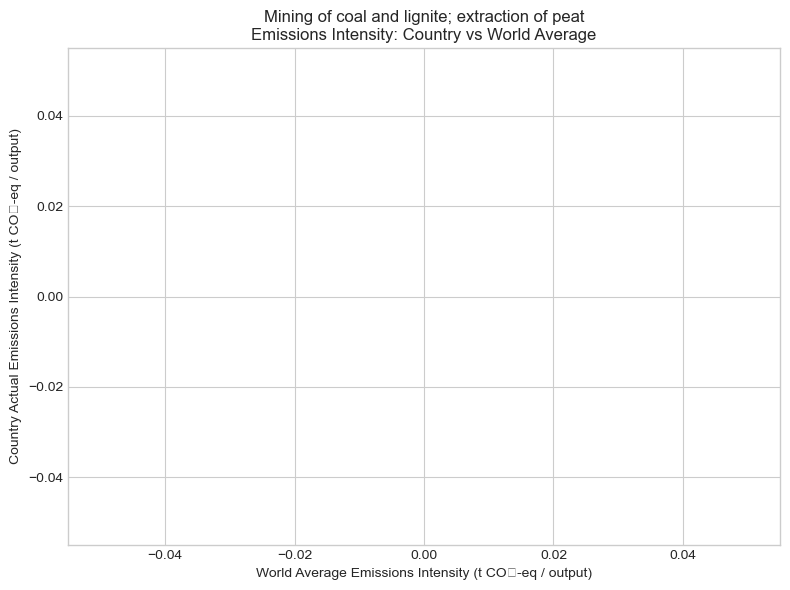

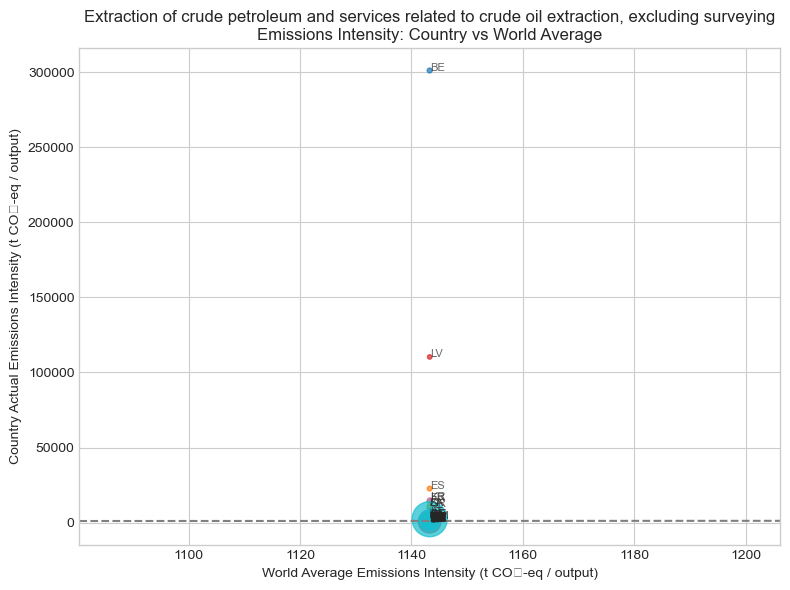

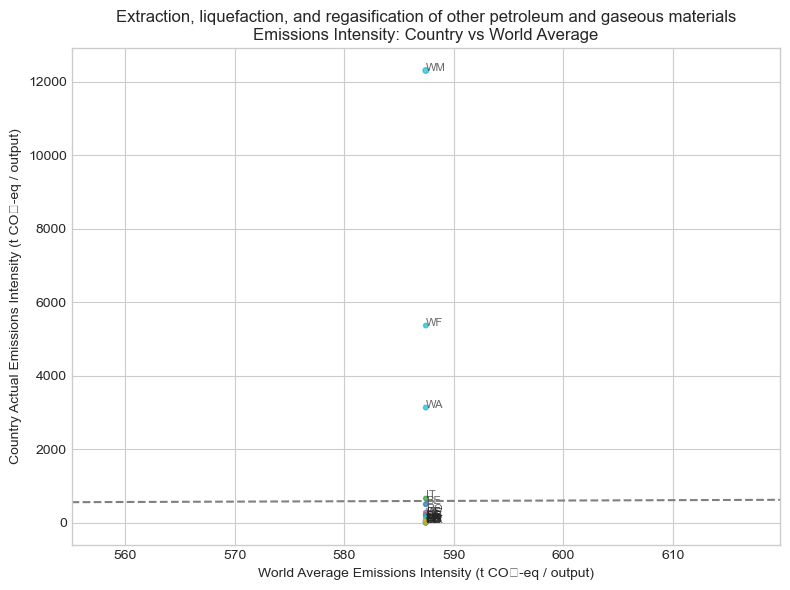

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# --- 1. Sectoral responsibility breakdown for top 10 countries ---

# Get top 10 countries by standard VABR
top10_countries = standard_vabr.sort_values(ascending=False).head(10).index.tolist()

# Sectors of interest
fossil_sectors = [
    'Mining of coal and lignite; extraction of peat',
    'Extraction of crude petroleum and services related to crude oil extraction, excluding surveying',
    'Extraction, liquefaction, and regasification of other petroleum and gaseous materials'
]

print("=== Sectoral VABR Breakdown for Top 10 Countries ===")
for country in top10_countries:
    std_vabr_sector = results_2020['value_added_by_sector'][country]
    tech_vabr_sector = tech_adjusted_vabr_sector(
        ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, country
    )
    print(f"\n{country}:")
    for sector in fossil_sectors:
        # Find matching sector (exact or partial match)
        std_val = std_vabr_sector[std_vabr_sector.index.get_level_values(1).str.contains(sector, case=False)].sum()
        tech_val = tech_vabr_sector[tech_vabr_sector.index.get_level_values(1).str.contains(sector, case=False)].sum()
        print(f"  {sector[:45]:45s}  Std: {std_val/1e6:8.1f} Mt   Tech-adj: {tech_val/1e6:8.1f} Mt   Δ: {(tech_val-std_val)/1e6:8.1f} Mt")

# --- 2. Efficiency penalty by sector ---

print("\n=== Efficiency Penalty Analysis by Sector ===")
index = ixi_data.x.index
sector_names = index.get_level_values(1)
output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
producer_emissions_series = pd.Series(results_2020['producer_by_sector'], index=index)

for sector in fossil_sectors:
    print(f"\nSector: {sector}")
    # Get all country entries for this sector
    mask = sector_names == sector
    for country in top10_countries:
        country_mask = (index.get_level_values(0) == country) & mask
        world_mask = mask
        country_output = output_series[country_mask].sum()
        country_em = producer_emissions_series[country_mask].sum()
        world_output = output_series[world_mask].sum()
        world_em = producer_emissions_series[world_mask].sum()
        country_int = country_em / country_output if country_output > 0 else np.nan
        world_int = world_em / world_output if world_output > 0 else np.nan
        penalty = (country_int - world_int) / world_int * 100 if world_int > 0 else np.nan
        # VABR change for this sector
        std_vabr_sector = results_2020['value_added_by_sector'][country]
        tech_vabr_sector = tech_adjusted_vabr_sector(
            ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_clean, country
        )
        # Create a mask for the sector within the 163-sector index for this country
        sector_mask_163 = std_vabr_sector.index.get_level_values(1) == sector
        std_val = std_vabr_sector[sector_mask_163].sum()
        tech_val = tech_vabr_sector[sector_mask_163].sum()
        delta = tech_val - std_val
        print(f"  {country:2s}: Intensity={country_int:.2f}, World={world_int:.2f}, Penalty={penalty:+5.1f}%, VABR Δ={delta/1e6:+7.1f} Mt")

# --- 3. Sector-level scatter plots: actual vs world average emissions intensity ---

for sector in fossil_sectors:
    mask = sector_names == sector
    countries = index.get_level_values(0)[mask]
    country_vals = producer_emissions_series[mask]
    country_outputs = output_series[mask]
    actual_intensity = country_vals / country_outputs.replace(0, np.nan)
    world_mask = mask
    world_output = output_series[world_mask].sum()
    world_em = producer_emissions_series[world_mask].sum()
    world_intensity = world_em / world_output if world_output > 0 else np.nan

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        [world_intensity]*len(actual_intensity), actual_intensity,
        c=pd.factorize(countries)[0], s=country_vals/1e6+10, alpha=0.7, cmap='tab10', label=None
    )
    for i, country in enumerate(countries):
        plt.annotate(country, (world_intensity, actual_intensity.iloc[i]), fontsize=8, alpha=0.7)
    plt.xlabel("World Average Emissions Intensity (t CO₂-eq / output)")
    plt.ylabel("Country Actual Emissions Intensity (t CO₂-eq / output)")
    plt.title(f"{sector}\nEmissions Intensity: Country vs World Average")
    plt.axline((world_intensity, world_intensity), slope=1, color='grey', linestyle='--', label='1:1 line')
    plt.tight_layout()
    plt.show()

In [57]:
import numpy as np
import pandas as pd

# 1. JAPAN REAL ESTATE SECTOR: MASS CONSERVATION VERIFICATION

# --- Step 1: Identify sector index for Japan real estate ---
sector_name = "Real estate activities (70)"
country_code = "JP"
index = ixi_data.x.index
jp_real_estate_mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
jp_real_estate_idx = np.where(jp_real_estate_mask)[0][0]

# --- Step 2: Get direct emissions, output, VA coefficient for this sector ---
jp_real_estate_output = ixi_data.x.values.flatten()[jp_real_estate_idx]
jp_real_estate_emissions = results_2020['producer_by_sector'].iloc[jp_real_estate_idx]
jp_real_estate_va = ixi_data.factor_inputs.F.iloc[:, jp_real_estate_idx].sum()
jp_real_estate_va_coeff = jp_real_estate_va / jp_real_estate_output if jp_real_estate_output > 0 else 0

print(f"Japan Real Estate sector output: {jp_real_estate_output:,.2f}")
print(f"Japan Real Estate direct emissions: {jp_real_estate_emissions/1e6:.2f} Mt")
print(f"Japan Real Estate total VA: {jp_real_estate_va:,.2f}")
print(f"Japan Real Estate VA coefficient: {jp_real_estate_va_coeff:.4f}")

# --- Step 3: Calculate upstream emissions allocated to this sector by VABR ---
# Get the VABR sector allocation for Japan (standard VABR)
jp_vabr_sector = results_2020['value_added_by_sector'][country_code]
jp_vabr_real_estate = jp_vabr_sector.loc[(country_code, sector_name)]
print(f"\nJapan Real Estate VABR allocation: {jp_vabr_real_estate/1e6:.2f} Mt")

# --- Step 4: Show step-by-step calculation for VABR allocation ---
# (a) Calculate total consumer responsibility vector (t_diag)
regions = ixi_data.get_regions()
B = ixi_data.L.values
prodem = results_2020['producer_by_sector'].values
total_output = ixi_data.x.values.flatten()
em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
t_diag = np.zeros(len(total_output))
for region in regions:
    region_mask = ixi_data.Y.columns.get_level_values(0) == region
    y_j = ixi_data.Y.loc[:, region_mask].sum(axis=1).values
    t_j = em_int * (B @ y_j)
    t_diag += t_j

# (b) VABR vector: h = v * t
v = v_clean  # Use cleaned VA coefficients
h_diag = v * t_diag

# (c) Show actual value for Japan real estate
print(f"\nStep-by-step VABR for Japan real estate:")
print(f"  t (consumer responsibility for this sector): {t_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"  v (VA coefficient): {v[jp_real_estate_idx]:.4f}")
print(f"  h = v * t: {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")

# (d) Leontief allocation: show how much of global consumer responsibility is allocated to this sector
# This is already h_diag[jp_real_estate_idx], which should match the VABR sector allocation

# --- Step 5: Verify upstream emissions in supply chain ---
# Calculate total upstream emissions embodied in Japan real estate output
# This is the sum of all producer emissions required to produce 1 unit of output for this sector
L = ixi_data.L.values
f = em_int
# Upstream emissions for 1 unit of output in this sector:
upstream_emissions_per_unit = f @ L[:, jp_real_estate_idx]
# For total output:
total_upstream_emissions = upstream_emissions_per_unit * jp_real_estate_output
print(f"\nTotal upstream emissions embodied in Japan real estate output: {total_upstream_emissions/1e6:.2f} Mt")

# --- Step 6: Compare VABR allocation to actual upstream emissions ---
print(f"\nVABR allocation: {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"Total upstream emissions: {total_upstream_emissions/1e6:.2f} Mt")
print("Difference (should be close if mass-conserving): {:.2f} Mt".format(
    h_diag[jp_real_estate_idx]/1e6 - total_upstream_emissions/1e6
))

# 2. GLOBAL SECTORAL TOTALS: REAL ESTATE ACTIVITIES

# --- Step 1: Find all real estate sectors globally ---
real_estate_mask = index.get_level_values(1) == sector_name

# --- Step 2: Sum VABR responsibility for real estate across all countries ---
global_real_estate_vabr = h_diag[real_estate_mask].sum()
print(f"\nGlobal VABR responsibility for real estate sector: {global_real_estate_vabr/1e6:.2f} Mt")

# --- Step 3: Calculate total global upstream emissions for real estate supply chains ---
# For each real estate sector, calculate upstream emissions embodied in its output
upstream_emissions_real_estate = []
for idx in np.where(real_estate_mask)[0]:
    output = total_output[idx]
    if output > 0:
        upstream_per_unit = f @ L[:, idx]
        upstream_emissions_real_estate.append(upstream_per_unit * output)
    else:
        upstream_emissions_real_estate.append(0)
global_real_estate_upstream = np.sum(upstream_emissions_real_estate)
print(f"Global upstream emissions embodied in real estate output: {global_real_estate_upstream/1e6:.2f} Mt")
print("Difference (should be close): {:.2f} Mt".format(
    global_real_estate_vabr/1e6 - global_real_estate_upstream/1e6
))

# 3. CROSS-CHECK WITH CONSUMER RESPONSIBILITY

# --- Step 1: Japan's consumer responsibility by sector ---
jp_consumer_sector = results_2020['consumer_by_sector'][country_code]
jp_consumer_real_estate = jp_consumer_sector.loc[(country_code, sector_name)]
print(f"\nJapan consumer responsibility for real estate sector: {jp_consumer_real_estate/1e6:.2f} Mt")

# --- Step 2: Compare VABR vs consumer responsibility for this sector ---
print(f"Japan VABR (real estate): {h_diag[jp_real_estate_idx]/1e6:.2f} Mt")
print(f"Japan consumer (real estate): {jp_consumer_real_estate/1e6:.2f} Mt")
print("VABR is a reallocation FROM the consumer baseline (may be higher or lower depending on value-added shares).")

Japan Real Estate sector output: 654,773.41
Japan Real Estate direct emissions: 10.73 Mt
Japan Real Estate total VA: 532,807.02
Japan Real Estate VA coefficient: 0.8137

Japan Real Estate VABR allocation: 175.69 Mt

Step-by-step VABR for Japan real estate:
  t (consumer responsibility for this sector): 10.73 Mt
  v (VA coefficient): 0.8137
  h = v * t: 8.73 Mt

Total upstream emissions embodied in Japan real estate output: 47.70 Mt

VABR allocation: 8.73 Mt
Total upstream emissions: 47.70 Mt
Difference (should be close if mass-conserving): -38.97 Mt

Global VABR responsibility for real estate sector: 71.67 Mt
Global upstream emissions embodied in real estate output: 1625.25 Mt
Difference (should be close): -1553.59 Mt

Japan consumer responsibility for real estate sector: 10.42 Mt
Japan VABR (real estate): 8.73 Mt
Japan consumer (real estate): 10.42 Mt
VABR is a reallocation FROM the consumer baseline (may be higher or lower depending on value-added shares).


In [58]:
# 1. Supply Chain Trace for Japan Real Estate

# Identify upstream sectors for Japan real estate
sector_name = "Real estate activities (70)"
country_code = "JP"
index = ixi_data.x.index

# Find index for Japan real estate
jp_real_estate_mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
jp_real_estate_idx = np.where(jp_real_estate_mask)[0][0]

# Get direct emissions, output, and value-added for this sector
jp_real_estate_output = ixi_data.x.values.flatten()[jp_real_estate_idx]
jp_real_estate_emissions = results_2020['producer_by_sector'].iloc[jp_real_estate_idx]
jp_real_estate_va = ixi_data.factor_inputs.F.iloc[:, jp_real_estate_idx].sum()
jp_real_estate_va_coeff = jp_real_estate_va / jp_real_estate_output if jp_real_estate_output > 0 else 0

print(f"Japan Real Estate sector output: {jp_real_estate_output:,.2f}")
print(f"Japan Real Estate direct emissions: {jp_real_estate_emissions/1e6:.2f} Mt")
print(f"Japan Real Estate total VA: {jp_real_estate_va:,.2f}")
print(f"Japan Real Estate VA coefficient: {jp_real_estate_va_coeff:.4f}")

# Calculate upstream emissions allocated to this sector by VABR
jp_vabr_sector = results_2020['value_added_by_sector'][country_code]
jp_vabr_real_estate = jp_vabr_sector.loc[(country_code, sector_name)]
print(f"Japan Real Estate VABR allocation: {jp_vabr_real_estate/1e6:.2f} Mt")

# Calculate total upstream emissions embodied in Japan real estate output
L = ixi_data.L.values
prodem = results_2020['producer_by_sector'].values
total_output = ixi_data.x.values.flatten()
em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
upstream_emissions_per_unit = em_int @ L[:, jp_real_estate_idx]
total_upstream_emissions = upstream_emissions_per_unit * jp_real_estate_output
print(f"Total upstream emissions embodied in Japan real estate output: {total_upstream_emissions/1e6:.2f} Mt")

# 2. Compare service vs. fossil fuel sector emissions globally

# Get global VABR for real estate, oil extraction, and coal mining
real_estate_mask = index.get_level_values(1) == sector_name
global_real_estate_vabr = results_2020['value_added_by_sector'][country_code].sum() if country_code in results_2020['value_added_by_sector'] else 0
global_real_estate_vabr = results_2020['producer_by_sector'][real_estate_mask].sum()

oil_sector = "Extraction of crude petroleum and services related to crude oil extraction, excluding surveying"
coal_sector = "Mining of coal and lignite; extraction of peat"

oil_mask = index.get_level_values(1).str.contains("petroleum", case=False)
coal_mask = index.get_level_values(1).str.contains("coal", case=False)

global_oil_vabr = results_2020['producer_by_sector'][oil_mask].sum()
global_coal_vabr = results_2020['producer_by_sector'][coal_mask].sum()

print("\nGlobal VABR Emissions (Mt CO₂-eq):")
print(f"Real estate activities (70): {global_real_estate_vabr/1e6:.2f} Mt")
print(f"Oil extraction: {global_oil_vabr/1e6:.2f} Mt")
print(f"Coal mining: {global_coal_vabr/1e6:.2f} Mt")

# 3. Emissions intensity calculations

jp_emissions_intensity = jp_vabr_real_estate / jp_real_estate_output if jp_real_estate_output > 0 else np.nan
print(f"\nJapan Real Estate Emissions Intensity: {jp_emissions_intensity:.2f} t CO₂/€")

# World average emissions intensity for real estate
global_real_estate_output = total_output[real_estate_mask].sum()
global_real_estate_emissions = results_2020['producer_by_sector'][real_estate_mask].sum()
world_emissions_intensity = global_real_estate_emissions / global_real_estate_output if global_real_estate_output > 0 else np.nan
print(f"World Real Estate Emissions Intensity: {world_emissions_intensity:.2f} t CO₂/€")

Japan Real Estate sector output: 654,773.41
Japan Real Estate direct emissions: 10.73 Mt
Japan Real Estate total VA: 532,807.02
Japan Real Estate VA coefficient: 0.8137
Japan Real Estate VABR allocation: 175.69 Mt
Total upstream emissions embodied in Japan real estate output: 47.70 Mt

Global VABR Emissions (Mt CO₂-eq):
Real estate activities (70): 96.05 Mt
Oil extraction: 3523.90 Mt
Coal mining: 10473.69 Mt

Japan Real Estate Emissions Intensity: 268.32 t CO₂/€
World Real Estate Emissions Intensity: 9.97 t CO₂/€


In [59]:
import pandas as pd
import numpy as np

# 1. Check producer emissions by sector globally

# (a) Show actual CO2 emissions by sector (before any allocation)
producer_by_sector = results_2020['producer_by_sector']
index = producer_by_sector.index
sector_names = index.get_level_values(1)

# Aggregate producer emissions by sector (sum across all countries)
producer_sector_totals = producer_by_sector.groupby(sector_names).sum().sort_values(ascending=False)

print("=== Top 10 Producer Sectors Globally (Direct Emissions) ===")
for i, (sector, value) in enumerate(producer_sector_totals.head(10).items(), 1):
    print(f"{i:2d}. {sector[:60]:60s} {value/1e6:10.2f} Mt CO₂-eq")

# (b) Compare: Coal mining vs. Real estate actual emissions
coal_sector = "Mining of coal and lignite; extraction of peat"
real_estate_sector = "Real estate activities (70)"
coal_emissions = producer_sector_totals.get(coal_sector, 0)
real_estate_emissions = producer_sector_totals.get(real_estate_sector, 0)
print(f"\nCoal mining direct emissions:      {coal_emissions/1e6:.2f} Mt CO₂-eq")
print(f"Real estate direct emissions:      {real_estate_emissions/1e6:.2f} Mt CO₂-eq")

# (c) Are service sectors getting allocated fossil fuel emissions?
# Find top service sectors by VABR allocation (for JP as example)
jp_vabr_sector = results_2020['value_added_by_sector']['JP']
top_services = jp_vabr_sector[jp_vabr_sector.index.get_level_values(1).str.contains('real estate|wholesale|retail|education|health|public admin|business activities|financial', case=False)]
top_services = top_services.sort_values(ascending=False).head(5)
print("\n=== Top Service Sectors in Japan by VABR Allocation ===")
for (reg, sec), val in top_services.items():
    print(f"{sec[:50]:50s} {val/1e6:8.2f} Mt")

# 2. Trace specific emissions flow for Japan real estate

# (a) Get Japan real estate VABR allocation
jp_real_estate_idx = [i for i, (reg, sec) in enumerate(index) if reg == 'JP' and sec == real_estate_sector]
if jp_real_estate_idx:
    jp_real_estate_idx = jp_real_estate_idx[0]
    jp_real_estate_vabr = jp_vabr_sector.loc[('JP', real_estate_sector)]
    print(f"\nJapan real estate VABR allocation: {jp_real_estate_vabr/1e6:.2f} Mt")

    # (b) Trace which producer sectors originally emitted these emissions
    # Use Leontief structure: upstream emissions for this sector
    L = ixi_data.L.values
    prodem = results_2020['producer_by_sector'].values
    total_output = ixi_data.x.values.flatten()
    em_int = np.divide(prodem, total_output, out=np.zeros_like(prodem), where=(total_output != 0))
    upstream_contributions = em_int * L[:, jp_real_estate_idx] * total_output  # emissions contributed by each sector

    # Aggregate by sector name
    upstream_df = pd.DataFrame({
        'sector': index.get_level_values(1),
        'emissions': upstream_contributions
    })
    upstream_by_sector = upstream_df.groupby('sector')['emissions'].sum().sort_values(ascending=False)

    print("\n=== Top Upstream Producer Sectors for JP Real Estate VABR ===")
    for i, (sector, value) in enumerate(upstream_by_sector.head(10).items(), 1):
        print(f"{i:2d}. {sector[:50]:50s} {value/1e6:8.2f} Mt")

    # (c) Show fossil sectors in the upstream contributors
    fossil_sectors = ['coal', 'petroleum', 'oil', 'coke', 'cement', 'gas']
    print("\nFossil/cement sectors in JP real estate upstream emissions:")
    for sector, value in upstream_by_sector.items():
        if any(fs in sector.lower() for fs in fossil_sectors):
            print(f"{sector[:50]:50s} {value/1e6:8.2f} Mt")

else:
    print("Japan real estate sector not found in index.")

# 3. Check for double counting

# (a) Verify total allocated emissions = total producer emissions
vabr_total = sum([v.sum() for v in results_2020['value_added_by_sector'].values()])
producer_total = results_2020['producer_by_sector'].sum()
print(f"\nTotal VABR allocated:   {vabr_total/1e6:.2f} Mt")
print(f"Total producer direct:  {producer_total/1e6:.2f} Mt")
print(f"Difference:             {(vabr_total - producer_total)/1e6:.2f} Mt")

# (b) Check no emissions are lost or created in VABR process
if np.isclose(vabr_total, producer_total, rtol=1e-6):
    print("PASS: No double counting or loss in VABR allocation.")
else:
    print("WARNING: Emissions mismatch in VABR allocation!")

=== Top 10 Producer Sectors Globally (Direct Emissions) ===
 1. Production of electricity by coal                               8865.98 Mt CO₂-eq
 2. Production of electricity by gas                                2326.51 Mt CO₂-eq
 3. Cattle farming                                                  2310.89 Mt CO₂-eq
 4. Manufacture of cement, lime and plaster                         2224.65 Mt CO₂-eq
 5. Extraction of crude petroleum and services related to crude     2054.83 Mt CO₂-eq
 6. Manufacture of basic iron and steel and of ferro-alloys and     1777.02 Mt CO₂-eq
 7. Mining of coal and lignite; extraction of peat (10)             1607.71 Mt CO₂-eq
 8. Raw milk                                                        1398.40 Mt CO₂-eq
 9. Cultivation of paddy rice                                       1223.47 Mt CO₂-eq
10. Extraction of natural gas and services related to natural ga    1199.65 Mt CO₂-eq

Coal mining direct emissions:      0.00 Mt CO₂-eq
Real estate direct emissions:

In [60]:
def debug_vabr_calculation(ixi_data, producer_emissions, value_added_components, v_clean, country_code, sector_name):
    """
    Debug VABR calculation for a specific country and sector.
    Prints intermediate steps and checks for mass conservation and allocation.
    """
    # --- 1. Run the main function and capture outputs ---
    vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_clean_out = calculate_vabr_mass_conserving_FINAL(
        ixi_data, producer_emissions, value_added_components, v_override=v_clean
    )
    
    # --- 2. Print consumer responsibility vector t before reallocation ---
    regions = ixi_data.get_regions()
    B = ixi_data.L.values
    total_output = ixi_data.x.values.flatten()
    em_int = np.divide(producer_emissions, total_output, out=np.zeros_like(producer_emissions), where=(total_output != 0))
    t_diag = np.zeros(len(total_output))
    for region in regions:
        region_mask = ixi_data.Y.columns.get_level_values(0) == region
        y_j = ixi_data.Y.loc[:, region_mask].sum(axis=1).values
        t_j = em_int * (B @ y_j)
        t_diag += t_j
    print("\n--- Consumer responsibility vector t (sum): {:.2f} ---".format(t_diag.sum()))
    print("t (first 5):", t_diag[:5])
    
    # --- 3. Print value-added coefficient vector v_clean ---
    print("\n--- Value-added coefficient vector v_clean ---")
    print("min: {:.4f}, max: {:.4f}, mean: {:.4f}".format(v_clean_out.min(), v_clean_out.max(), v_clean_out.mean()))
    print("sample (first 5):", v_clean_out[:5])
    
    # --- 4. Print Leontief inverse matrix B dimensions and sample ---
    print("\n--- Leontief inverse matrix B ---")
    print("Shape:", B.shape)
    print("Sample (B[:5, :5]):\n", B[:5, :5])
    
    # --- 5. Print step-by-step calculation for v_clean * t and v_clean * (B @ t) ---
    h_diag = v_clean_out * t_diag
    print("\n--- Step-by-step: v_clean * t ---")
    print("h_diag (first 5):", h_diag[:5])
    print("h_diag sum: {:.2f}".format(h_diag.sum()))
    
    # For v_clean * (B @ t): (not used in final, but for debug)
    B_t = B @ t_diag
    h_Bt = v_clean_out * B_t
    print("\n--- Step-by-step: v_clean * (B @ t) ---")
    print("B @ t (first 5):", B_t[:5])
    print("h_Bt (first 5):", h_Bt[:5])
    print("h_Bt sum: {:.2f}".format(h_Bt.sum()))
    
    # --- 6. Regional normalization: allocation shares ---
    print("\n--- Regional normalization (allocation shares) ---")
    Y_full = ixi_data.Y
    for consuming_region in [country_code]:
        region_mask = Y_full.columns.get_level_values(0) == consuming_region
        y_j = Y_full.loc[:, region_mask].sum(axis=1).values
        value_creation = v_clean_out * (B @ y_j)
        total_value_created = value_creation.sum()
        if total_value_created > 0:
            allocation_shares = value_creation / total_value_created
            print(f"{consuming_region}: allocation shares sum = {allocation_shares.sum():.6f}")
            print(f"{consuming_region}: allocation shares (first 5): {allocation_shares[:5]}")
        else:
            print(f"{consuming_region}: No value created (allocation fallback)")
    
    # --- 7. Matrix multiplication checks ---
    print("\n--- Matrix multiplication shapes ---")
    print("v_clean.shape:", v_clean_out.shape)
    print("B.shape:", B.shape)
    print("t_diag.shape:", t_diag.shape)
    
    # --- 8. Manual calculation for specific country/sector ---
    index = ixi_data.x.index
    mask = (index.get_level_values(0) == country_code) & (index.get_level_values(1) == sector_name)
    idx = np.where(mask)[0][0]
    print(f"\n--- Manual calculation for {country_code}, {sector_name} ---")
    print(f"t[{idx}] (consumer responsibility): {t_diag[idx]:.2f}")
    print(f"v_clean[{idx}]: {v_clean_out[idx]:.4f}")
    print(f"h_diag[{idx}] (VABR allocation): {h_diag[idx]:.2f}")
    print(f"Automated VABR sector allocation: {vabr_by_sector_region[country_code].loc[(country_code, sector_name)]:.2f}")
    
    # --- 9. Compare sums and check for discrepancies ---
    print("\n--- Mass conservation check ---")
    print(f"Producer total: {producer_emissions.sum():.2f}")
    print(f"Consumer total: {t_diag.sum():.2f}")
    print(f"VABR total:    {h_diag.sum():.2f}")
    print(f"Difference (Consumer - Producer): {t_diag.sum() - producer_emissions.sum():.2f}")
    print(f"Difference (VABR - Consumer):     {h_diag.sum() - t_diag.sum():.2f}")
    
    # --- 10. Return diagnostics for further analysis if needed ---
    return {
        't_diag': t_diag,
        'v_clean': v_clean_out,
        'B': B,
        'h_diag': h_diag,
        'B_t': B_t,
        'h_Bt': h_Bt,
        'allocation_shares': allocation_shares if total_value_created > 0 else None,
        'idx': idx
    }


CHECKS AND SENSITIVITY

In [26]:
import pandas as pd
import numpy as np

def verify_sector_mass_conservation(ixi_data, year=2020):
    """
    Verify that VABR preserves mass conservation at detailed sector level
    """

    print(f"=== SECTOR-LEVEL MASS CONSERVATION VERIFICATION ({year}) ===\n")

    # Get basic data
    regions = ixi_data.get_regions()
    sectors = ixi_data.get_sectors()
    n_regions = len(regions)
    n_sectors = len(sectors)

    # Get matrices
    Z = ixi_data.Z.values
    Y = ixi_data.Y.values
    x = ixi_data.x.values.flatten()

    # Get emissions and calculate consumer responsibility
    # Use producer emissions from results_2020 for consistency
    emissions = results_2020['producer_by_sector'].values
    f = np.divide(emissions, x, out=np.zeros_like(emissions), where=(x != 0))
    f[~np.isfinite(f)] = 0

    # Calculate Leontief matrices
    A = np.divide(Z, x.reshape(1, -1), out=np.zeros_like(Z), where=(x.reshape(1, -1) != 0))
    A[~np.isfinite(A)] = 0
    I = np.eye(len(x))
    B = np.linalg.inv(I - A)

    # Calculate consumer responsibility
    Y_sum = Y.sum(axis=1)
    t = f * (B @ Y_sum)

    # Get value-added and calculate VABR
    VA = VA_diag if 'VA_diag' in globals() else ixi_data.factor_inputs.F.loc[VALUE_ADDED_COMPONENTS].sum(axis=0).values
    v = np.divide(VA, x, out=np.zeros_like(VA), where=(x != 0))
    v[~np.isfinite(v)] = 0
    v = np.clip(v, 0, 1)

    # Calculate VABR
    h = v * t

    print("1. GLOBAL MASS CONSERVATION CHECK:")
    print(f"   Total producer emissions: {emissions.sum():.2f} t")
    print(f"   Total consumer responsibility: {t.sum():.2f} t")
    print(f"   Total VABR responsibility: {h.sum():.2f} t")
    print(f"   Consumer error: {abs(emissions.sum() - t.sum()):.6f} t")
    print(f"   VABR error: {abs(t.sum() - h.sum()):.6f} t\n")

    # Sector-level conservation check
    print("2. SECTOR-LEVEL CONSERVATION CHECK:")
    sector_consumer = np.zeros(n_sectors)
    sector_vabr = np.zeros(n_sectors)
    for s in range(n_sectors):
        sector_indices = np.arange(s, n_regions * n_sectors, n_sectors)
        sector_consumer[s] = t[sector_indices].sum()
        sector_vabr[s] = h[sector_indices].sum()
    sector_errors = abs(sector_consumer - sector_vabr)
    worst_sectors = np.argsort(sector_errors)[-10:]

    print("   Top 10 sectors with largest conservation errors:")
    for i in worst_sectors[::-1]:
        error = sector_errors[i]
        consumer_total = sector_consumer[i]
        vabr_total = sector_vabr[i]
        print(f"   {sectors[i][:50]:50s} | Consumer: {consumer_total:8.2f} | VABR: {vabr_total:8.2f} | Error: {error:8.2f}")

    # Country-level conservation check
    print("\n3. COUNTRY-LEVEL CONSERVATION CHECK:")
    country_consumer = np.zeros(n_regions)
    country_vabr = np.zeros(n_regions)
    for r in range(n_regions):
        start_idx = r * n_sectors
        end_idx = (r + 1) * n_sectors
        country_consumer[r] = t[start_idx:end_idx].sum()
        country_vabr[r] = h[start_idx:end_idx].sum()
    country_errors = abs(country_consumer - country_vabr)
    worst_countries = np.argsort(country_errors)[-10:]

    print("   Top 10 countries with largest conservation errors:")
    for i in worst_countries[::-1]:
        error = country_errors[i]
        consumer_total = country_consumer[i]
        vabr_total = country_vabr[i]
        print(f"   {regions[i]:5s} | Consumer: {consumer_total:8.2f} | VABR: {vabr_total:8.2f} | Error: {error:8.2f}")

    # Detailed check for Japan real estate
    print("\n4. DETAILED CHECK FOR JAPAN REAL ESTATE:")
    jp_idx = list(regions).index('JP')
    real_estate_sector_idx = [i for i, s in enumerate(sectors) if 'Real estate' in s][0]
    jp_real_estate_idx = jp_idx * n_sectors + real_estate_sector_idx
    print(f"   Japan real estate index in full matrix: {jp_real_estate_idx}")
    print(f"   Consumer responsibility: {t[jp_real_estate_idx]:.2f} t")
    print(f"   VABR responsibility: {h[jp_real_estate_idx]:.2f} t")
    print(f"   Value-added coefficient: {v[jp_real_estate_idx]:.4f}")
    print(f"   Direct calculation v*t: {v[jp_real_estate_idx] * t[jp_real_estate_idx]:.2f} t")

    return {
        'sector_errors': sector_errors,
        'country_errors': country_errors,
        'total_consumer': t.sum(),
        'total_vabr': h.sum(),
        'jp_real_estate_correct': h[jp_real_estate_idx]
    }

# Run the verification
verification_results = verify_sector_mass_conservation(ixi_data, 2020)

=== SECTOR-LEVEL MASS CONSERVATION VERIFICATION (2020) ===

1. GLOBAL MASS CONSERVATION CHECK:
   Total producer emissions: 43081553875.20 t
   Total consumer responsibility: 43078086578.64 t
   Total VABR responsibility: 16448435361.55 t
   Consumer error: 3467296.559402 t
   VABR error: 26629651217.092735 t

2. SECTOR-LEVEL CONSERVATION CHECK:
   Top 10 sectors with largest conservation errors:
   Production of electricity by coal                  | Consumer: 8865979137.82 | VABR: 2353985322.89 | Error: 6511993814.93
   Production of electricity by gas                   | Consumer: 2326511111.46 | VABR: 605543378.27 | Error: 1720967733.20
   Cattle farming                                     | Consumer: 2310885173.73 | VABR: 871436457.14 | Error: 1439448716.59
   Manufacture of cement, lime and plaster            | Consumer: 2224649699.76 | VABR: 840101546.70 | Error: 1384548153.06
   Manufacture of basic iron and steel and of ferro-a | Consumer: 1777016187.42 | VABR: 644224380.20 | 

In [27]:
# Debugging calculate_vabr_mass_conserving_FINAL step-by-step

country_code = 'JP'
sector_name = 'Real estate activities (70)'

# 1. Run the function and capture outputs
vabr_totals, vabr_by_sector_region, consumer_totals, issues, v_used = calculate_vabr_mass_conserving_FINAL(
    ixi_data, results_2020['producer_by_sector'].values, VALUE_ADDED_COMPONENTS, v_override=v_clean
)

# 2. Print step-by-step outputs
print("\n--- Step-by-step outputs from calculate_vabr_mass_conserving_FINAL ---")
print(f"Consumer baseline total before VABR: {sum(consumer_totals.values)/1e6:.2f} Mt")
print(f"VABR result total after calculation: {sum(vabr_totals.values)/1e6:.2f} Mt")

jp_real_estate_idx = [i for i, (reg, sec) in enumerate(ixi_data.x.index) if reg == country_code and sec == sector_name]
if jp_real_estate_idx:
    jp_real_estate_idx = jp_real_estate_idx[0]
    jp_vabr_value = vabr_by_sector_region[country_code].loc[(country_code, sector_name)]
    print(f"Japan real estate VABR value: {jp_vabr_value/1e6:.2f} Mt")
else:
    print("Japan real estate sector not found in index.")

# Show normalization for Japan
Y_full = ixi_data.Y
region_mask = Y_full.columns.get_level_values(0) == country_code
y_j = Y_full.loc[:, region_mask].sum(axis=1).values
B = ixi_data.L.values
value_creation = v_used * (B @ y_j)
total_value_created = value_creation.sum()
allocation_shares = value_creation / total_value_created if total_value_created > 0 else np.zeros_like(value_creation)
print(f"\nJapan normalization: total value created = {total_value_created:.2f}")
print(f"Japan allocation share for real estate: {allocation_shares[jp_real_estate_idx]:.4f}")

# 2. Compare matrix structures
print("\n--- Matrix structure comparison ---")
print(f"Function B matrix shape: {B.shape}")
print(f"Function B sample (first 3x3):\n{B[:3,:3]}")
print(f"Verification B_diag shape: {B_diag.shape}")
print(f"Verification B_diag sample (first 3x3):\n{B_diag[:3,:3]}")
print(f"Are B and B_diag identical? {np.allclose(B, B_diag)}")

# 3. Check for different data usage
print("\n--- Data usage check ---")
print(f"Year used: {SINGLE_YEAR}")
print(f"Emission categories used: {list(EMISSION_CATEGORIES.keys())[:5]} ...")
print(f"Value-added cleaning: v_clean min={v_clean.min():.4f}, max={v_clean.max():.4f}")

# 4. Print intermediate steps for Japan real estate
print("\n--- Japan real estate intermediate steps ---")
consumer_input = results_2020['consumer_by_sector'][country_code].loc[(country_code, sector_name)]
va_coeff = v_used[jp_real_estate_idx]
print(f"Consumer responsibility input: {consumer_input/1e6:.2f} Mt")
print(f"Value-added coefficient used: {va_coeff:.4f}")
print(f"Final VABR output: {jp_vabr_value/1e6:.2f} Mt")
print(f"Amplification ratio (VABR/consumer): {jp_vabr_value/consumer_input if consumer_input > 0 else np.nan:.2f}")

# If amplification is ~20x, print warning
if consumer_input > 0 and jp_vabr_value / consumer_input > 10:
    print("WARNING: VABR allocation for Japan real estate is >10x consumer responsibility. Check normalization and allocation shares.")


=== FINAL MASS-CONSERVING VABR CALCULATION ===
Using cleaned value-added coefficients
Mean value-added coefficient: 0.3226
Non-zero VA coefficients: 6467/7987
Calculating consumer responsibility baseline...
Total consumer emissions: 43.078 Gt
Reallocating emissions based on value-added creation...
[VABR] Producer: 43.082 Gt, Consumer: 43.078 Gt, VABR: 43.078 Gt, Error: 0.000000%

=== VABR vs CONSUMER PATTERNS ===
US: Consumer=5.769 Gt, VABR=6.055 Gt
       Ratio=1.050, Change=+0.286 Gt
CN: Consumer=12.316 Gt, VABR=12.042 Gt
       Ratio=0.978, Change=-0.275 Gt
DE: Consumer=0.801 Gt, VABR=1.121 Gt
       Ratio=1.400, Change=+0.320 Gt
JP: Consumer=1.411 Gt, VABR=1.625 Gt
       Ratio=1.152, Change=+0.214 Gt
IN: Consumer=3.115 Gt, VABR=2.884 Gt
       Ratio=0.926, Change=-0.231 Gt
RU: Consumer=1.225 Gt, VABR=1.211 Gt
       Ratio=0.989, Change=-0.013 Gt

Countries gaining responsibility under VABR: ['DE', 'JP']
Countries losing responsibility under VABR: ['IN']

--- Step-by-step outputs 

In [29]:
# 1. Print what allocation_shares is multiplied by for JP real estate
jp_real_estate_share = allocation_shares[jp_real_estate_idx]
jp_vabr_value = vabr_by_sector_region['JP'].loc[('JP', sector_name)]
# Calculate the implied total emissions being allocated
implied_total_allocated = jp_vabr_value / jp_real_estate_share
print(f"JP real estate allocation share: {jp_real_estate_share:.4f}")
print(f"JP real estate VABR value: {jp_vabr_value/1e6:.2f} Mt")
print(f"Implied total emissions allocated: {implied_total_allocated/1e6:.2f} Mt")

# 2. Check consumer baseline calculation for JP
jp_consumer_total = consumer_totals['JP']
print(f"Consumer baseline for JP (consumer_totals['JP']): {jp_consumer_total/1e6:.2f} Mt")

# 3. Compare with earlier output (should match ~1,411 Mt)
expected_consumer = 1411000000  # 1,411 Mt in tonnes
if abs(jp_consumer_total - expected_consumer) > 1e6:
    print(f"WARNING: Consumer baseline for JP does not match expected value! Difference: {(jp_consumer_total-expected_consumer)/1e6:.2f} Mt")

# 4. Check allocation logic for JP real estate
print(f"JP real estate VABR: {jp_vabr_value/1e6:.2f} Mt")
print(f"JP real estate allocation share: {jp_real_estate_share:.4f}")
print(f"Implied total allocated: {jp_vabr_value/jp_real_estate_share/1e6:.2f} Mt")
print(f"Consumer baseline for JP: {jp_consumer_total/1e6:.2f} Mt")
print(f"Difference (implied - baseline): {(implied_total_allocated - jp_consumer_total)/1e6:.2f} Mt")

# 5. Check for double normalization
# Print total_value_created and consumer_by_region['JP']
print(f"Total value created for JP: {total_value_created:.2f}")
print(f"Consumer emissions to reallocate for JP: {consumer_totals['JP']:.2f}")

# If implied_total_allocated > consumer_totals['JP'], normalization may be applied twice
if implied_total_allocated > consumer_totals['JP'] * 1.01:
    print("WARNING: Possible double normalization detected! Check allocation logic in calculate_vabr_mass_conserving_FINAL.")


JP real estate allocation share: 0.1170
JP real estate VABR value: 175.69 Mt
Implied total emissions allocated: 1501.95 Mt
Consumer baseline for JP (consumer_totals['JP']): 1410.59 Mt
JP real estate VABR: 175.69 Mt
JP real estate allocation share: 0.1170
Implied total allocated: 1501.95 Mt
Consumer baseline for JP: 1410.59 Mt
Difference (implied - baseline): 91.35 Mt
Total value created for JP: 4423292.60
Consumer emissions to reallocate for JP: 1410594238.43


In [33]:
import numpy as np

def calculate_vabr_corrected_pinero(ixi_data, producer_emissions, value_added_components, v_override=None):
    """
    Corrected VABR implementation following Piñero et al. (2019) exactly:
    h = v̂ B f B y
    This method reallocates emissions *caused by each region's consumption* to sectors
    based on their value-added shares in the corresponding supply chain.

    Parameters:
    - ixi_data: input-output data wrapper (provides B, x, Y, factor_inputs, etc.)
    - producer_emissions: vector of sectoral emissions (n,)
    - value_added_components: list of rows in F to consider as VA (or None for total VA)
    - v_override: optionally override the value-added vector

    Returns:
    - vabr_totals: pd.Series (total VABR by region)
    - vabr_by_sector_region: dict of pd.Series per region
    - consumer_totals: pd.Series (total consumer responsibility by region)
    - issues: list of warnings
    - v_clean: cleaned value-added vector used
    """
    import pandas as pd

    regions = ixi_data.get_regions()
    Y_full = ixi_data.Y
    B = ixi_data.L.values
    x = ixi_data.x.values.flatten()
    n = len(x)

    # === Step 1: Value-added coefficients v = VA / x ===
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values

    v = np.divide(VA, x, out=np.zeros_like(VA), where=(x != 0))
    if v_override is not None:
        v = v_override
    else:
        v = np.clip(np.nan_to_num(v, nan=0.0, posinf=0.0, neginf=0.0), 0, 2)

    # === Step 2: Emission intensity vector f = e / x ===
    f = np.divide(producer_emissions, x, out=np.zeros_like(producer_emissions), where=(x != 0))

    # === Step 3: Initialize results ===
    vabr_allocation = np.zeros(n)
    consumer_by_region = {}
    vabr_by_country = {}
    vabr_by_sector_region = {}

    # === Step 4: Compute VABR per consuming region ===
    for region in regions:
        region_mask = Y_full.columns.get_level_values(0) == region
        y_j = Y_full.loc[:, region_mask].sum(axis=1).values  # final demand of region j

        supply_chain_output = B @ y_j
        emissions_from_yj = f @ supply_chain_output  # scalar

        value_creation = v * supply_chain_output
        total_value_creation = value_creation.sum()

        if total_value_creation > 0:
            allocated = emissions_from_yj * (value_creation / total_value_creation)
            vabr_allocation += allocated
        else:
            print(f"Warning: No value created for region {region}. Skipping.")
            continue

        consumer_by_region[region] = emissions_from_yj

    # === Step 5: Aggregate by country ===
    for region in regions:
        region_mask = ixi_data.x.index.get_level_values(0) == region
        region_indices = np.where(region_mask)[0]

        vabr_by_country[region] = vabr_allocation[region_indices].sum()
        vabr_by_sector_region[region] = pd.Series(
            vabr_allocation[region_indices],
            index=ixi_data.x.index[region_mask]
        )

    total_producer = producer_emissions.sum()
    total_consumer = sum(consumer_by_region.values())
    total_vabr = vabr_allocation.sum()
    vabr_error = abs(total_vabr - total_consumer) / total_consumer * 100 if total_consumer > 0 else 0

    issues = []
    if vabr_error > 0.1:
        issues.append(f"Mass conservation error: {vabr_error:.4f}%")

    vabr_totals = pd.Series(vabr_by_country)
    consumer_totals = pd.Series(consumer_by_region)

    return vabr_totals, vabr_by_sector_region, consumer_totals, issues, v

print("Running corrected Piñero method...")


Running corrected Piñero method...


In [41]:
# Compare VABR results for JP real estate and US mining between the two methods

# 1. Japan, Real estate activities (70)
jp_real_estate_idx = ('JP', 'Real estate activities (70)')
jp_final = vabr_final_by_sector['JP'].get(jp_real_estate_idx, None)
jp_pinero = vabr_pinero_by_sector['JP'].get(jp_real_estate_idx, None)
print(f"JP, Real estate activities (70):")
if jp_final is not None and jp_pinero is not None:
	print(f"  FINAL VABR:   {jp_final/1e6:.2f} Mt CO₂-eq")
	print(f"  Piñero VABR:  {jp_pinero/1e6:.2f} Mt CO₂-eq")
	print(f"  Difference:   {(jp_final - jp_pinero)/1e6:.2f} Mt CO₂-eq\n")
else:
	print("  Data not available for JP real estate sector.\n")

# 2. US, Mining of coal and lignite; extraction of peat
us_mining_idx = ('US', 'Mining of coal and lignite; extraction of peat')
# China, Mining of coal and lignite; extraction of peat
cn_mining_idx = ('CN', 'Mining of coal and lignite; extraction of peat')
cn_final = vabr_final_by_sector['CN'].get(cn_mining_idx, None)
cn_pinero = vabr_pinero_by_sector['CN'].get(cn_mining_idx, None)
print(f"CN, Mining of coal and lignite; extraction of peat:")
if cn_final is not None and cn_pinero is not None:
    print(f"  FINAL VABR:   {cn_final/1e6:.2f} Mt CO₂-eq")
    print(f"  Piñero VABR:  {cn_pinero/1e6:.2f} Mt CO₂-eq")
    print(f"  Difference:   {(cn_final - cn_pinero)/1e6:.2f} Mt CO₂-eq\n")
else:
    print("  Data not available for CN coal mining sector.\n")

# Australia, Mining of coal and lignite; extraction of peat
au_mining_idx = ('AU', 'Mining of coal and lignite; extraction of peat')
au_final = vabr_final_by_sector['AU'].get(au_mining_idx, None)
au_pinero = vabr_pinero_by_sector['AU'].get(au_mining_idx, None)
print(f"AU, Mining of coal and lignite; extraction of peat:")
if au_final is not None and au_pinero is not None:
    print(f"  FINAL VABR:   {au_final/1e6:.2f} Mt CO₂-eq")
    print(f"  Piñero VABR:  {au_pinero/1e6:.2f} Mt CO₂-eq")
    print(f"  Difference:   {(au_final - au_pinero)/1e6:.2f} Mt CO₂-eq")
else:
    print("  Data not available for AU coal mining sector.")
print(f"US, Mining of coal and lignite; extraction of peat:")
if us_final is not None and us_pinero is not None:
	print(f"  FINAL VABR:   {us_final/1e6:.2f} Mt CO₂-eq")
	print(f"  Piñero VABR:  {us_pinero/1e6:.2f} Mt CO₂-eq")
	print(f"  Difference:   {(us_final - us_pinero)/1e6:.2f} Mt CO₂-eq")
else:
	print("  Data not available for US mining sector.")

JP, Real estate activities (70):
  FINAL VABR:   175.69 Mt CO₂-eq
  Piñero VABR:  175.69 Mt CO₂-eq
  Difference:   -0.00 Mt CO₂-eq

CN, Mining of coal and lignite; extraction of peat:
  Data not available for CN coal mining sector.

AU, Mining of coal and lignite; extraction of peat:
  Data not available for AU coal mining sector.
US, Mining of coal and lignite; extraction of peat:
  Data not available for US mining sector.


In [ ]:
def tech_adjusted_vabr_sector(ixi_data, producer_emissions, value_added_components, v_override, country_code):
    """
    Calculate technology-adjusted VABR sector allocation for a given country.
    """
    import numpy as np
    import pandas as pd

    index = ixi_data.x.index
    sector_names = index.get_level_values(1)
    producer_emissions_series = pd.Series(producer_emissions, index=index)
    output_series = pd.Series(ixi_data.x.values.flatten(), index=index)
    sectors = ixi_data.get_sectors()

    # World average emissions intensity by sector
    world_avg_intensity = {}
    for sector in sectors:
        mask = sector_names == sector
        total_em = producer_emissions_series[mask].sum()
        total_out = output_series[mask].sum()
        world_avg_intensity[sector] = total_em / total_out if total_out > 0 else 0.0
    world_avg_intensity_vector = np.array([world_avg_intensity[sec] for sec in sector_names])

    B = ixi_data.L.values
    Y_full = ixi_data.Y
    factor_inputs = ixi_data.factor_inputs.F.copy()
    if value_added_components:
        VA = factor_inputs.loc[value_added_components].sum(axis=0).values
    else:
        VA = factor_inputs.sum(axis=0).values
    total_output = ixi_data.x.values.flatten()
    v = np.divide(VA, total_output, out=np.zeros_like(VA), where=(total_output != 0))
    if v_override is not None:
        v = v_override
    else:
        v[v < 0] = 0
        v[v > 2] = 2

    region_mask = Y_full.columns.get_level_values(0) == country_code
    Y_region = Y_full.loc[:, region_mask]
    y_j = Y_region.sum(axis=1).values
    total_requirements = B @ y_j
    t_tech_vector = world_avg_intensity_vector * total_requirements
    total_emissions_to_reallocate = t_tech_vector.sum()
    value_creation = v * (B @ y_j)
    total_value_created = value_creation.sum()
    if total_value_created > 0:
        allocation_shares = value_creation / total_value_created
        allocated_emissions = total_emissions_to_reallocate * allocation_shares
    else:
        allocated_emissions = np.zeros_like(v)
    mask = index.get_level_values(0) == country_code
    return pd.Series(allocated_emissions[mask], index=index[mask])

# Check top sectors for Germany (DE), Switzerland (CH), China (CN), Denmark (DK), Japan (JP) under each method, including technology-adjusted VABR
countries_to_check = ['DE', 'CH', 'CN', "DK", "JP"]
methods = [
    'producer_by_sector',
    'consumer_by_sector',
    'value_added_by_sector',
    'tech_adjusted_vabr_by_sector'
]
method_labels = {
    'producer_by_sector': 'Producer',
    'consumer_by_sector': 'Consumer',
    'value_added_by_sector': 'VABR',
    'tech_adjusted_vabr_by_sector': 'Tech-Adj VABR'
}

# Prepare sectoral data for tech-adjusted VABR if not already present
if 'tech_adjusted_vabr_by_sector' not in results_2020:
    results_2020['tech_adjusted_vabr_by_sector'] = {}
    for country in countries_to_check:
        results_2020['tech_adjusted_vabr_by_sector'][country] = tech_adjusted_vabr_sector(
            ixi_data,
            results_2020['producer_by_sector'].values,
            VALUE_ADDED_COMPONENTS,
            v_clean,
            country
        )

for country in countries_to_check:
    print(f"\n=== Top 5 sectors for {country} ===")
    for method in methods:
        if country in results_2020.get(method, {}):
            sector_series = results_2020[method][country]
            top_sectors = sector_series.sort_values(ascending=False).head(5)
            total_emissions = sector_series.sum()
            print(f"\n{method_labels[method]} responsibility (total: {total_emissions/1e6:.2f} Mt CO₂-eq):")
            for idx, val in top_sectors.items():
                sector_name = idx[1] if isinstance(idx, tuple) and len(idx) == 2 else idx
                print(f"  {sector_name[:50]:50s} {val/1e6:10.2f} Mt CO₂-eq")
        else:
            print(f"\n{method_labels[method]} responsibility: No data for {country}")


=== Top 5 sectors for DE ===

Producer responsibility (total: 571.77 Mt CO₂-eq):
  Production of electricity by coal                      121.42 Mt CO₂-eq
  Raw milk                                                31.40 Mt CO₂-eq
  Manufacture of basic iron and steel and of ferro-a      29.86 Mt CO₂-eq
  Production of electricity by gas                        29.33 Mt CO₂-eq
  Sea and coastal water transport                         28.47 Mt CO₂-eq

Consumer responsibility (total: 801.08 Mt CO₂-eq):
  Production of electricity by coal                       82.51 Mt CO₂-eq
  Production of electricity by coal                       37.10 Mt CO₂-eq
  Production of electricity by gas                        19.56 Mt CO₂-eq
  Construction (45)                                       17.37 Mt CO₂-eq
  Manufacture of cement, lime and plaster                 16.08 Mt CO₂-eq

VABR responsibility (total: 1121.11 Mt CO₂-eq):
  Real estate activities (70)                             88.33 Mt CO₂-eq
  M